# Importation bibliothèques nécessaires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn import metrics,ensemble,preprocessing,decomposition,neighbors
from sklearn.ensemble import GradientBoostingRegressor,RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix,RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

# Visualisation données

In [2]:
rec_pmana_w = pd.read_csv('donnees corail/pmana_w.csv', sep= ',')
rec_pmana_w['der_rec'] = rec_pmana_w['recouvrement corr %'].diff() #utilisé par le travail précédent
rec_pmana_w['DateTime'] = rec_pmana_w['DateTime'].astype('datetime64[ns]')
rec_pmana_w['temps']=(rec_pmana_w['DateTime'].diff())/np.timedelta64(1,'D')
rec_pmana_w['v_der_rec'] = rec_pmana_w['der_rec']/rec_pmana_w['temps'] #utilisé dorénavant pour prendre en compte le lapse de temps
rec_pmana_n = pd.read_csv('donnees corail/pmana_n.csv', sep= ',')
rec_pmana_n['der_rec'] = rec_pmana_n['recouvrement corr %'].diff()
rec_pmana_n['DateTime'] = rec_pmana_n['DateTime'].astype('datetime64[ns]')
rec_pmana_n['temps']=(rec_pmana_n['DateTime'].diff())/np.timedelta64(1,'D')
rec_pmana_n['v_der_rec'] = rec_pmana_n['der_rec']/rec_pmana_n['temps']
rec_amp_n = pd.read_csv('donnees corail/amp_no.csv', sep= ',')
rec_amp_n['der_rec'] = rec_amp_n['recouvrement corr %'].diff()
rec_amp_n['DateTime'] = rec_amp_n['DateTime'].astype('datetime64[ns]')
rec_amp_n['temps']=(rec_amp_n['DateTime'].diff())/np.timedelta64(1,'D')
rec_amp_n['v_der_rec'] = rec_amp_n['der_rec']/rec_amp_n['temps']
rec_amp_e = pd.read_csv('donnees corail/amp_eo.csv', sep= ',')
rec_amp_e['der_rec'] = rec_amp_e['recouvrement corr %'].diff()
rec_amp_e['DateTime'] = rec_amp_e['DateTime'].astype('datetime64[ns]')
rec_amp_e['temps']=(rec_amp_e['DateTime'].diff())/np.timedelta64(1,'D')
rec_amp_e['v_der_rec'] = rec_amp_e['der_rec']/rec_amp_e['temps']
rec_amp_w = pd.read_csv('donnees corail/amp_wo.csv', sep= ',')
rec_amp_w['der_rec'] = rec_amp_w['recouvrement corr %'].diff()
rec_amp_w['DateTime'] = rec_amp_w['DateTime'].astype('datetime64[ns]')
rec_amp_w['temps']=(rec_amp_w['DateTime'].diff())/np.timedelta64(1,'D')
rec_amp_w['v_der_rec'] = rec_amp_w['der_rec']/rec_amp_w['temps']

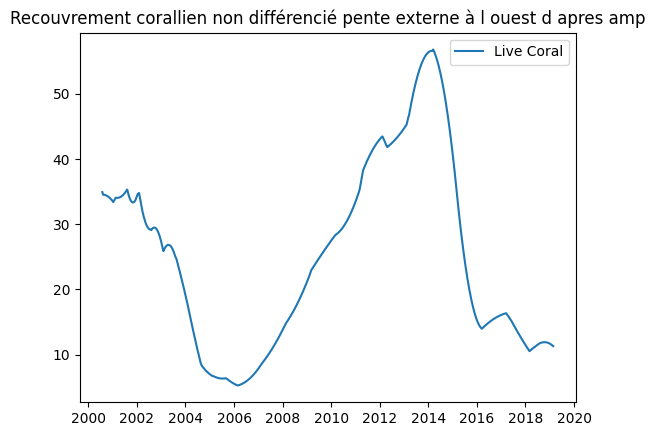

In [3]:
plt.plot(rec_amp_w['DateTime'], rec_amp_w['recouvrement corr %'], label = 'Live Coral')
plt.title('Recouvrement corallien non différencié pente externe à l ouest d apres amp')
plt.legend()

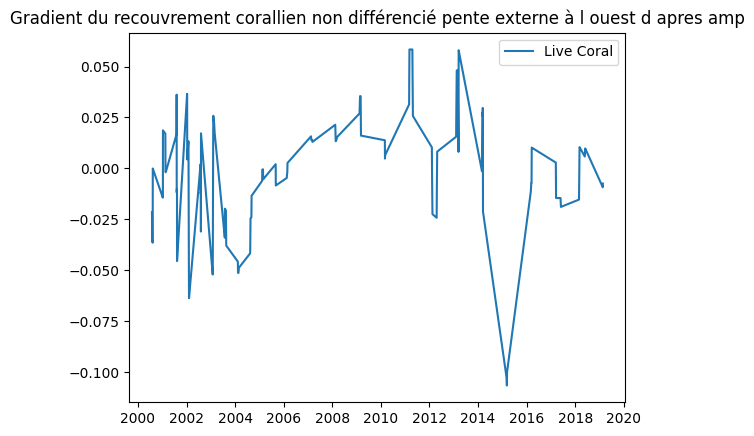

In [4]:
plt.plot(rec_amp_w['DateTime'], rec_amp_w['v_der_rec'], label = 'Live Coral')
plt.title('Gradient du recouvrement corallien non différencié pente externe à l ouest d apres amp')
plt.legend()

In [5]:
# Filtrer les dates etoiles de mer 
"""rec_amp_e = pd.concat([rec_amp_e[rec_amp_e['DateTime'] <= pd.to_datetime('2006-01-01')],rec_amp_e[rec_amp_e['DateTime'] >= pd.to_datetime('2011-01-01')]])
rec_amp_w = pd.concat([rec_amp_w[rec_amp_w['DateTime'] <= pd.to_datetime('2006-01-01')],rec_amp_w[rec_amp_w['DateTime'] >= pd.to_datetime('2011-01-01')]])
rec_amp_n = pd.concat([rec_amp_n[rec_amp_n['DateTime'] <= pd.to_datetime('2006-01-01')],rec_amp_n[rec_amp_n['DateTime'] >= pd.to_datetime('2011-01-01')]])
rec_pmana_w = pd.concat([rec_pmana_w[rec_pmana_w['DateTime'] <= pd.to_datetime('2006-01-01')],rec_pmana_w[rec_pmana_w['DateTime'] >= pd.to_datetime('2011-01-01')]])
rec_pmana_n = pd.concat([rec_pmana_n[rec_pmana_n['DateTime'] <= pd.to_datetime('2006-01-01')],rec_pmana_n[rec_pmana_n['DateTime'] >= pd.to_datetime('2011-01-01')]])"""

"rec_amp_e = pd.concat([rec_amp_e[rec_amp_e['DateTime'] <= pd.to_datetime('2006-01-01')],rec_amp_e[rec_amp_e['DateTime'] >= pd.to_datetime('2011-01-01')]])\nrec_amp_w = pd.concat([rec_amp_w[rec_amp_w['DateTime'] <= pd.to_datetime('2006-01-01')],rec_amp_w[rec_amp_w['DateTime'] >= pd.to_datetime('2011-01-01')]])\nrec_amp_n = pd.concat([rec_amp_n[rec_amp_n['DateTime'] <= pd.to_datetime('2006-01-01')],rec_amp_n[rec_amp_n['DateTime'] >= pd.to_datetime('2011-01-01')]])\nrec_pmana_w = pd.concat([rec_pmana_w[rec_pmana_w['DateTime'] <= pd.to_datetime('2006-01-01')],rec_pmana_w[rec_pmana_w['DateTime'] >= pd.to_datetime('2011-01-01')]])\nrec_pmana_n = pd.concat([rec_pmana_n[rec_pmana_n['DateTime'] <= pd.to_datetime('2006-01-01')],rec_pmana_n[rec_pmana_n['DateTime'] >= pd.to_datetime('2011-01-01')]])"

In [6]:
fill_sst = pd.read_csv('Tableaux finaux variables/fill_sst.csv', sep = ',')
fill_sst['DateTime'] = fill_sst['DateTime'].astype('datetime64[ns]')

In [7]:
pdo = pd.read_fwf('ersst.v5.pdo.txt', widths=[4, 6 , 6, 6, 6, 6, 6 , 6, 6, 6, 6, 6, 6])
pdo.rename(columns={'ERS' : 'Year', 'ST PDO' : '01', 'Index':'02', ':':'03', 'Unnamed: 4':'04', 'Unnamed: 5':'05', 'Unnamed: 6':'06', 'Unnamed: 7':'07', 'Unnamed: 8':'08', 'Unnamed: 9':'09', 'Unnamed: 10':'10', 'Unnamed: 11':'11', 'Unnamed: 12':'12'}, inplace = True)
pdo = pdo.loc[1:]
pdo = pdo.melt(id_vars=['Year'], var_name='Mois', value_name='pdo')

# Combine les colonnes 'Annee' et 'Mois' en une seule colonne 'Annee-Mois'
pdo['DateTime'] = pd.to_datetime(pdo['Year'].astype(str) + '-' + pdo['Mois'].astype(str), format='%Y-%m')
# Supprimer les colonnes 'Annee' et 'Mois' si nécessaire
pdo = pdo.drop(columns=['Year', 'Mois'])
pdo = pdo.sort_values(by='DateTime')
pdo.reset_index(drop=True, inplace=True)
pdo['pdo'] = pdo['pdo'].astype('Float64')

In [8]:
fill_energy_integrated = pd.read_csv('Tableaux finaux variables/fill_energy.csv', sep = ',')
fill_energy_integrated['DateTime'] = fill_energy_integrated['DateTime'].astype('datetime64[ns]')
fill_houle = pd.read_csv('Tableaux finaux variables/fill_houle.csv', sep = ',') 
fill_houle['DateTime'] = fill_houle['DateTime'].astype('datetime64[ns]')
salinite = pd.read_csv('Tableaux finaux variables/fill_salinite.csv', sep = ',') 
salinite['DateTime'] = salinite['DateTime'].astype('datetime64[ns]')
salinite = salinite.groupby(pd.Grouper(key='DateTime', freq='MS')).mean().reset_index()
salinite.rename(columns={'vosaline':'salinite'},inplace=True)
salinite = salinite[salinite['DateTime']!='2015-01-01']

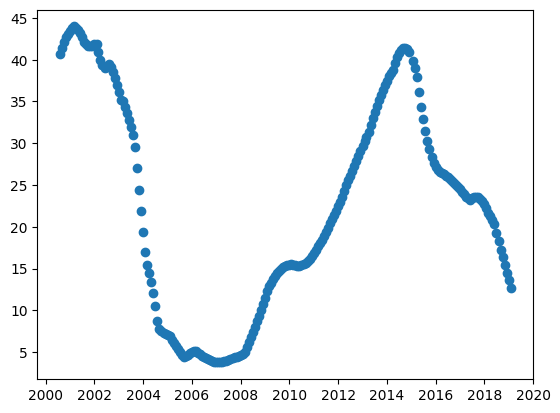

In [9]:
rec_ind_data = pd.merge(rec_amp_e, fill_sst, on = 'DateTime', how = 'inner')
av_pdo = rec_ind_data.copy()
rec_ind_data = pd.merge(rec_ind_data, pdo, on = 'DateTime', how = 'inner') # enleve beaucoup de données
rec_ind_data = pd.merge(rec_ind_data, fill_energy_integrated, on = 'DateTime', how = 'inner')
av_pdo=pd.merge(av_pdo,fill_energy_integrated, on='DateTime',how='inner')
av_pdo=pd.merge(av_pdo,fill_houle, on='DateTime',how='inner')
rec_ind_data_without_houle = rec_ind_data.copy()
rec_ind_data = pd.merge(rec_ind_data, fill_houle, on = 'DateTime', how = 'inner')
rec_ind_data_sal = pd.merge(rec_ind_data, salinite, on = 'DateTime', how = 'inner')
plt.scatter(rec_ind_data_sal['DateTime'],rec_ind_data_sal['recouvrement corr %'])

In [10]:
av_pdo.to_csv('Tableaux finaux variables/av_pdo.csv', index = False)

# Sobol Analyse

In [11]:
def partition(n, variable, interet, data):

    #### Partitionnement de la variable d'interêt en fonction de la variable explicative

    #### cette fonction prend les variables suivantes en entrée :
    # data = dataframe contenant toutes les variables
    # variable = nom de la colonne de la variable explicative dans data
    # interet = nom de la colonne de la variable cible dans data
    # n = nombre de bins désirées
    
    #### et rend les variables suivantes en sortie :
    # esperance = tableau avec l'esperance de la variable d'interet pour chaque catégorie de la variable explicative
    # bins = tableau avec le nombre d'élements pour chaque catégorie de la variable explicative
    # var_bins = tableau avec (n-1) tableaux où le tableau i contient les valeurs prises par la variable explicative pour la catégorie i

    # partitionnement par la valeur
    var_discrete = np.linspace(data[variable].min(), data[variable].max(), n)

    esperance = []
    bins = [] # contient le nombre de valeur dans chaque bins
    var_bins = [] # contient les valeurs de variables de chaque bins

    for i in range(n - 2):
        esp = data[interet][(data[variable] >= var_discrete[i])&(data[variable] < var_discrete[i + 1])].mean()
        count = data[interet][(data[variable] >= var_discrete[i])&(data[variable] < var_discrete[i + 1])].count()
        var = np.array(data[variable][(data[variable] >= var_discrete[i])&(data[variable] < var_discrete[i + 1])])
        esperance.append(esp)
        bins.append(count)
        var_bins.append(var.astype('float'))
    
    esp = data[interet][(data[variable] >= var_discrete[n - 2])&(data[variable] <= var_discrete[n - 1])].mean()
    count = data[interet][(data[variable] >= var_discrete[n - 2])&(data[variable] <= var_discrete[n - 1])].count()
    var = np.array(data[variable][(data[variable] >= var_discrete[n - 2])&(data[variable] <= var_discrete[n - 1])])
    esperance.append(esp)
    bins.append(count)
    var_bins.append(var.astype('float'))

    return(esperance, bins, var_bins)


Text(0.5, 1.0, 'Analyse Sobol DHW')

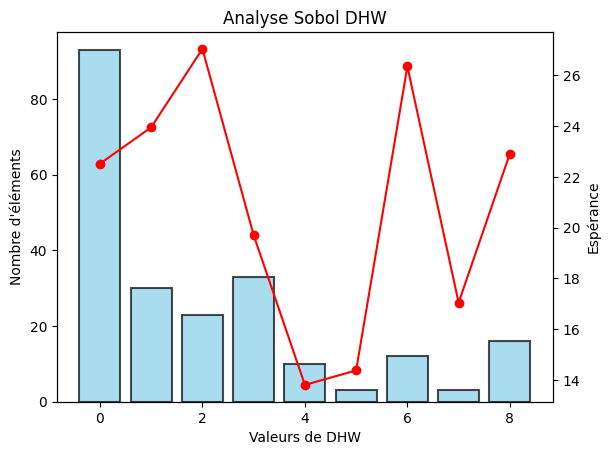

In [12]:
esperance, bins, var_bins = partition(10, 'dhw', 'recouvrement corr %', rec_ind_data)

plt.bar(np.linspace(0, 8, 9), bins, color='skyblue', alpha=0.7, edgecolor='black', linewidth=1.5) # représente le nombre d'éléments présents dans chaque catégorie
plt.ylabel('Nombre d\'éléments')
plt.xlabel('Valeurs de DHW')

ax2 = plt.gca().twinx()

ax2.plot(np.linspace(0, 8, 9), esperance, color='red', marker='o', linestyle='-') # correspond à l'espérance de la variable d'intérêt dans les différentes catégories
ax2.set_ylabel('Espérance')

plt.title('Analyse Sobol DHW')

Text(0.5, 1.0, 'Analyse Sobol MMM')

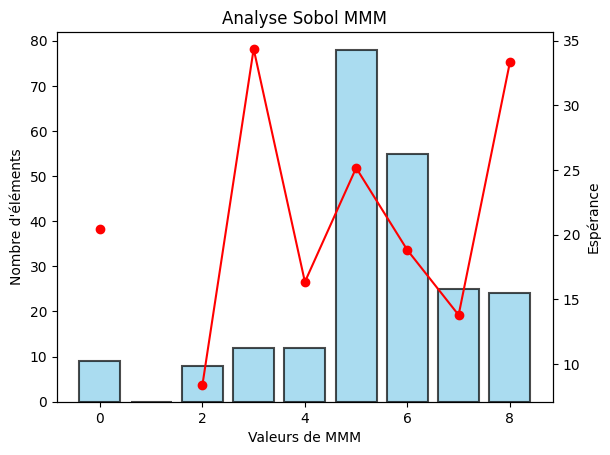

In [13]:
esperance, bins, var_bins = partition(10, 'MMM', 'recouvrement corr %', rec_ind_data)

plt.bar(np.linspace(0, 8, 9), bins, color='skyblue', alpha=0.7, edgecolor='black', linewidth=1.5)
plt.ylabel('Nombre d\'éléments')
plt.xlabel('Valeurs de MMM')

ax2 = plt.gca().twinx()

ax2.plot(np.linspace(0, 8, 9), esperance, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Espérance')

plt.title('Analyse Sobol MMM')

Text(0.5, 1.0, 'Analyse Sobol pdo')

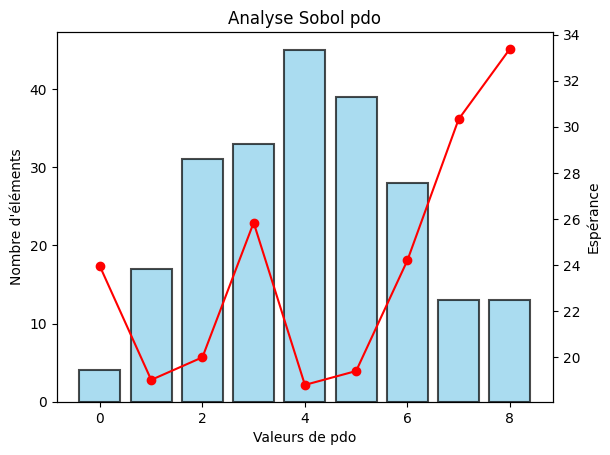

In [14]:
esperance, bins, var_bins = partition(10, 'pdo', 'recouvrement corr %', rec_ind_data)

plt.bar(np.linspace(0, 8, 9), bins, color='skyblue', alpha=0.7, edgecolor='black', linewidth=1.5)
plt.ylabel('Nombre d\'éléments')
plt.xlabel('Valeurs de pdo')

ax2 = plt.gca().twinx()

ax2.plot(np.linspace(0, 8, 9), esperance, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Espérance')

plt.title('Analyse Sobol pdo')

Text(0.5, 1.0, 'Analyse Sobol phioc')

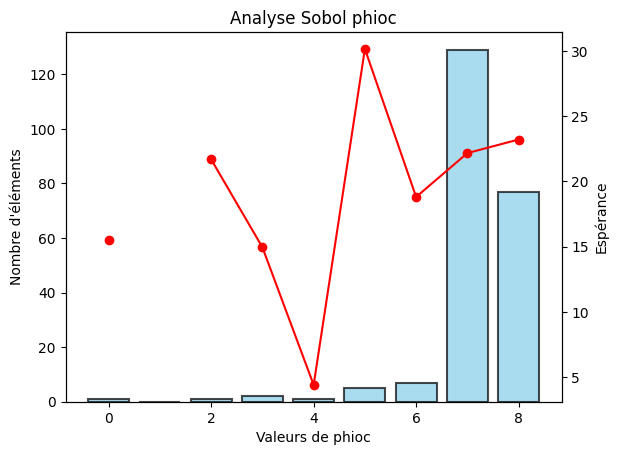

In [15]:
esperance, bins, var_bins = partition(10, 'phioc', 'recouvrement corr %', rec_ind_data)

plt.bar(np.linspace(0, 8, 9), bins, color='skyblue', alpha=0.7, edgecolor='black', linewidth=1.5)
plt.ylabel('Nombre d\'éléments')
plt.xlabel('Valeurs de phioc')

ax2 = plt.gca().twinx()

ax2.plot(np.linspace(0, 8, 9), esperance, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Espérance')

plt.title('Analyse Sobol phioc')

Text(0.5, 1.0, 'Analyse Sobol puissance')

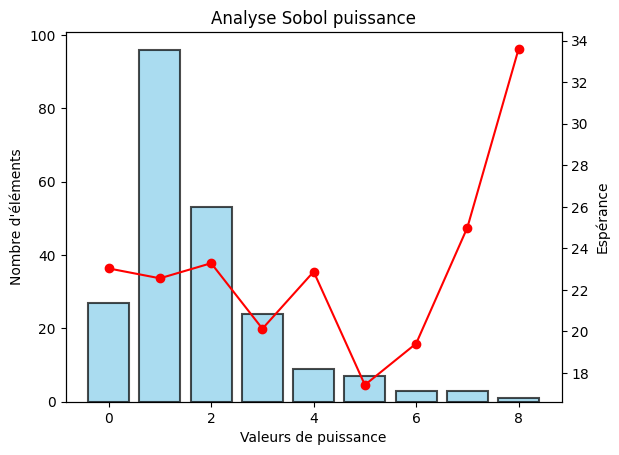

In [16]:
esperance, bins, var_bins = partition(10, 'puissance', 'recouvrement corr %', rec_ind_data)

plt.bar(np.linspace(0, 8, 9), bins, color='skyblue', alpha=0.7, edgecolor='black', linewidth=1.5)
plt.ylabel('Nombre d\'éléments')
plt.xlabel('Valeurs de puissance')

ax2 = plt.gca().twinx()

ax2.plot(np.linspace(0, 8, 9), esperance, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Espérance')

plt.title('Analyse Sobol puissance')

Text(0.5, 1.0, 'Analyse Sobol salinite')

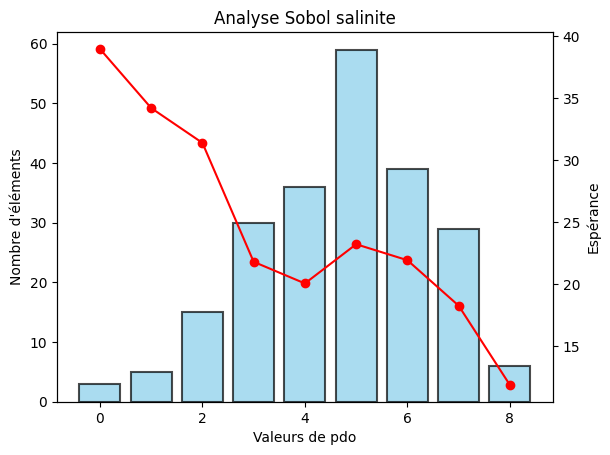

In [17]:
esperance, bins, var_bins = partition(10, 'salinite', 'recouvrement corr %', rec_ind_data_sal)

plt.bar(np.linspace(0, 8, 9), bins, color='skyblue', alpha=0.7, edgecolor='black', linewidth=1.5)
plt.ylabel('Nombre d\'éléments')
plt.xlabel('Valeurs de pdo')

ax2 = plt.gca().twinx()

ax2.plot(np.linspace(0, 8, 9), esperance, color='red', marker='o', linestyle='-')
ax2.set_ylabel('Espérance')

plt.title('Analyse Sobol salinite')

In [18]:
def interpol(esperance, var_bins):
    #### Interpolation de la variable d'intérêt pour toutes les valeurs prises par la variable explicative

    #### cette fonction prend les variables suivantes en entrée :
    # esperance = tableau avec l'esperance de la variable d'interet chaque catégorie de la variable explicative
    # var_bins = tableau avec (n-1) tableaux où le tableau i contient les valeurs prises par la variable explicative pour la catégorie i

    #### et rend les variables suivantes en sortie :
    # esperance_interpolation =  espérance interpolée pour toutes les valeurs prises par la variable explicative
    # valeurs_expl = toutes les valeurs prises par la variable explicative
    var_centre = [] #tableau contenant pour chaque catégorie la valeur centrale de la variable explicative
    for i in range(len(var_bins)):
        if len(var_bins[i]) !=0:
            var_centre.append(var_bins[i][len(var_bins[i])//2])
    
    interp_func = interp1d(var_centre, [x for x in esperance if not pd.isna(x)], kind='linear', fill_value='extrapolate') # fonction qui réalise l'interpolation de la fonction qui associe à la valeur centrale de la variable explicative de la catégorie i, l'esperance de la variable d'intérêt de la catégorie i
    valeurs_expl = np.unique(np.concatenate(var_bins)) # contient toutes les valeurs prises par la variable explicative
    esperance_interpolation = interp_func(valeurs_expl) # on applique la fonction à toutes les valeurs prises par la variable explicative

    return(esperance_interpolation, valeurs_expl)

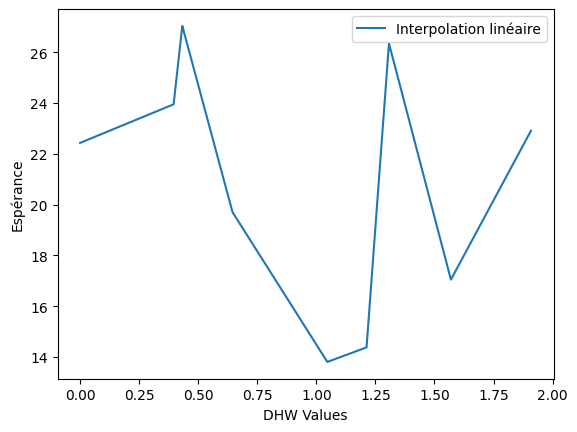

In [19]:
esperance, bins, var_bins = partition(10, 'dhw', 'recouvrement corr %', rec_ind_data)
esperance_interpol, var = interpol(esperance, var_bins)
# Tracé de l'interpolation linéaire
plt.plot(var, esperance_interpol, label='Interpolation linéaire')
plt.xlabel('DHW Values')
plt.ylabel('Espérance')
plt.legend()
plt.show()


In [20]:
def fct_interet(x, esperance_interpol, val_interpol):
    #### a partir d'une valeur prise par la variable explicative notée x, renvoie la valeur de la variable d'intérêt associée à la valeur explicative contenue dans val_interpol la plus proche de x

    #### cette fonction prend les variable suivantes en entrée :
    # x = valeur de la variable explicative
    # esperance_interpol =  espérance interpolée pour toutes les valeurs prises par la variable explicative
    # val_interpol = toutes les valeurs prises par la variable explicative

    #### et rend la variable suivante en sortie :
    # valeur de la variable d'intéret attendue pour une valeur de la variable explicative égale à x
    
    for i in range(len(val_interpol)):
        if val_interpol[i] > x:
            return(esperance_interpol[i - 1])
        elif x >= val_interpol[-1]:
            return(esperance_interpol[-1])
    return('erreur')

In [21]:
def sobol(n,data, expli,interet):
    #### Renvoie les indices de Sobol des variables expli pour la variable d'interêt

    #### cette fonction prend les variable suivantes en entrée :
    # n = nombre de bins désirées
    # data = dataframe contenant toutes les variables
    # expli = liste des noms des colonnes des variables explicatives dans data
    # interet = nom de la colonne de la variable cible dans data
    
    #### et rend la variable suivante en sortie :
    # ind = tableau avec les indices de Sobol des variable expli
    var_y = np.var(data[interet])
    N = data.shape[0]
    ind=[]
    for j in range(len(expli)):
        esp = 0
        esp2 = 0
        esperance,bins,var_bins = partition(n, expli[j], interet, data)
        for i in range(n-1):
            if bins[i]!=0:
                esp+=(bins[i]/N)*esperance[i]
                esp2+=(bins[i]/N)*(esperance[i]**2)
        ind.append((esp2-(esp**2))/var_y)
    return ind

[0.10391748114277204, 0.3572884828874829, 0.2694273147463983, 0.008776892931067209, 0.041284681918470345, 0.05032605706854563, 0.1473493499964821]


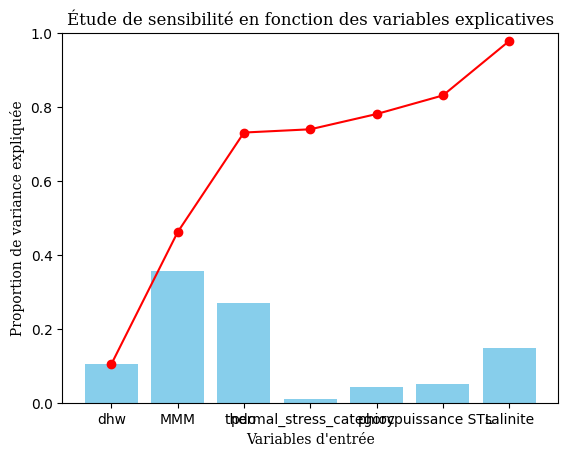

In [22]:
variables = ['dhw', 'MMM', 'pdo', 'thermal_stress_category','phioc','puissance STL','salinite']
interet = 'recouvrement corr %'
interet = 'v_der_rec'
plt.bar(variables, sobol(10, rec_ind_data_sal, variables, interet), color='skyblue')
plt.xlabel('Variables d\'entrée', fontfamily = 'serif')
plt.ylabel('Proportion de variance expliquée', fontfamily = 'serif')
plt.plot(variables, np.cumsum(sobol(10, rec_ind_data_sal, variables, interet)), color='r', marker='o', linestyle='-') 
print(sobol(10, rec_ind_data_sal, variables, interet))
plt.ylim(0,1)
plt.title('Étude de sensibilité en fonction des variables explicatives', fontfamily = 'serif')
plt.show()

In [23]:
# découpage chronologique qui ne fonctionne pas
train_chr = fill_houle[fill_houle['DateTime'] <= pd.to_datetime('2017-01-01')]
test_chr = fill_houle[fill_houle['DateTime'] >= pd.to_datetime('2017-01-01')]

# découpage aléatoire 
X_train, X_test, Y_train, Y_test = train_test_split(fill_houle[['DateTime','puissance','puissance f','puissance STL']], fill_houle[['DateTime','puissance','puissance f','puissance STL']], test_size=0.2, random_state=13)

def explained_var(data):
   #### Renvoie la variance expliquée par l'indicateur p

    #### cette fonction prend les variables suivantes en entrée :
    # data = la dataframe sur laquelle on étudie la variance expliquée
    
    #### et rend la variable suivante en sortie :
    # la variance du recouvrement expliquée par l'indicateur p
    return(sobol(10, data, ['indicateur p'], 'recouvrement corr %')) # recouvrement corr % ou v_dec_rec

def new_indic(temps,seuil,data):
   #### Renvoie la nouvelle Dataframe qui contient l'indicateur lié à la puissance

    #### cette fonction prend les variables suivantes en entrée :
    # temps = période sur laquelle on étudie la puissance
    # seuil = valeur à partir de laquelle on comptabilise 1 et plus 0 pour le jour considéré
    # data = la dataframe sur laquelle on étudie la variance expliquée
    
    #### et rend la variable suivante en sortie :
    # new_data = la nouvelle Dataframe qui contient l'indicateur lié à la puissance
    new_data = data.copy()
    new_data['indicateur p'] = 0
    N = new_data.shape[0]
    for i in range (temps,N):
        somme=0
        for j in range(temps):
            if new_data['puissance'].values[i-j]>seuil :
                somme+=1
        new_data['indicateur p'].values[i]=somme
    new_data = new_data[temps:]
    new_data = pd.merge(rec_ind_data, new_data, on = 'DateTime', how = 'inner')
    return (new_data)

def find_best_param(data):
   #### Renvoie le couple (temps,seuil) qui maximise la variance expliquée par l'indicateur de puissance

    #### cette fonction prend la variable suivante en entrée :
    # data = la dataframe sur laquelle on étudie la variance expliquée
    
    #### et rend la variable suivante en sortie :
    # le couple (temps,seuil) qui maximise la variance expliquée par l'indicateur de puissance

    #seuils = [-500,-100,-50,0,50,100,300] #seuils à utiliser pour la puissance STL
    seuils = [10000,12000,20000,25000,30000,35000] #seuils à utiliser pour la puissance seule
    temps = [7,10,20,30,35,45,60,90]
    scores =[]
    params = []
    for seuil in seuils :
        for temp in temps :
            new_data = new_indic(temp,seuil,data) 
            scores.append(explained_var(new_data))
            params.append([temp,seuil])
    return (params[np.argmax(scores)][0],params[np.argmax(scores)][1],scores[np.argmax(scores)])

In [24]:
#find_best_param(X_train) #pour trouver les meilleurs paramètres

In [25]:
explained_var(new_indic(20,10000,X_test))

[0.19153552515459366]

In [26]:
explained_var(new_indic(20,10000,fill_houle))

[0.014486333550340897]

In [27]:
rec_ind_data_sal['indicateur p rec sans filtre']=new_indic(20,10000,fill_houle)['indicateur p']
rec_ind_data_sal['indicateur p grad sans filtre']=new_indic(45,30000,fill_houle)['indicateur p']
rec_ind_data['indicateur p rec sans filtre']=new_indic(20,10000,fill_houle)['indicateur p']
rec_ind_data['indicateur p grad sans filtre']=new_indic(45,30000,fill_houle)['indicateur p']

[0.05499485663097803, 0.266766577111039, 0.11403574502847705, 0.014960486323620723, 0.025410303155013275, 0.014486333550340897]


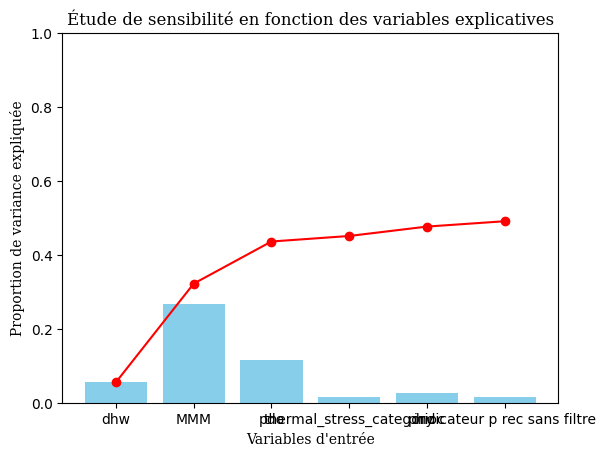

In [28]:
variables = ['dhw', 'MMM', 'pdo', 'thermal_stress_category','phioc','indicateur p rec sans filtre']
interet = 'recouvrement corr %'
plt.bar(variables, sobol(10, rec_ind_data, variables, interet), color='skyblue')
plt.xlabel('Variables d\'entrée', fontfamily = 'serif')
plt.ylabel('Proportion de variance expliquée', fontfamily = 'serif')
plt.plot(variables, np.cumsum(sobol(10, rec_ind_data, variables, interet)), color='r', marker='o', linestyle='-') 
print(sobol(10, rec_ind_data, variables, interet))
plt.ylim(0,1)
plt.title('Étude de sensibilité en fonction des variables explicatives', fontfamily = 'serif')
plt.show()

In [29]:
# Regression
def reg(n, data, expli, interet):
    #### Renvoie le recouvrement prédit à partir des indicateurs

    #### cette fonction prend les variables suivantes en entrée :
    # n = nombre de bins désirées
    # data = dataframe contenant toutes les variables
    # expli = liste des noms des colonnes des variables explicatives dans data
    # interet = nom de la colonne de la variable cible dans data
    
    #### et rend la variable suivante en sortie :
    # rec_pred = recouvrement prédit à partir des variables explicatives
    # rec_vrai = vrai recouvrement observé
    # rmse = racine de l'erreur quadratique moyenne
    # corr = coefficient de correlation
    # standard_dev = déviation standard 

    esperances = []
    val_interpol = []
    for i in range(len(expli)):
        esperance, bins, var_bins = partition(n, expli[i],interet, data)
        interpolation = interpol(esperance, var_bins)
        esperances.append(interpolation[0])
        val_interpol.append(interpolation[1])
    rec_pred = []
    rec_vrai = []
    for k in range(len(data)):
        somme = 0
        nb=0
        if not np.isnan(data[interet].loc[k]):
            for i in range(len(expli)):
                if fct_interet(data[expli[i]].loc[k], esperances[i], val_interpol[i]) == 'erreur':
                    print(k, i)
                somme += fct_interet(data[expli[i]].loc[k], esperances[i], val_interpol[i])
                nb+=1
            rec_pred.append(somme-(nb-1)* data[interet].mean())
            rec_vrai.append(data[interet].loc[k])
            
    rmse = np.sqrt(metrics.mean_squared_error(rec_vrai, rec_pred))
    corr = np.corrcoef(rec_vrai, rec_pred)[0, 1]
    standard_dev = np.std(np.array(rec_vrai) - np.array(rec_pred))
    return(rec_pred, rec_vrai, rmse, corr, standard_dev)

rmse 11.30940779345153 corrélation 0.5542226071205406 standard deviation 11.065428663388857


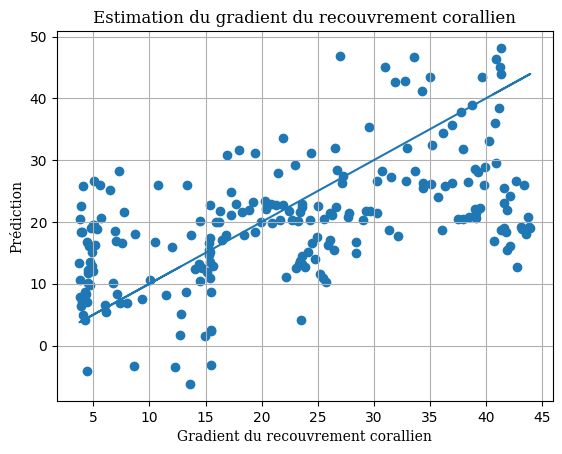

In [30]:
mort, vraie_mort, rmse, corr, standard_dev = reg(10, rec_ind_data_sal, ['dhw', 'MMM', 'pdo', 'thermal_stress_category','phioc','puissance STL','indicateur p rec sans filtre'], 'recouvrement corr %') #v_der_rec ou recouvrement corr % et indicateur p grad sans filtre ou indicateur p rec sans filtre
plt.scatter(vraie_mort, mort)
plt.plot(vraie_mort, vraie_mort)
plt.grid(True)
#plt.xlabel('Recouvrement corallien (%)', fontfamily = 'serif') #si recouvrement
plt.xlabel('Gradient du recouvrement corallien', fontfamily = 'serif') # si v_der_rec
#plt.ylabel('Prédiction (%)', fontfamily = 'serif') #si recouvrement
plt.ylabel('Prédiction', fontfamily = 'serif') #si v_der_rec
plt.title('Estimation du gradient du recouvrement corallien', fontfamily = 'serif')
#plt.title('Estimation du recouvrement corallien', fontfamily = 'serif') #si recouvrement
#plt.savefig('output/prédictions/Estimation du gradient de recouvrement AMP nord')
print('rmse', rmse, 'corrélation', corr, 'standard deviation', standard_dev)

In [31]:
def prediction(n, data_train, data_test, expli, interet):
    #### Renvoie le recouvrement prédit pour le data_test à partir des indicateurs du data_train

    #### cette fonction prend les variables suivantes en entrée :
    # n = nombre de bins désirées
    # data_train = dataframe contenant toutes les variables d'entrainement
    # data_test = dataframe contenant toutes les variables de test
    # expli = liste des noms des colonnes des variables explicatives dans data
    # interet = nom de la colonne de la variable cible dans data
    
    #### et rend la variable suivante en sortie :
    # rec_pred = recouvrement prédit à partir des variables explicatives sur la data_test
    # rmse = racine de l'erreur quadratique moyenne
    # corr = coefficient de correlation
    # standard_dev = déviation standard 
    esperances = []
    val_interpol = []
    for i in range(len(expli)):
        esperance, bins, var_bins = partition(n, expli[i],interet, data_train)
        interpolation = interpol(esperance, var_bins)
        esperances.append(interpolation[0])
        val_interpol.append(interpolation[1])
    rec_pred = []
    for k in range(len(data_test)):
        somme = 0
        nb=0
        if not np.isnan(data_test[interet].loc[k]):
            for i in range(len(expli)):
                if fct_interet(data_test[expli[i]].loc[k], esperances[i], val_interpol[i]) == 'erreur':
                    print(k, i)
                somme += fct_interet(data_test[expli[i]].loc[k], esperances[i], val_interpol[i])
                nb+=1
            rec_pred.append(somme-(nb-1)* data_train[interet].mean())
    rmse = np.sqrt(metrics.mean_squared_error(data_test[interet], rec_pred))
    corr = np.corrcoef(data_test[interet], rec_pred)[0, 1]
    standard_dev = np.std(np.array(data_test[interet]) - np.array(rec_pred))
    return(rec_pred,rmse,corr,standard_dev)

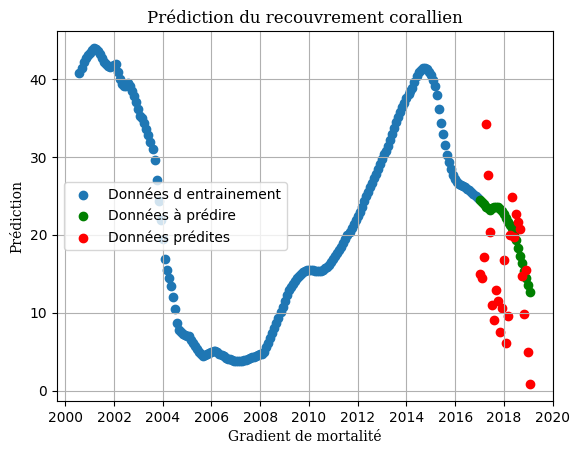

In [32]:
mort,rmse,corr,standard_dev= prediction(10, rec_ind_data_sal[rec_ind_data_sal['DateTime'].dt.year <= 2016], rec_ind_data_sal[rec_ind_data_sal['DateTime'].dt.year > 2016].reset_index(drop = True), ['dhw', 'MMM', 'pdo','phioc','indicateur p rec sans filtre','thermal_stress_category','salinite'], 'recouvrement corr %')
plt.scatter(rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['DateTime'], rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['recouvrement corr %'],label = 'Données d entrainement')
plt.scatter(rec_ind_data[rec_ind_data['DateTime'].dt.year > 2016]['DateTime'], rec_ind_data[rec_ind_data['DateTime'].dt.year > 2016]['recouvrement corr %'],label = 'Données à prédire',color ='g')
plt.scatter(rec_ind_data[rec_ind_data['DateTime'].dt.year > 2016]['DateTime'], mort, color = 'r', label = 'Données prédites')
#mort,rmse,corr,standard_dev= prediction(10, rec_ind_data_sal[rec_ind_data_sal['DateTime'].dt.year <= 2016], rec_ind_data_sal[rec_ind_data_sal['DateTime'].dt.year > 2016].reset_index(drop = True), ['dhw', 'MMM', 'pdo','phioc','indicateur p grad sans filtre','thermal_stress_category','salinite'], 'v_der_rec')
#plt.scatter(rec_ind_data_sal[rec_ind_data_sal['DateTime'].dt.year <= 2016]['DateTime'], rec_ind_data_sal[rec_ind_data_sal['DateTime'].dt.year <= 2016]['v_der_rec'],label = 'Données d entrainement')
#plt.scatter(rec_ind_data_sal[rec_ind_data_sal['DateTime'].dt.year > 2016]['DateTime'], rec_ind_data_sal[rec_ind_data_sal['DateTime'].dt.year > 2016]['v_der_rec'],label = 'Données à prédire',color ='g')
#plt.scatter(rec_ind_data_sal[rec_ind_data_sal['DateTime'].dt.year > 2016]['DateTime'], mort, color = 'r', label = 'Données prédites')
plt.grid(True)
plt.xlabel('Gradient de mortalité', fontfamily = 'serif')
plt.ylabel('Prédiction', fontfamily = 'serif')
plt.title('Prédiction du recouvrement corallien', fontfamily = 'serif')
#plt.title('Prédiction du gradient du recouvrement corallien', fontfamily = 'serif')
plt.legend()

# Exporter

In [33]:
rec_ind_data.to_csv('tensor flow envi/tensor_env/rec_ind_data.csv', index = False) #utilisé par le programme lstm rec

# Indépendance des indicateurs

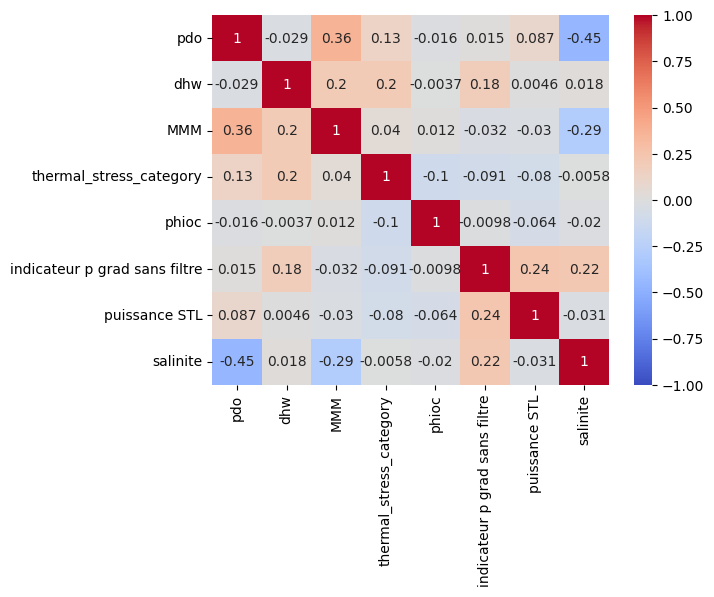

In [34]:
#correlation_matrix = rec_ind_data[['pdo', 'dhw', 'MMM', 'thermal_stress_category','phioc','indicateur p rec sans filtre','puissance STL','salinite']].corr(numeric_only=True) #si recouvrement
correlation_matrix = rec_ind_data_sal[['pdo', 'dhw', 'MMM', 'thermal_stress_category','phioc','indicateur p grad sans filtre','puissance STL','salinite']].corr(numeric_only=True) #si gradient
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

# Clustering

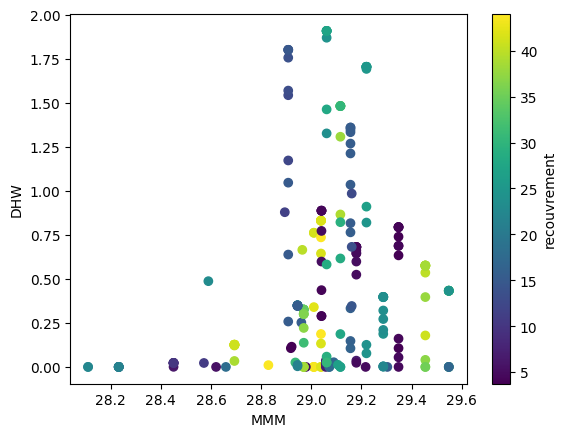

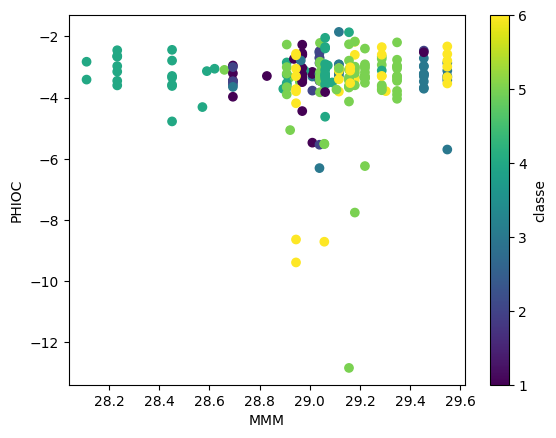

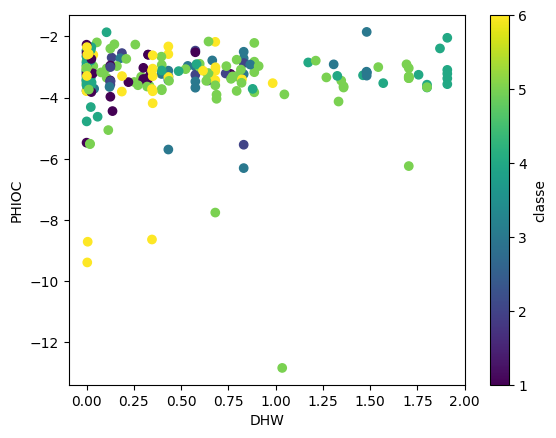

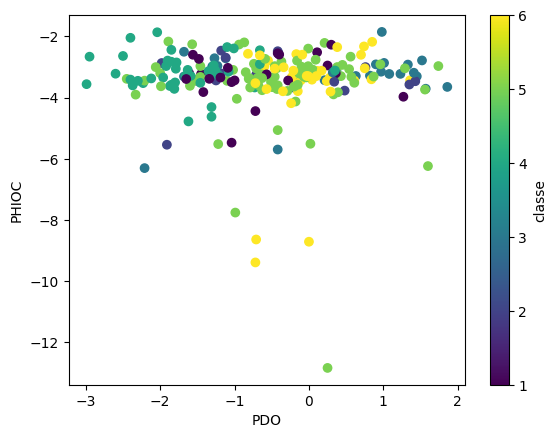

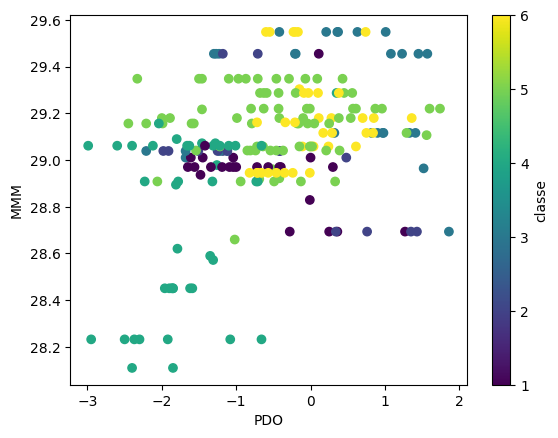

In [35]:
#On classe selon 6 catégories : si le gradient est négatif, presque nul ou positif, si le recouvrment est supérieur ou inférieur à la limite lim_r
lim_r=30
seuil_g = 0.01
rec_ind_data_sal['classe']=0
for i in range(rec_ind_data_sal.shape[0]):
    if rec_ind_data_sal['recouvrement corr %'].values[i]>lim_r:
        if rec_ind_data_sal['v_der_rec'].values[i]>seuil_g:
            rec_ind_data_sal['classe'].values[i]=1
        elif rec_ind_data_sal['v_der_rec'].values[i]<-seuil_g:
            rec_ind_data_sal['classe'].values[i]=3
        else :
            rec_ind_data_sal['classe'].values[i]=2

    else : 
        if rec_ind_data_sal['v_der_rec'].values[i]>seuil_g:
            rec_ind_data_sal['classe'].values[i]=4
        elif rec_ind_data_sal['v_der_rec'].values[i]<-seuil_g:
            rec_ind_data_sal['classe'].values[i]=6
        else :
            rec_ind_data_sal['classe'].values[i]=5


plt.scatter(rec_ind_data_sal['MMM'], rec_ind_data_sal['dhw'], c=rec_ind_data_sal['recouvrement corr %'])
plt.colorbar(label="recouvrement")
plt.xlabel("MMM")
plt.ylabel("DHW")
plt.plot()
plt.show()

plt.scatter(rec_ind_data_sal['MMM'], rec_ind_data_sal['phioc'], c=rec_ind_data_sal['classe'])
plt.colorbar(label="classe")
plt.xlabel("MMM")
plt.ylabel("PHIOC")
plt.plot()
plt.show()

plt.scatter(rec_ind_data_sal['dhw'], rec_ind_data_sal['phioc'], c=rec_ind_data_sal['classe'])
plt.colorbar(label="classe")
plt.xlabel("DHW")
plt.ylabel("PHIOC")
plt.plot()
plt.show()

plt.scatter(rec_ind_data_sal['pdo'], rec_ind_data_sal['phioc'], c=rec_ind_data_sal['classe'])
plt.colorbar(label="classe")
plt.xlabel("PDO")
plt.ylabel("PHIOC")
plt.plot()
plt.show()

plt.scatter(rec_ind_data_sal['pdo'], rec_ind_data_sal['MMM'], c=rec_ind_data_sal['classe'])
plt.colorbar(label="classe")
plt.xlabel("PDO")
plt.ylabel("MMM")
plt.plot()
plt.show()

In [36]:
#On classe selon 3 catégories
lim_r_sup=30
lim_r_inf=15
rec_ind_data_sal['classe3']=0
for i in range(rec_ind_data_sal.shape[0]):
    if rec_ind_data_sal['recouvrement corr %'].values[i]>lim_r_sup:
        rec_ind_data_sal['classe3'].values[i]=1
    elif rec_ind_data_sal['recouvrement corr %'].values[i]<lim_r_inf:
        rec_ind_data_sal['classe3'].values[i]=3
    else : 
        rec_ind_data_sal['classe3'].values[i]=2

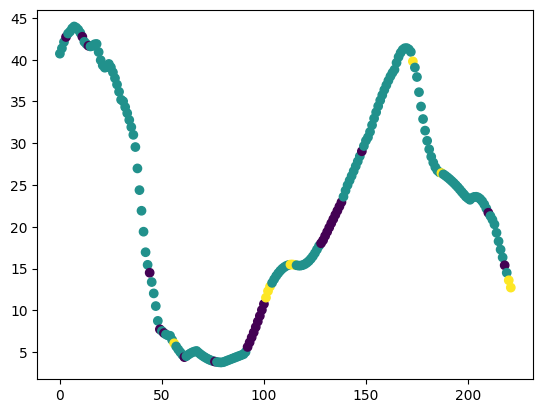

In [37]:
features = rec_ind_data_sal[['MMM','dhw','thermal_stress_category','pdo','puissance STL','phioc','indicateur p grad sans filtre','salinite']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
k_means=KMeans(n_clusters=3,init='k-means++',max_iter=300)
k_means.fit(scaled_features)
plt.scatter([k for k in range(rec_ind_data_sal.shape[0])],rec_ind_data_sal['recouvrement corr %'],c=k_means.labels_)

# PCA

[]

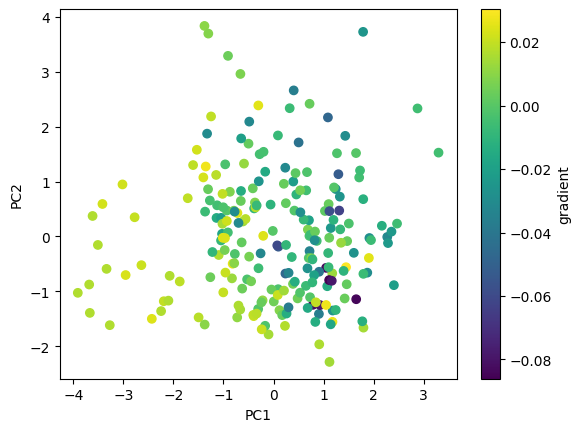

In [38]:
X_descri = rec_ind_data_sal[['MMM','dhw','thermal_stress_category','pdo','puissance STL','phioc','indicateur p grad sans filtre','salinite']]
std_scale = preprocessing.StandardScaler().fit(X_descri)
X_scaled = std_scale.transform(X_descri)

pca = decomposition.PCA(n_components=5)

pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)
recouvrement = rec_ind_data_sal['v_der_rec']
plt.scatter(X_projected[:,0], X_projected[:,1], c=recouvrement)
plt.colorbar(label="gradient")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.plot()

[]

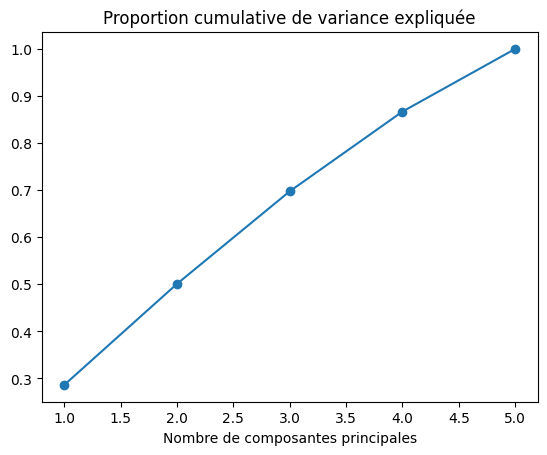

In [39]:
std_scale = preprocessing.StandardScaler().fit(X_descri)
X_scaled = std_scale.transform(X_descri)
pca = decomposition.PCA(n_components=5).fit_transform(X_scaled)
explained_variance = np.var(pca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
plt.plot(np.arange(1, 6), np.cumsum(explained_variance_ratio), marker='o')
plt.xlabel("Nombre de composantes principales")
plt.title("Proportion cumulative de variance expliquée")
plt.plot()

[]

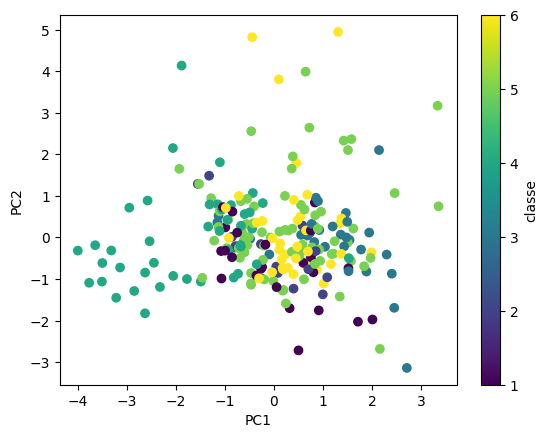

In [40]:
X_descri = rec_ind_data_sal[['MMM','dhw','thermal_stress_category','pdo','puissance STL','phioc','indicateur p rec sans filtre','salinite']]
std_scale = preprocessing.StandardScaler().fit(X_descri)
X_scaled = std_scale.transform(X_descri)

pca = decomposition.PCA(n_components=7)

pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)
classe = rec_ind_data_sal['classe']
plt.scatter(X_projected[:,0], X_projected[:,1], c=classe)
plt.colorbar(label="classe")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.plot()

[]

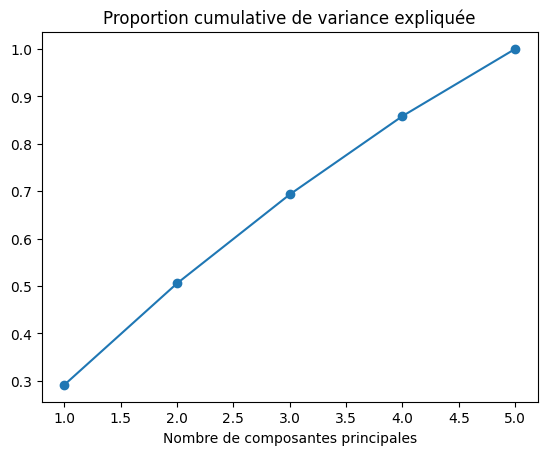

In [41]:
std_scale = preprocessing.StandardScaler().fit(X_descri)
X_scaled = std_scale.transform(X_descri)
pca = decomposition.PCA(n_components=5).fit_transform(X_scaled)
explained_variance = np.var(pca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
plt.plot(np.arange(1, 6), np.cumsum(explained_variance_ratio), marker='o')
plt.xlabel("Nombre de composantes principales")
plt.title("Proportion cumulative de variance expliquée")
plt.plot()

# Random forest

importances relatives des indicateurs : [0.21570016 0.08940985 0.5388146  0.00156519 0.03708258 0.07229096
 0.04513666]
r2 : -1.1637066022289888
rmse : 0.02109609676432252


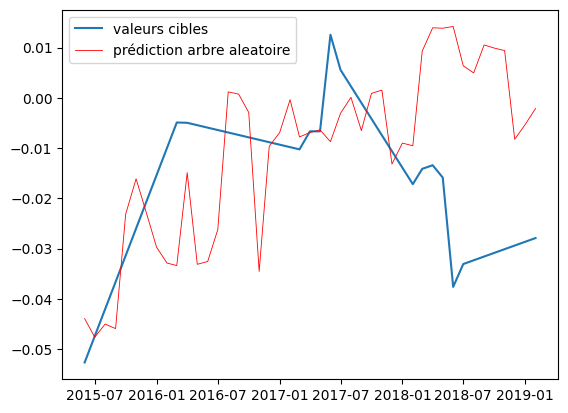

In [42]:
taille_tot = rec_ind_data.shape[0]
taille_train = int(taille_tot*0.8)

# Train
X_train = rec_ind_data[['pdo', 'dhw', 'MMM', 'thermal_stress_category','phioc','puissance STL','indicateur p grad sans filtre']].iloc[:taille_train] #si gradient
#X_train = rec_ind_data[['pdo', 'dhw', 'MMM', 'thermal_stress_category','phioc','puissance STL','indicateur p rec sans filtre']].iloc[:taille_train] #si recouvrement
Y_train = rec_ind_data['v_der_rec'].iloc[:taille_train] #si gradient
#Y_train = rec_ind_data['recouvrement corr %'].iloc[:taille_train] #si recouvrement

#Test
X_test =  rec_ind_data[['pdo', 'dhw', 'MMM', 'thermal_stress_category','phioc','puissance STL','indicateur p grad sans filtre']].iloc[taille_train:taille_tot] #si gradient
#X_test =  rec_ind_data[['pdo', 'dhw', 'MMM', 'thermal_stress_category','phioc','puissance STL','indicateur p rec sans filtre']].iloc[taille_train:taille_tot] #si recouvrement
model = ensemble.RandomForestRegressor()
model.fit(X_train, Y_train)
print("importances relatives des indicateurs :",model.feature_importances_)
#Prédiction
Y_test = model.predict(X_test)

# Afficher les résultats
print("r2 :", metrics.r2_score(np.array(rec_ind_data['v_der_rec'].iloc[taille_train:taille_tot]), Y_test))#si gradient
print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(rec_ind_data['v_der_rec'].iloc[taille_train:taille_tot]), Y_test)))#si gradient
plt.plot(rec_ind_data['DateTime'].iloc[taille_train:taille_tot],np.array(rec_ind_data['v_der_rec'].iloc[taille_train:taille_tot]), label = 'valeurs cibles')#si gradient
#print("r2 :", metrics.r2_score(np.array(rec_ind_data['recouvrement corr %'].iloc[taille_train:216]), Y_test))#si recouvrement
#print("rmse :", np.sqrt(metrics.mean_squared_error(np.array(rec_ind_data['recouvrement corr %'].iloc[taille_train:216]), Y_test)))#si recouvrement
#plt.plot(rec_ind_data['DateTime'].iloc[taille_train:216],np.array(rec_ind_data['v_recouvrement corr %der_rec'].iloc[taille_train:216]), label = 'valeurs cibles')#si recouvrement
plt.plot(rec_ind_data['DateTime'].iloc[taille_train:taille_tot], Y_test, color = 'r', linewidth = .6, label = 'prédiction arbre aleatoire')
plt.legend()

importances relatives des indicateurs : [0.13109075 0.1282017  0.65742659 0.03425786 0.01881674 0.03020635]
r2 : 0.8036906783276943
rmse : 6.581984207233284


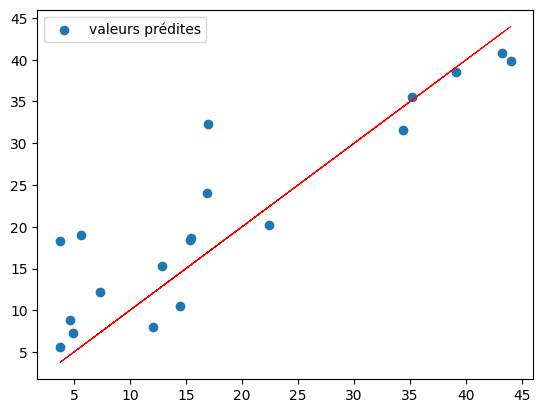

r2 : -5.348966545042318
rmse : 12.404840732874128


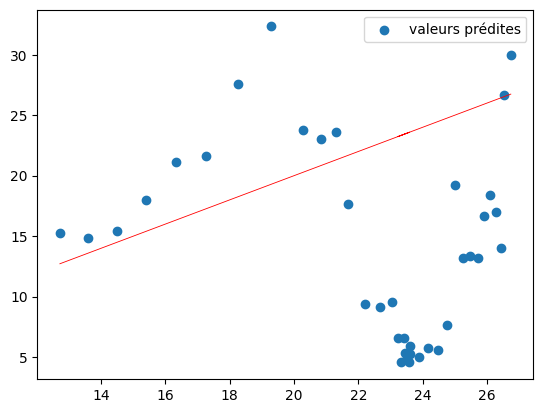

In [43]:
# Train
rec_ind_data_entrainement=rec_ind_data_sal[rec_ind_data_sal['DateTime']<pd.to_datetime('2016-01-01')]
rec_ind_data_test=rec_ind_data_sal[rec_ind_data_sal['DateTime']>pd.to_datetime('2016-01-01')]
X_train, X_test, Y_train, Y_test = train_test_split(rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']], rec_ind_data_entrainement['recouvrement corr %'], test_size=0.1, random_state=13) #si recouvrement
#X_train, X_test, Y_train, Y_test = train_test_split(rec_ind_data_entrainement[[ 'pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']], rec_ind_data_entrainement['v_der_rec'], test_size=0.1, random_state=13) #si gradient

# Test
model = ensemble.RandomForestRegressor()
model.fit(X_train, Y_train)
print("importances relatives des indicateurs :",model.feature_importances_)

#Prédiction
Y_pred = model.predict(X_test)

# Afficher les résultats sur la partie aléatoire
print("r2 :", metrics.explained_variance_score(Y_test, Y_pred))
print("rmse :", np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
plt.scatter(Y_test,Y_pred, label = 'valeurs prédites')
plt.plot(Y_test, Y_test, color = 'r', linewidth = .6)
plt.legend()
plt.show()

#Prédiction après
X_test_post=rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']] #si recouvrement
#X_test_post=rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']] #si gradient 
Y_pred_post = model.predict(X_test_post)

# Afficher les résultats
print("r2 :", metrics.explained_variance_score(rec_ind_data_test['recouvrement corr %'], Y_pred_post))#si recouvrement
print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['recouvrement corr %'], Y_pred_post)))#si recouvrement
plt.scatter(rec_ind_data_test['recouvrement corr %'],Y_pred_post, label = 'valeurs prédites')#si recouvrement
plt.plot(rec_ind_data_test['recouvrement corr %'], rec_ind_data_test['recouvrement corr %'], color = 'r', linewidth = .6)#si recouvrement
#print("r2 :", metrics.r2_score(rec_ind_data_test['v_der_rec'], Y_pred_post))#si gradient
#print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['v_der_rec'], Y_pred_post)))#si gradient
#plt.scatter(rec_ind_data_test['v_der_rec'],Y_pred_post, label = 'valeurs prédites')#si gradient
#plt.plot(rec_ind_data_test['v_der_rec'], rec_ind_data_test['v_der_rec'], color = 'r', linewidth = .6)#si gradient
plt.legend()
plt.show()

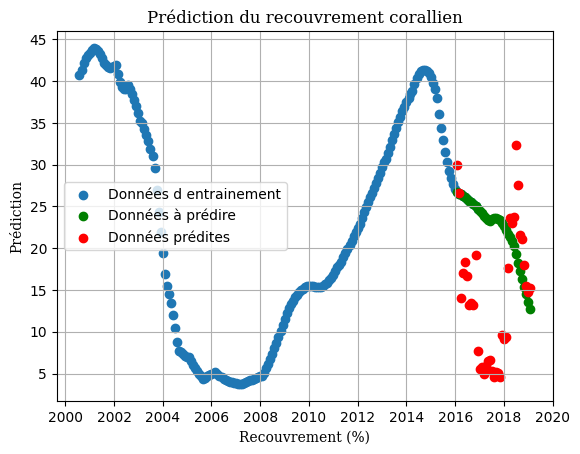

In [44]:
plt.scatter(rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['DateTime'], rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['recouvrement corr %'],label = 'Données d entrainement')#si recouvrement
plt.scatter(rec_ind_data[rec_ind_data['DateTime'] >  pd.to_datetime('2016-01-01')]['DateTime'], rec_ind_data[ rec_ind_data['DateTime'] > pd.to_datetime('2016-01-01')]['recouvrement corr %'],label = 'Données à prédire',color ='g')#si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['DateTime'], rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['v_der_rec'],label = 'Données d entrainement')#si grad
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'] >  pd.to_datetime('2016-01-01')]['DateTime'], rec_ind_data[ rec_ind_data['DateTime'] > pd.to_datetime('2016-01-01')]['v_der_rec'],label = 'Données à prédire',color ='g')#si grad
plt.scatter(rec_ind_data[rec_ind_data['DateTime']> pd.to_datetime('2016-01-01')]['DateTime'], Y_pred_post, color = 'r', label = 'Données prédites')
plt.grid(True)
plt.xlabel('Recouvrement (%)', fontfamily = 'serif') #si recouvrement
#plt.xlabel('Gradient de mortalité', fontfamily = 'serif')#si gradient
plt.ylabel('Prédiction', fontfamily = 'serif')
plt.title('Prédiction du recouvrement corallien', fontfamily = 'serif')#si recouvrement
#plt.title('Prédiction du gradient du recouvrement corallien', fontfamily = 'serif')#si gradient
plt.legend()

Affichage plus visuel

importances relatives des indicateurs : [0.29849684 0.06262275 0.44041491 0.05726438 0.04996122 0.0912399 ]
r2 : 0.49026069277768936
rmse : 0.014735550755537426


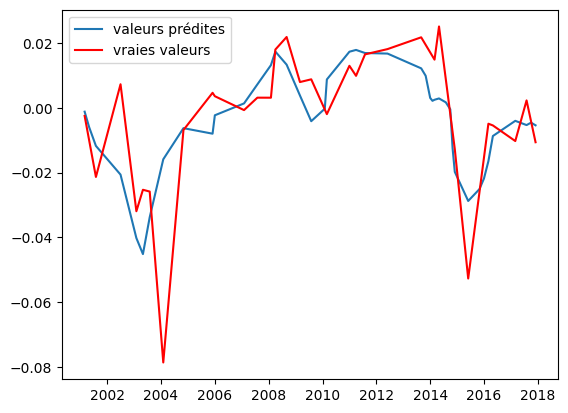

In [45]:
# Train
X_train, X_test, Y_train2, Y_test2 = train_test_split(rec_ind_data[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL']], rec_ind_data[['v_der_rec','DateTime']], test_size=0.2, random_state=13) #si grad
#X_train, X_test, Y_train2, Y_test2 = train_test_split(rec_ind_data[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']], rec_ind_data[['v_der_rec','DateTime']], test_size=0.2, random_state=13) #si recouvrement
Y_train =Y_train2['v_der_rec'] #si grad
Y_test = Y_test2['v_der_rec']#si grad
#Y_train =Y_train2['recouvrement corr %'] #si recouvrement
#Y_test = Y_test2['recouvrement corr %'] #si recouvrement

# Test
model = ensemble.RandomForestRegressor()
model.fit(X_train, Y_train)
print("importances relatives des indicateurs :",model.feature_importances_)
#Prédiction
Y_pred = model.predict(X_test)


predit = pd.DataFrame({'DateTime':Y_test2['DateTime'],'prediction':Y_pred,'vraie':Y_test})
predit.sort_values(by='DateTime',inplace=True)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
# Paramètres de la moyenne mobile à checker
window_size = 3

x = np.array(predit['prediction'])
x_smoothed = moving_average(x.squeeze(), window_size)
taille_smoothed = len(x)

# Afficher les résultats
print("r2 :", metrics.r2_score(Y_test, Y_pred))
print("rmse :", np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
plt.plot(predit['DateTime'][:taille_smoothed-window_size+1],x_smoothed, label = 'valeurs prédites')
plt.plot(predit['DateTime'][:taille_smoothed-window_size+1], predit['vraie'][:taille_smoothed-window_size+1], color = 'r', label ='vraies valeurs')
plt.legend()

# Gradient Boosting Regressor

importances relatives des indicateurs : [0.32676685 0.07075753 0.33868611 0.04818012 0.02954059 0.06307157
 0.12299723]
r2 : 0.4505997092527596
rmse : 0.014683227082373409


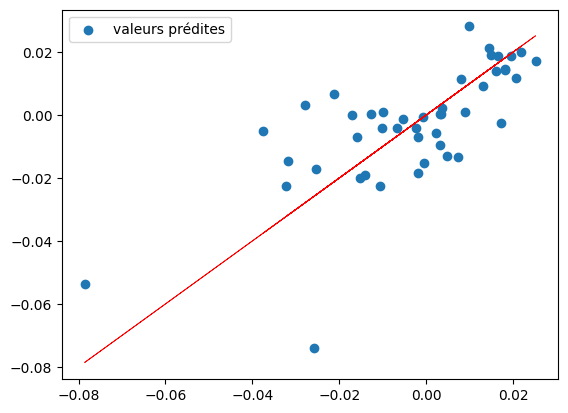

In [46]:
# Train
#X_train, X_test, Y_train, Y_test = train_test_split(rec_ind_data[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']], rec_ind_data['recouvrement corr %'], test_size=0.2, random_state=13) #si recouvrement
X_train, X_test, Y_train, Y_test = train_test_split(rec_ind_data_sal[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']], rec_ind_data_sal['v_der_rec'], test_size=0.2, random_state=13) #si gradient

# Test
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, Y_train)
print("importances relatives des indicateurs :",model.feature_importances_)
# Prédiction
Y_pred = model.predict(X_test)

# Afficher les résultats
print("r2 :", metrics.r2_score(Y_test, Y_pred))
print("rmse :", np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
plt.scatter(Y_test,Y_pred, label = 'valeurs prédites')
plt.plot(Y_test, Y_test, color = 'r', linewidth = .6)
plt.legend()

Affichage plus visuel

importances relatives des indicateurs : [0.07858024 0.1069241  0.74303056 0.03045058 0.01499478 0.02601975]
r2 : 0.8021188140898673
rmse : 5.7057606973031305


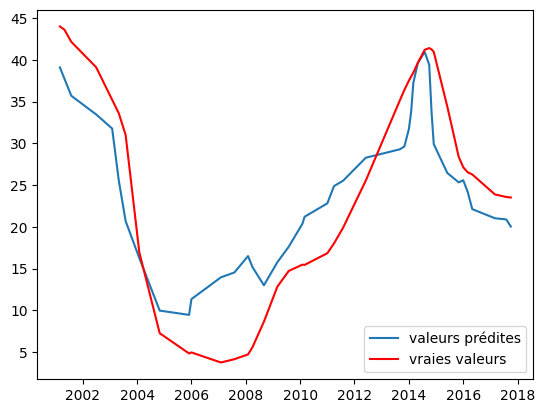

In [47]:
# Train
X_train, X_test, Y_train2, Y_test2 = train_test_split(rec_ind_data[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']], rec_ind_data[['recouvrement corr %','DateTime']], test_size=0.2, random_state=13) #si recouvrement
#X_train, X_test, Y_train2, Y_test2 = train_test_split(rec_ind_data[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL']], rec_ind_data[['v_der_rec','DateTime']], test_size=0.2, random_state=13) #si gradient
Y_train =Y_train2['recouvrement corr %']#si recouvrement
Y_test = Y_test2['recouvrement corr %']#si recouvrement
#Y_train =Y_train2['v_der_rec']#si gradient
#Y_test = Y_test2['v_ser_rec']#si gradient

# Test
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, Y_train)
print("importances relatives des indicateurs :",model.feature_importances_)

# Prédiction
Y_pred = model.predict(X_test)

predit = pd.DataFrame({'DateTime':Y_test2['DateTime'],'prediction':Y_pred,'vraie':Y_test})
predit.sort_values(by='DateTime',inplace=True)

# Paramètres de la moyenne mobile
window_size = 4
x = np.array(predit['prediction'])
x_smoothed = moving_average(x.squeeze(), window_size)
taille_smoothed = len(x)

# Afficher les résultats
print("r2 :", metrics.r2_score(Y_test, Y_pred))
print("rmse :", np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
plt.plot(predit['DateTime'][:taille_smoothed-window_size+1],x_smoothed, label = 'valeurs prédites')
plt.plot(predit['DateTime'][:taille_smoothed-window_size+1], predit['vraie'][:taille_smoothed-window_size+1], color = 'r', label ='vraies valeurs')
plt.legend()

importances relatives des indicateurs : [0.1302597  0.06917979 0.75590644 0.02148156 0.00740058 0.01577193]
r2 : 0.7973165699028285
rmse : 6.060603250530323


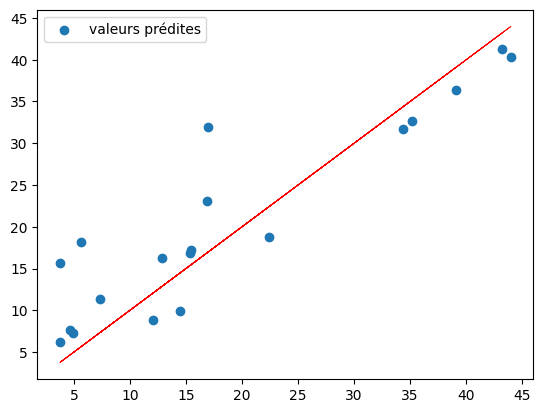

r2 : -12.151159604385443
rmse : 13.782340951349783


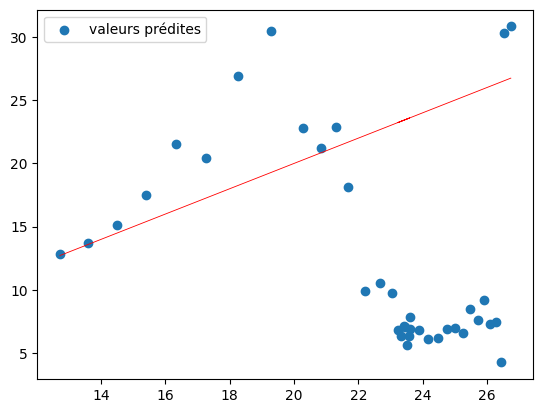

In [48]:
# Train
rec_ind_data_entrainement=rec_ind_data_sal[rec_ind_data_sal['DateTime']<pd.to_datetime('2016-01-01')]
rec_ind_data_test=rec_ind_data_sal[rec_ind_data_sal['DateTime']>pd.to_datetime('2016-01-01')]
X_train, X_test, Y_train, Y_test = train_test_split(rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']], rec_ind_data_entrainement['recouvrement corr %'], test_size=0.1, random_state=13) #si recouvrement
#X_train, X_test, Y_train, Y_test = train_test_split(rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']], rec_ind_data_entrainement['v_der_rec'], test_size=0.1, random_state=13) #si gradient

# Test
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, Y_train)
print("importances relatives des indicateurs :",model.feature_importances_)

# Prédiction sur échantillon aléatoire
Y_pred = model.predict(X_test)

# Afficher les résultats
print("r2 :", metrics.r2_score(Y_test, Y_pred))
print("rmse :", np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
plt.scatter(Y_test,Y_pred, label = 'valeurs prédites')
plt.plot(Y_test, Y_test, color = 'r', linewidth = .6)
plt.legend()
plt.show()

# Prédiction après
X_test_post=rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']]# si recouvrement 
#X_test_post=rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']]# si gradient
Y_pred_post = model.predict(X_test_post)

# Afficher les résultats
print("r2 :", metrics.r2_score(rec_ind_data_test['recouvrement corr %'], Y_pred_post))# si recouvrement 
print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['recouvrement corr %'], Y_pred_post)))# si recouvrement 
plt.scatter(rec_ind_data_test['recouvrement corr %'],Y_pred_post, label = 'valeurs prédites')# si recouvrement 
plt.plot(rec_ind_data_test['recouvrement corr %'], rec_ind_data_test['recouvrement corr %'], color = 'r', linewidth = .6)# si recouvrement 
#print("r2 :", metrics.r2_score(rec_ind_data_test['v_der_rec'], Y_pred_post))# si gradient
#print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['v_der_rec'], Y_pred_post)))# si gradient
#plt.scatter(rec_ind_data_test['v_der_rec'],Y_pred_post, label = 'valeurs prédites')# si gradient
#plt.plot(rec_ind_data_test['v_der_rec'], rec_ind_data_test['v_der_rec'], color = 'r', linewidth = .6)# si gradient
plt.legend()
plt.show()

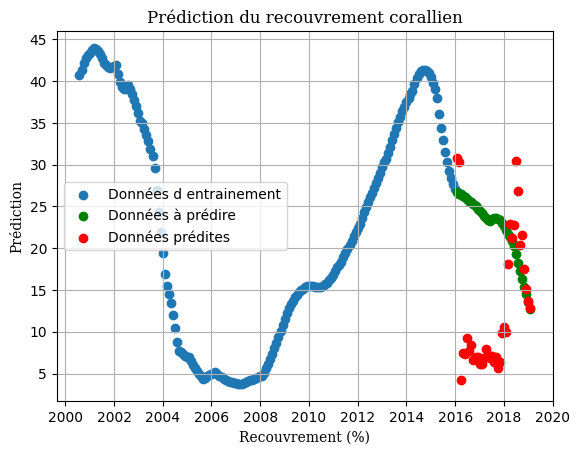

In [49]:
plt.scatter(rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['DateTime'], rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['recouvrement corr %'],label = 'Données d entrainement')# si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['DateTime'], rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['v_der_rec'],label = 'Données d entrainement')# si gradient
plt.scatter(rec_ind_data[rec_ind_data['DateTime'] >  pd.to_datetime('2016-01-01')]['DateTime'], rec_ind_data[ rec_ind_data['DateTime'] > pd.to_datetime('2016-01-01')]['recouvrement corr %'],label = 'Données à prédire',color ='g')# si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'] >  pd.to_datetime('2016-01-01')]['DateTime'], rec_ind_data[ rec_ind_data['DateTime'] > pd.to_datetime('2016-01-01')]['v_der_rec'],label = 'Données à prédire',color ='g')# si gradient
plt.scatter(rec_ind_data[rec_ind_data['DateTime']> pd.to_datetime('2016-01-01')]['DateTime'], Y_pred_post, color = 'r', label = 'Données prédites')
plt.grid(True)
plt.xlabel('Recouvrement (%)', fontfamily = 'serif')#si recouvremnt
#plt.xlabel('Gradient de mortalité', fontfamily = 'serif')#si gradient
plt.ylabel('Prédiction', fontfamily = 'serif')
plt.title('Prédiction du recouvrement corallien', fontfamily = 'serif')#si recouvrement
#plt.title('Prédiction du gradient du recouvrement corallien', fontfamily = 'serif')#si gradient
plt.legend()

r2 : -7.4883977024937955
rmse : 13.84951254476946


C:\Users\julie\AppData\Local\Temp\ipykernel_183840\3076013645.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rec_ind_data_entrainement=pd.concat([rec_ind_data_sal[rec_ind_data_sal['DateTime']<=pd.to_datetime('2015-01-01')],rec_ind_data_sal[rec_ind_data['DateTime']>=pd.to_datetime('2018-01-01')]])


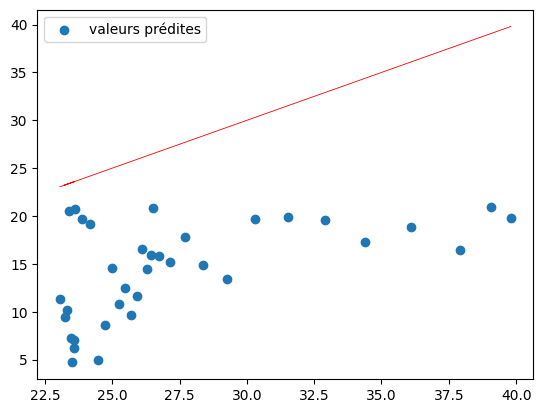

In [50]:
# Train
#rec_ind_data_entrainement=pd.concat([rec_ind_data[rec_ind_data['DateTime']<pd.to_datetime('2012-01-01')],rec_ind_data[rec_ind_data['DateTime']>pd.to_datetime('2015-01-01')]])
#rec_ind_data_test=rec_ind_data[(rec_ind_data['DateTime']>pd.to_datetime('2012-01-01'))&(rec_ind_data['DateTime']<pd.to_datetime('2015-01-01'))]
rec_ind_data_entrainement=pd.concat([rec_ind_data_sal[rec_ind_data_sal['DateTime']<=pd.to_datetime('2015-01-01')],rec_ind_data_sal[rec_ind_data['DateTime']>=pd.to_datetime('2018-01-01')]])
rec_ind_data_test=rec_ind_data_sal[(rec_ind_data_sal['DateTime']>pd.to_datetime('2015-01-01'))&(rec_ind_data_sal['DateTime']<pd.to_datetime('2018-01-01'))]
X_train, Y_train = rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL','salinite']], rec_ind_data_entrainement['recouvrement corr %'] #si recouvrement
#X_train, X_test, Y_train, Y_test = train_test_split(rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL']], rec_ind_data_entrainement['v_der_rec'], test_size=0.1, random_state=13) #si gradient

# Test
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, Y_train)

# Prédiction après
X_test_post=rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL','salinite']]# si recouvrement 
#X_test_post=rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL']]# si gradient
Y_pred_post = model.predict(X_test_post)

# Afficher les résultats
print("r2 :", metrics.r2_score(rec_ind_data_test['recouvrement corr %'], Y_pred_post))# si recouvrement 
print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['recouvrement corr %'], Y_pred_post)))# si recouvrement 
plt.scatter(rec_ind_data_test['recouvrement corr %'],Y_pred_post, label = 'valeurs prédites')# si recouvrement 
plt.plot(rec_ind_data_test['recouvrement corr %'], rec_ind_data_test['recouvrement corr %'], color = 'r', linewidth = .6)# si recouvrement 
#print("r2 :", metrics.r2_score(rec_ind_data_test['v_der_rec'], Y_pred_post))# si gradient
#print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['v_der_rec'], Y_pred_post)))# si gradient
#plt.scatter(rec_ind_data_test['v_der_rec'],Y_pred_post, label = 'valeurs prédites')# si gradient
#plt.plot(rec_ind_data_test['v_der_rec'], rec_ind_data_test['v_der_rec'], color = 'r', linewidth = .6)# si gradient
plt.legend()
plt.show()

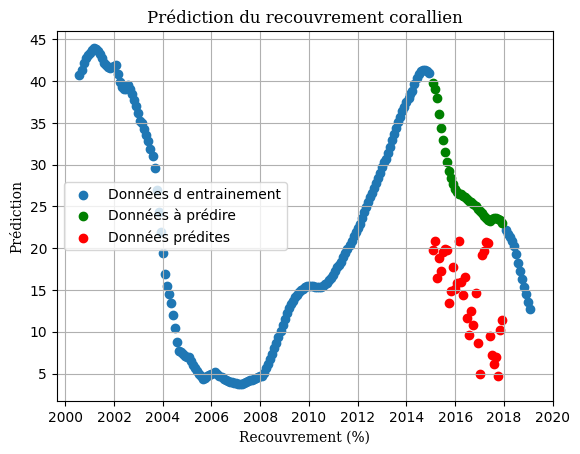

In [51]:
plt.scatter(rec_ind_data_entrainement['DateTime'], rec_ind_data_entrainement['recouvrement corr %'],label = 'Données d entrainement')# si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['DateTime'], rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['v_der_rec'],label = 'Données d entrainement')# si gradient
plt.scatter(rec_ind_data_test['DateTime'], rec_ind_data_test['recouvrement corr %'],label = 'Données à prédire',color ='g')# si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'] >  pd.to_datetime('2016-01-01')]['DateTime'], rec_ind_data[ rec_ind_data['DateTime'] > pd.to_datetime('2016-01-01')]['v_der_rec'],label = 'Données à prédire',color ='g')# si gradient
plt.scatter(rec_ind_data_test['DateTime'], Y_pred_post, color = 'r', label = 'Données prédites')
plt.grid(True)
plt.xlabel('Recouvrement (%)', fontfamily = 'serif')#si recouvremnt
#plt.xlabel('Gradient de mortalité', fontfamily = 'serif')#si gradient
plt.ylabel('Prédiction', fontfamily = 'serif')
plt.title('Prédiction du recouvrement corallien', fontfamily = 'serif')#si recouvrement
#plt.title('Prédiction du gradient du recouvrement corallien', fontfamily = 'serif')#si gradient
plt.legend()

r2 : 0.8005466686459451
rmse : 5.728381693518756


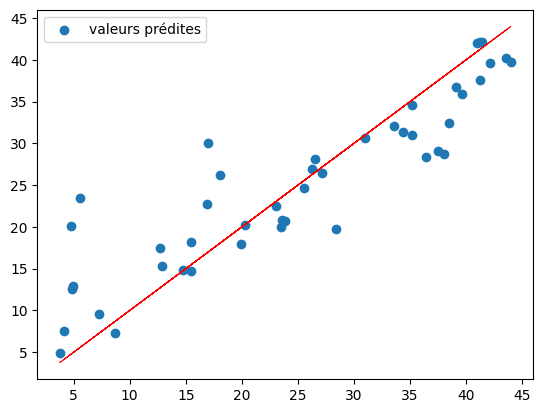

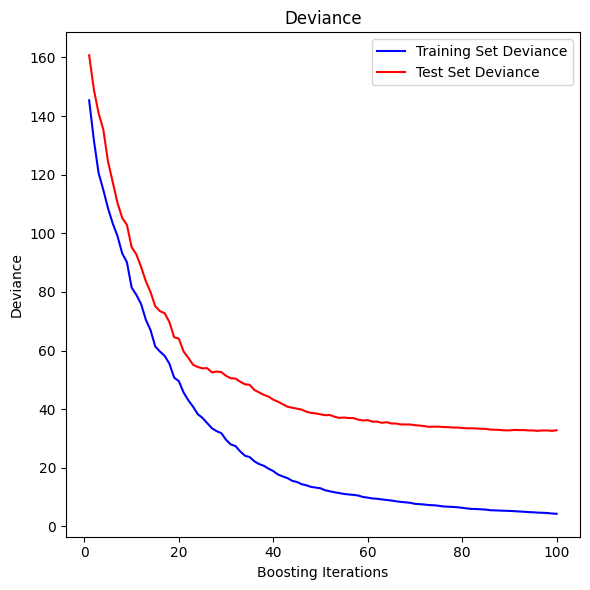

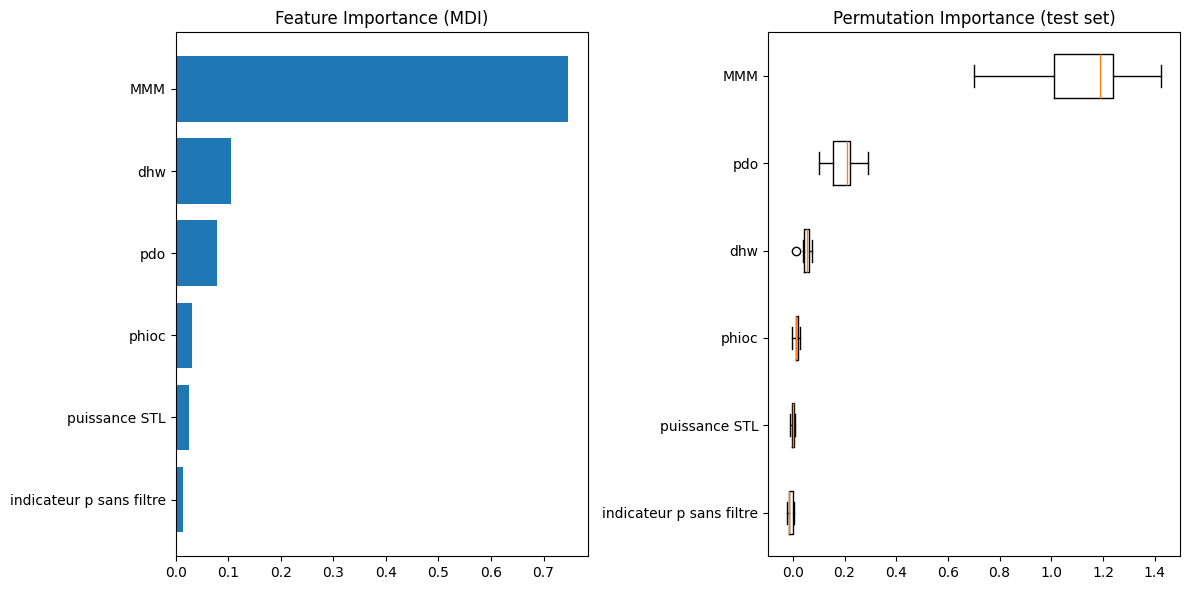

In [52]:
# Train
X_train, X_test, Y_train, Y_test = train_test_split(rec_ind_data[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']], rec_ind_data['recouvrement corr %'], test_size=0.2, random_state=13) # si recouvrement
#X_train, X_test, Y_train, Y_test = train_test_split(rec_ind_data[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL']], rec_ind_data['recouvrement corr %'], test_size=0.2, random_state=13) # si gradient
params = {
    "n_estimators": 100,
    "max_depth": 3,
    "min_samples_split": 2,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

# Test
model = ensemble.GradientBoostingRegressor(**params)
model.fit(X_train, Y_train)

# Prédiction
Y_pred = model.predict(X_test)
mse = metrics.mean_squared_error(Y_test, Y_pred)

# Afficher les résultats
print("r2 :", metrics.r2_score(Y_test, Y_pred))
print("rmse :", np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
plt.scatter(Y_test,Y_pred, label = 'valeurs prédites')
plt.plot(Y_test, Y_test, color = 'r', linewidth = .6)
plt.legend()
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = metrics. mean_squared_error(Y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    model.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(['pdo', 'dhw', 'MMM','phioc','indicateur p sans filtre','puissance STL'])[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    model, X_test, Y_test, n_repeats=10, random_state=8, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    tick_labels=np.array(['pdo', 'dhw', 'MMM','phioc','indicateur p sans filtre','puissance STL'])[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Bloquer variation du recouvrement : seuillage

r2 : -6.664222221753886
rmse : 16.47616617694786


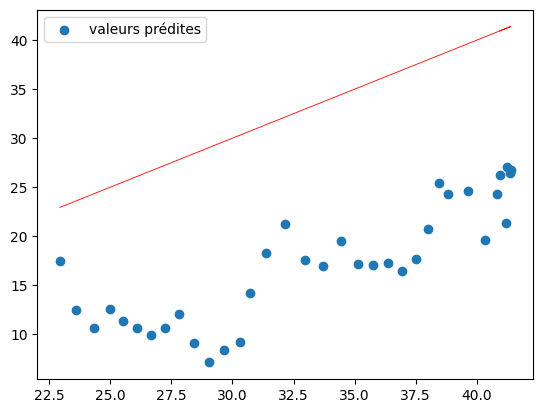

In [53]:
# Train
#rec_ind_data_entrainement=pd.concat([rec_ind_data[rec_ind_data['DateTime']<=pd.to_datetime('2015-01-01')],rec_ind_data[rec_ind_data['DateTime']>=pd.to_datetime('2018-01-01')]])
#rec_ind_data_entrainement=rec_ind_data[rec_ind_data['DateTime']<=pd.to_datetime('2015-01-01')]
#rec_ind_data_test=rec_ind_data[(rec_ind_data['DateTime']>pd.to_datetime('2015-01-01'))&(rec_ind_data['DateTime']<pd.to_datetime('2018-01-01'))]
#rec_ind_data_entrainement=rec_ind_data[rec_ind_data['DateTime']>=pd.to_datetime('2003-01-01')]
#rec_ind_data_test=rec_ind_data[(rec_ind_data['DateTime']<pd.to_datetime('2003-01-01'))]
rec_ind_data_entrainement=pd.concat([rec_ind_data_sal[rec_ind_data_sal['DateTime']<=pd.to_datetime('2012-01-01')],rec_ind_data_sal[rec_ind_data_sal['DateTime']>=pd.to_datetime('2015-01-01')]])
rec_ind_data_test=rec_ind_data_sal[(rec_ind_data_sal['DateTime']>pd.to_datetime('2012-01-01'))&(rec_ind_data_sal['DateTime']<pd.to_datetime('2015-01-01'))]
#rec_ind_data_entrainement=rec_ind_data[rec_ind_data['DateTime']<pd.to_datetime('2016-01-01')]
#rec_ind_data_test=rec_ind_data[rec_ind_data['DateTime']>pd.to_datetime('2016-01-01')]
X_train, Y_train= rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL','salinite']], rec_ind_data_entrainement['recouvrement corr %'] #si recouvrement
#X_train, Y_train = rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL']], rec_ind_data_entrainement['v_der_rec'] #si gradient
# Test
model = ensemble.GradientBoostingRegressor()
model.fit(X_train.values, Y_train.values)

# Prédiction 
X_test_post=rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL','salinite']]# si recouvrement 
#X_test_post=rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL']]# si gradient
longueur_test = rec_ind_data_test.shape[0]
longueur_train = len(Y_train)
predictions = []
"""delta1=rec_ind_data_entrainement[rec_ind_data_entrainement['DateTime']<= pd.to_datetime('2006-01-01')]['recouvrement corr %'].diff()
max_1=max(delta1.max(),-delta1.min())
delta2=rec_ind_data_entrainement[(rec_ind_data_entrainement['DateTime']>= pd.to_datetime('2011-01-01'))&(rec_ind_data_entrainement['DateTime']<= pd.to_datetime('2015-01-01'))]['recouvrement corr %'].diff()
max_2=max(delta2.max(),-delta2.min())
delta3=rec_ind_data_entrainement[(rec_ind_data_entrainement['DateTime']>= pd.to_datetime('2018-01-01'))]['recouvrement corr %'].diff()
max_3=max(delta3.max(),-delta3.min())
delta_max = max(max_1,max(max_3,max_2))
delta1=rec_ind_data_entrainement[rec_ind_data_entrainement['DateTime']<= pd.to_datetime('2015-01-01')]['recouvrement corr %'].diff()
max_1=max(delta1.max(),-delta1.min())
delta3=rec_ind_data_entrainement[(rec_ind_data_entrainement['DateTime']>= pd.to_datetime('2018-01-01'))]['recouvrement corr %'].diff()
max_3=max(delta3.max(),-delta3.min())
delta_max=max(max_1,max_3)"""
delta_max=5
def concatene(Y_train,predi):
  if predi.ndim == 0 :
    return np.concatenate((Y_train,[predi]))
  if predi.ndim == 1 :
    return np.concatenate((Y_train,predi))
  else :
    print('erreur')

def ajoute(L,predi):
  if predi.ndim == 0 :
    L.append(predi)
    return L
  if predi.ndim == 1 :
    L.append(predi[0])
    return L
  else :
    print('erreur')

v_deb = rec_ind_data_entrainement[rec_ind_data_entrainement['DateTime']==pd.to_datetime('2012-01-01')]
v_deb=v_deb['recouvrement corr %'].values[0]
for i in range (longueur_test):
  #model.fit(X_train, Y_train) # pour prendre en compte les variations apportées ou non
  Y_pred_post = model.predict([X_test_post.iloc[i]])
  if i==0:
    if v_deb-Y_pred_post>delta_max :
      Y_pred_post=v_deb-delta_max
      indi = np.array(([X_test_post.iloc[i]]))
      X_train=np.concatenate((X_train,indi))
      predi = np.array((Y_pred_post))
      Y_train = concatene(Y_train,predi)
    if v_deb-Y_pred_post<-delta_max : 
      Y_pred_post=v_deb+delta_max
      indi = np.array(([X_test_post.iloc[i]]))
      X_train=np.concatenate((X_train,indi))
      predi = np.array((Y_pred_post))
      Y_train = concatene(Y_train,predi)

  if i >0:
    if predictions[i-1]-Y_pred_post>delta_max :
      Y_pred_post=predictions[i-1]-delta_max
      indi = np.array(([X_test_post.iloc[i]]))
      X_train=np.concatenate((X_train,indi))
      predi = np.array((Y_pred_post))
      Y_train = concatene(Y_train,predi)
    if predictions[i-1]-Y_pred_post<-delta_max : 
      Y_pred_post=predictions[i-1]+delta_max
      indi = np.array(([X_test_post.iloc[i]]))
      X_train = np.concatenate((X_train,indi))
      predi = np.array(Y_pred_post)
      Y_train = concatene(Y_train,predi)
     
  predictions = ajoute(predictions,Y_pred_post)

# Afficher les résultats
print("r2 :", metrics.r2_score(rec_ind_data_test['recouvrement corr %'], predictions))# si recouvrement 
print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['recouvrement corr %'], predictions)))# si recouvrement 
plt.scatter(rec_ind_data_test['recouvrement corr %'],predictions, label = 'valeurs prédites')# si recouvrement 
plt.plot(rec_ind_data_test['recouvrement corr %'], rec_ind_data_test['recouvrement corr %'], color = 'r', linewidth = .6)# si recouvrement 
#print("r2 :", metrics.r2_score(rec_ind_data_test['v_der_rec'], predictions))# si gradient
#print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['v_der_rec'], predictions)))# si gradient
#plt.scatter(rec_ind_data_test['v_der_rec'],predictions, label = 'valeurs prédites')# si gradient
#plt.plot(rec_ind_data_test['v_der_rec'], rec_ind_data_test['v_der_rec'], color = 'r', linewidth = .6)# si gradient
plt.legend()
plt.show()

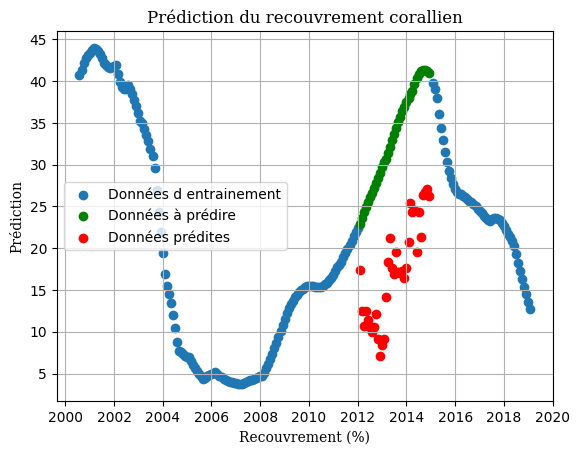

In [54]:
plt.scatter(rec_ind_data_entrainement['DateTime'], rec_ind_data_entrainement['recouvrement corr %'],label = 'Données d entrainement')# si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['DateTime'], rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['v_der_rec'],label = 'Données d entrainement')# si gradient
plt.scatter(rec_ind_data_test['DateTime'], rec_ind_data_test['recouvrement corr %'],label = 'Données à prédire',color ='g')# si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'] >  pd.to_datetime('2016-01-01')]['DateTime'], rec_ind_data[ rec_ind_data['DateTime'] > pd.to_datetime('2016-01-01')]['v_der_rec'],label = 'Données à prédire',color ='g')# si gradient
plt.scatter(rec_ind_data_test['DateTime'], predictions, color = 'r', label = 'Données prédites')
plt.grid(True)
plt.xlabel('Recouvrement (%)', fontfamily = 'serif')#si recouvremnt
#plt.xlabel('Gradient de mortalité', fontfamily = 'serif')#si gradient
plt.ylabel('Prédiction', fontfamily = 'serif')
plt.title('Prédiction du recouvrement corallien', fontfamily = 'serif')#si recouvrement
#plt.title('Prédiction du gradient du recouvrement corallien', fontfamily = 'serif')#si gradient
plt.legend()

test sens variation

In [55]:
def confusion_matrix_cr(pred,true):
        #### Matrice de confusion baisse et augmentation

    #### cette fonction prend les variables suivantes en entrée :
    # pred = numpy array contenant les prédictions du modèle
    # true = dataframe contenant les vraies valeurs de recouvrement
    
    #### et rend les variables suivantes en sortie :
    # vraie_croissance = nombre de fois où la prédiction annonce une hausse du recouvrement et qu'elle se réalise
    # vraie_baisse = nombre de fois où la prédiction annonce une baisse du recouvrement et qu'elle se réalise
    # fausse_croissance = nombre de fois où la prédiction annonce une hausse du recouvrement et qu'elle ne se réalise pas
    # fausse_baisse = nombre de fois où la prédiction annonce une baisse du recouvrement et qu'elle ne se réalise pas
    # accuracy = la précision du modèle
    vraie_croissance = 0
    vraie_baisse = 0
    fausse_croissance = 0
    fausse_baisse = 0
    N=len(pred)
    for i in range(N-1):
        if true.values[i+1]-true.values[i]>0:
            if (pred[i+1]-pred[i])>0:
                vraie_croissance+=1
            else :
                fausse_baisse+=1
        else :
            if (pred[i+1]-pred[i])>0:
                fausse_croissance+=1
            else :
                vraie_baisse+=1
    accuracy =(vraie_croissance+vraie_baisse)/(N-1)
    print("vraie croissance :",vraie_croissance)
    print("vraie baisse :",vraie_baisse)
    print("fausse croissance :",fausse_croissance)
    print("fausse baisee :",fausse_baisse)

confusion_matrix_cr(predictions,rec_ind_data_test['recouvrement corr %'])

vraie croissance : 17
vraie baisse : 1
fausse croissance : 1
fausse baisee : 15


# Bloquer variation du recouvrement : mise à l'échelle

r2 : -6.62443569056185
rmse : 16.43334497196765


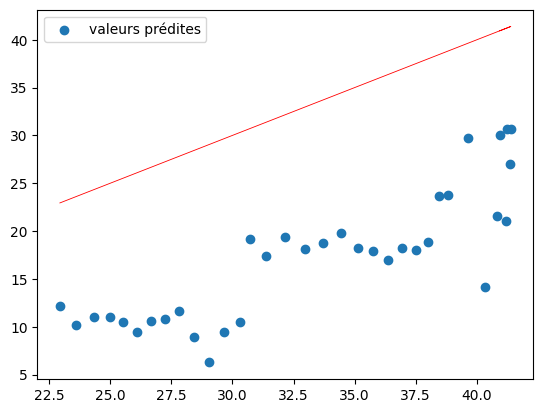

In [56]:
# Train
rec_ind_data_entrainement=pd.concat([rec_ind_data[rec_ind_data['DateTime']<=pd.to_datetime('2012-01-01')],rec_ind_data[rec_ind_data['DateTime']>=pd.to_datetime('2015-01-01')]])
rec_ind_data_test=rec_ind_data[(rec_ind_data['DateTime']>pd.to_datetime('2012-01-01'))&(rec_ind_data['DateTime']<pd.to_datetime('2015-01-01'))]
#rec_ind_data_entrainement=pd.concat([rec_ind_data[rec_ind_data['DateTime']<=pd.to_datetime('2015-01-01')],rec_ind_data[rec_ind_data['DateTime']>=pd.to_datetime('2018-01-01')]])
#rec_ind_data_test=rec_ind_data[(rec_ind_data['DateTime']>pd.to_datetime('2015-01-01'))&(rec_ind_data['DateTime']<pd.to_datetime('2018-01-01'))]
X_train, Y_train = rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']], rec_ind_data_entrainement['recouvrement corr %'] #si recouvrement
#X_train, X_test, Y_train, Y_test = train_test_split(rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL']], rec_ind_data_entrainement['v_der_rec'], test_size=0.1, random_state=13) #si gradient


# Test
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, Y_train)

# Prédiction après
X_test_post=rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']]# si recouvrement 
#X_test_post=rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL']]# si gradient
Y_pred_post = model.predict(X_test_post)

# Afficher les résultats
print("r2 :", metrics.r2_score(rec_ind_data_test['recouvrement corr %'], Y_pred_post))# si recouvrement 
print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['recouvrement corr %'], Y_pred_post)))# si recouvrement 
plt.scatter(rec_ind_data_test['recouvrement corr %'],Y_pred_post, label = 'valeurs prédites')# si recouvrement 
plt.plot(rec_ind_data_test['recouvrement corr %'], rec_ind_data_test['recouvrement corr %'], color = 'r', linewidth = .6)# si recouvrement 
#print("r2 :", metrics.r2_score(rec_ind_data_test['v_der_rec'], Y_pred_post))# si gradient
#print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['v_der_rec'], Y_pred_post)))# si gradient
#plt.scatter(rec_ind_data_test['v_der_rec'],Y_pred_post, label = 'valeurs prédites')# si gradient
#plt.plot(rec_ind_data_test['v_der_rec'], rec_ind_data_test['v_der_rec'], color = 'r', linewidth = .6)# si gradient
plt.legend()
plt.show()

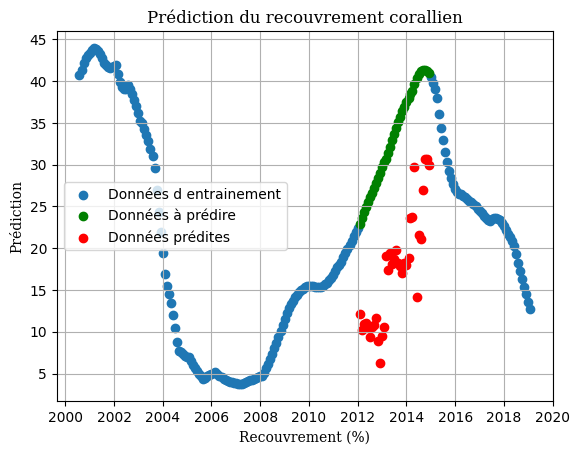

In [57]:
plt.scatter(rec_ind_data_entrainement['DateTime'], rec_ind_data_entrainement['recouvrement corr %'],label = 'Données d entrainement')# si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['DateTime'], rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['v_der_rec'],label = 'Données d entrainement')# si gradient
plt.scatter(rec_ind_data_test['DateTime'], rec_ind_data_test['recouvrement corr %'],label = 'Données à prédire',color ='g')# si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'] >  pd.to_datetime('2016-01-01')]['DateTime'], rec_ind_data[ rec_ind_data['DateTime'] > pd.to_datetime('2016-01-01')]['v_der_rec'],label = 'Données à prédire',color ='g')# si gradient
plt.scatter(rec_ind_data_test['DateTime'], Y_pred_post, color = 'r', label = 'Données prédites')
plt.grid(True)
plt.xlabel('Recouvrement (%)', fontfamily = 'serif')#si recouvremnt
#plt.xlabel('Gradient de mortalité', fontfamily = 'serif')#si gradient
plt.ylabel('Prédiction', fontfamily = 'serif')
plt.title('Prédiction du recouvrement corallien', fontfamily = 'serif')#si recouvrement
#plt.title('Prédiction du gradient du recouvrement corallien', fontfamily = 'serif')#si gradient
plt.legend()

r2 : -6.1134619359420155
rmse : 15.87313190693694


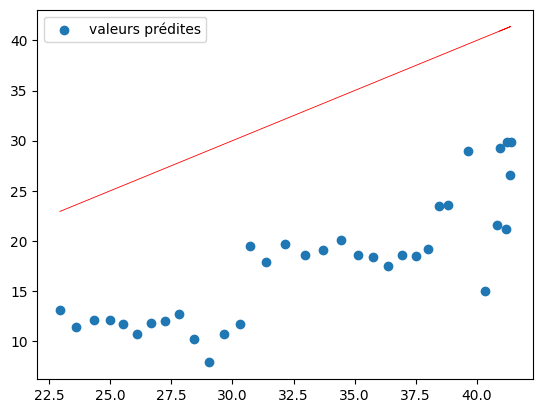

In [58]:
#Remise à l'échelle
longueur_test=len(Y_pred_post)
diff =[]
v_deb = rec_ind_data_entrainement[rec_ind_data_entrainement['DateTime']==pd.to_datetime('2012-01-01')]
v_deb=v_deb['recouvrement corr %'].values[0]
param_echelle=0.9 # A faire varier
diff.append((Y_pred_post[0]-v_deb)*param_echelle)
for i in range(longueur_test-1):
    diff.append((Y_pred_post[i+1]-Y_pred_post[i])*param_echelle)

Y_pred_post_new=[]
Y_pred_post_new.append(v_deb+diff[0])
for i in range(longueur_test-1):
    Y_pred_post_new.append(Y_pred_post_new[i]+diff[i+1])

# Afficher les résultats
print("r2 :", metrics.r2_score(rec_ind_data_test['recouvrement corr %'], Y_pred_post_new))# si recouvrement 
print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['recouvrement corr %'], Y_pred_post_new)))# si recouvrement 
plt.scatter(rec_ind_data_test['recouvrement corr %'],Y_pred_post_new, label = 'valeurs prédites')# si recouvrement 
plt.plot(rec_ind_data_test['recouvrement corr %'], rec_ind_data_test['recouvrement corr %'], color = 'r', linewidth = .6)# si recouvrement 
#print("r2 :", metrics.r2_score(rec_ind_data_test['v_der_rec'], Y_pred_post))# si gradient
#print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['v_der_rec'], Y_pred_post)))# si gradient
#plt.scatter(rec_ind_data_test['v_der_rec'],Y_pred_post, label = 'valeurs prédites')# si gradient
#plt.plot(rec_ind_data_test['v_der_rec'], rec_ind_data_test['v_der_rec'], color = 'r', linewidth = .6)# si gradient
plt.legend()
plt.show()

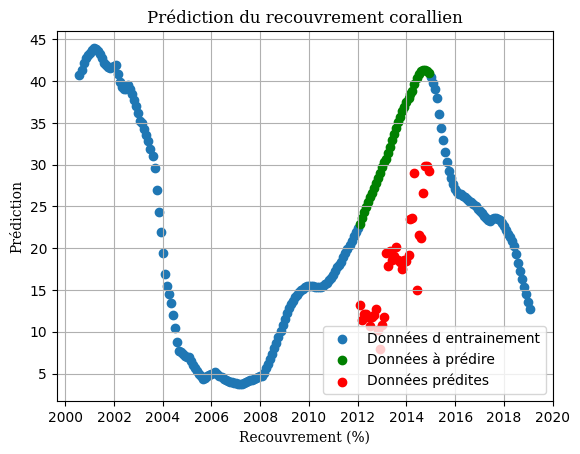

In [59]:
plt.scatter(rec_ind_data_entrainement['DateTime'], rec_ind_data_entrainement['recouvrement corr %'],label = 'Données d entrainement')# si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['DateTime'], rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['v_der_rec'],label = 'Données d entrainement')# si gradient
plt.scatter(rec_ind_data_test['DateTime'], rec_ind_data_test['recouvrement corr %'],label = 'Données à prédire',color ='g')# si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'] >  pd.to_datetime('2016-01-01')]['DateTime'], rec_ind_data[ rec_ind_data['DateTime'] > pd.to_datetime('2016-01-01')]['v_der_rec'],label = 'Données à prédire',color ='g')# si gradient
plt.scatter(rec_ind_data_test['DateTime'], Y_pred_post_new, color = 'r', label = 'Données prédites')
plt.grid(True)
plt.xlabel('Recouvrement (%)', fontfamily = 'serif')#si recouvremnt
#plt.xlabel('Gradient de mortalité', fontfamily = 'serif')#si gradient
plt.ylabel('Prédiction', fontfamily = 'serif')
plt.title('Prédiction du recouvrement corallien', fontfamily = 'serif')#si recouvrement
#plt.title('Prédiction du gradient du recouvrement corallien', fontfamily = 'serif')#si gradient
plt.legend()

r2 : 0.03274286954872552
rmse : 5.853196298575109


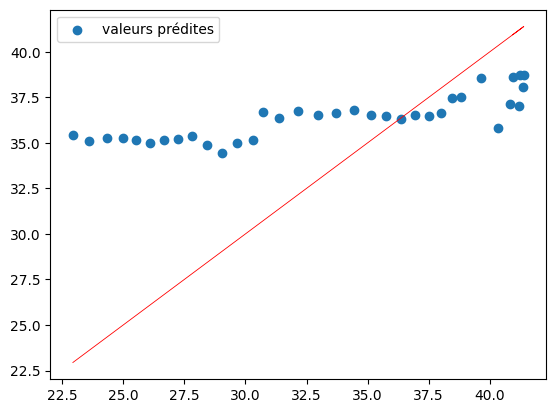

In [60]:
#Remise à l'échelle par max
longueur_test=len(Y_pred_post)
diff =[]
v_deb = rec_ind_data_entrainement[rec_ind_data_entrainement['DateTime']==pd.to_datetime('2015-01-01')]
v_deb=v_deb['recouvrement corr %'].values[0]
max = np.abs(Y_pred_post[0]-v_deb)
diff.append(Y_pred_post[0]-v_deb)
for i in range(longueur_test-1):
    diff.append(Y_pred_post[i+1]-Y_pred_post[i])
    if np.abs(Y_pred_post[i+1]-Y_pred_post[i])>max:
        max = np.abs(Y_pred_post[i+1]-Y_pred_post[i])

ratio = max/delta_max
Y_pred_post_new=[]
Y_pred_post_new.append(v_deb+(diff[0]/ratio))
for i in range(longueur_test-1):
    Y_pred_post_new.append(Y_pred_post_new[i]+(diff[i+1]/ratio))

# Afficher les résultats
print("r2 :", metrics.r2_score(rec_ind_data_test['recouvrement corr %'], Y_pred_post_new))# si recouvrement 
print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['recouvrement corr %'], Y_pred_post_new)))# si recouvrement 
plt.scatter(rec_ind_data_test['recouvrement corr %'],Y_pred_post_new, label = 'valeurs prédites')# si recouvrement 
plt.plot(rec_ind_data_test['recouvrement corr %'], rec_ind_data_test['recouvrement corr %'], color = 'r', linewidth = .6)# si recouvrement 
#print("r2 :", metrics.r2_score(rec_ind_data_test['v_der_rec'], Y_pred_post))# si gradient
#print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['v_der_rec'], Y_pred_post)))# si gradient
#plt.scatter(rec_ind_data_test['v_der_rec'],Y_pred_post, label = 'valeurs prédites')# si gradient
#plt.plot(rec_ind_data_test['v_der_rec'], rec_ind_data_test['v_der_rec'], color = 'r', linewidth = .6)# si gradient
plt.legend()
plt.show()

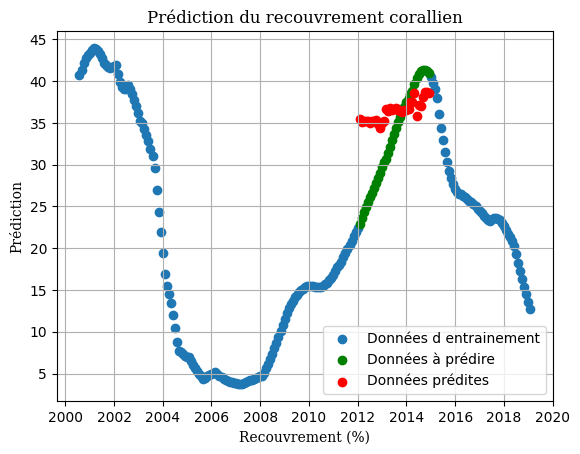

In [61]:
plt.scatter(rec_ind_data_entrainement['DateTime'], rec_ind_data_entrainement['recouvrement corr %'],label = 'Données d entrainement')# si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['DateTime'], rec_ind_data[rec_ind_data['DateTime'].dt.year <= 2016]['v_der_rec'],label = 'Données d entrainement')# si gradient
plt.scatter(rec_ind_data_test['DateTime'], rec_ind_data_test['recouvrement corr %'],label = 'Données à prédire',color ='g')# si recouvrement
#plt.scatter(rec_ind_data[rec_ind_data['DateTime'] >  pd.to_datetime('2016-01-01')]['DateTime'], rec_ind_data[ rec_ind_data['DateTime'] > pd.to_datetime('2016-01-01')]['v_der_rec'],label = 'Données à prédire',color ='g')# si gradient
plt.scatter(rec_ind_data_test['DateTime'], Y_pred_post_new, color = 'r', label = 'Données prédites')
plt.grid(True)
plt.xlabel('Recouvrement (%)', fontfamily = 'serif')#si recouvremnt
#plt.xlabel('Gradient de mortalité', fontfamily = 'serif')#si gradient
plt.ylabel('Prédiction', fontfamily = 'serif')
plt.title('Prédiction du recouvrement corallien', fontfamily = 'serif')#si recouvrement
#plt.title('Prédiction du gradient du recouvrement corallien', fontfamily = 'serif')#si gradient
plt.legend()

# Logarithme du recouvrement

r2 : -38.93038973232704
rmse : 1.0012519264383006


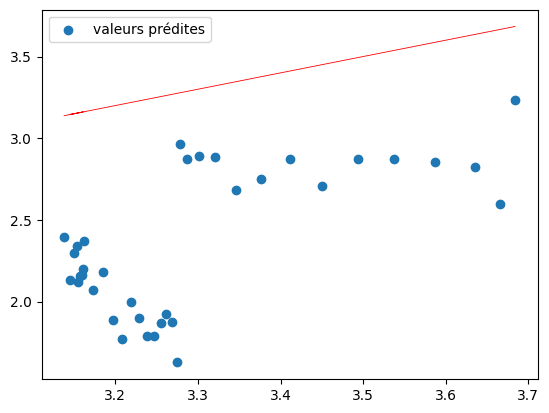

In [62]:
# Train
rec_ind_data['log_rec']=0.
for i in range(rec_ind_data.shape[0]):
    rec_ind_data['log_rec'].values[i]=np.log(rec_ind_data['recouvrement corr %'].values[i])

rec_ind_data_entrainement=pd.concat([rec_ind_data[rec_ind_data['DateTime']<=pd.to_datetime('2015-01-01')],rec_ind_data[rec_ind_data['DateTime']>=pd.to_datetime('2018-01-01')]])
rec_ind_data_test=rec_ind_data[(rec_ind_data['DateTime']>pd.to_datetime('2015-01-01'))&(rec_ind_data['DateTime']<pd.to_datetime('2018-01-01'))]
X_train, Y_train = rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']], rec_ind_data_entrainement['log_rec']

# Test
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, Y_train)

# Prédiction après
X_test_post=rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']]# si recouvrement
Y_pred_post = model.predict(X_test_post)

# Afficher les résultats
print("r2 :", metrics.r2_score(rec_ind_data_test['log_rec'], Y_pred_post))# si recouvrement 
print("rmse :", np.sqrt(metrics.mean_squared_error(rec_ind_data_test['log_rec'], Y_pred_post)))# si recouvrement 
plt.scatter(rec_ind_data_test['log_rec'],Y_pred_post, label = 'valeurs prédites')# si recouvrement 
plt.plot(rec_ind_data_test['log_rec'], rec_ind_data_test['log_rec'], color = 'r', linewidth = .6)# si recouvrement 
plt.legend()
plt.show()

# LSTM (voir fichier lstm rec)

# Autre jeu de données

In [63]:
def ajoute_val_prec(colonnes,data,n):
    #### ajoute des nouvelles colonnes à la dataframe, contenant les 'n' valeurs précédentes issues de la liste 'colonnes'

    #### cette fonction prend les variable suivantes en entrée :
    # n = nombre de valeurs précédentes à mettre dans le liste
    # data = dataframe contenant toutes les variables
    # colonne = nom de la colonne dans la datframe
    
    #### et rend la variable suivante en sortie :
    # data_n = l'ancienne dataframe à laquelle on a ajouté la nouvelle colonne
    N = data.shape[0]
    data_n=data.copy()
    data_n = data_n[n:]
    for colonne in colonnes : 
        b_liste=[]
        for i in range(n,N) :
            liste = []
            for k in range(n,0,-1):
                liste.append(data[colonne].values[i-k])
            b_liste.append(liste)
        data_n['liste de '+colonne]=b_liste
    return (data_n)

def flatten_list(nested_list): 
    #### concaténation d'une liste contenant des tableau numpy et des élements seuls

    #### cette fonction prend la variable suivante en entrée :
    # nested_list = liste à concatener
    
    #### et rend les variables suivantes en sortie :
    # flattened = liste concaténée

    flattened = [] 
    for item in nested_list: 
        if isinstance(item, np.ndarray): # Vérifie si l'élément est un array
            flattened.extend(item) # Ajoute tous les éléments de la sous-liste à la liste aplatie 
        else: 
            flattened.append(item) # Ajoute l'élément seul à la liste aplatie 
    return flattened

def forme_donnees_entree(n,interet):
    #### met les données d'entrée dans le bon format pour être utilisées par le gradient boost regressor

    #### cette fonction prend les variables suivantes en entrée :
    # n = nombre de valeurs précédentes à mettre dans le liste
    # interet = nom de la colonne que l'on cherche à prédire dans la dataframe
    
    #### et rend les variables suivantes en sortie :
    # L = liste contenant les listes de données nécessaires au modèle, avec un recul de n jours
    # y = liste des valeurs à prédire

    new_data = ajoute_val_prec(['MMM','dhw','thermal_stress_category','phioc','puissance','puissance STL'],av_pdo,n)
    new_data = pd.merge(new_data,rec_ind_data_sal)
    y = new_data[interet]
    x_gr  = []
    if interet == 'v_der_rec':
        cate = ['pdo', 'liste de dhw', 'liste de MMM','liste de phioc','indicateur p grad sans filtre','liste de puissance STL']
    if interet =='recouvrement corr %':
        cate = ['pdo', 'liste de dhw', 'liste de MMM','liste de phioc','indicateur p rec sans filtre','liste de puissance STL']
    else :
        cate = ['pdo', 'liste de dhw', 'liste de MMM','liste de phioc','indicateur p rec sans filtre','liste de puissance STL','salinite']
    for i in range (new_data.shape[0]):
        li = [(np.array(new_data[colonne].values[i])).flatten() for colonne in cate]
        li = flatten_list(li)
        x_gr.append(li)
    return(x_gr,y)

# Test des algos sur ce jeu de données 

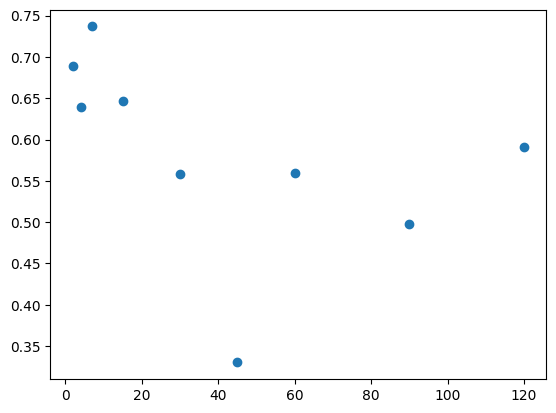

In [64]:
liste_nb_jours=[2,4,7,15,30,45,60,90,120] # liste avec les périodes à tester
scores_corr =[] #scores obtenus pour ces périodes
for nb_jours in liste_nb_jours:
    x_gr,y=forme_donnees_entree(nb_jours,'recouvrement corr %')
    # Train
    X_train, X_test, Y_train, Y_test = train_test_split(x_gr, y, test_size=0.2, random_state=13)

    # Test
    model = ensemble.GradientBoostingRegressor()
    model.fit(X_train, Y_train)

    # Prédiction
    Y_pred = model.predict(X_test)

    # Resultat
    scores_corr.append(metrics.r2_score(Y_test, Y_pred))

plt.scatter(liste_nb_jours,scores_corr)

# Exporter pour lstm

In [65]:
new_data = ajoute_val_prec(['MMM','dhw','thermal_stress_category','phioc','puissance','puissance STL'],av_pdo,30)
new_data = pd.merge(new_data,rec_ind_data)
new_data.to_csv('tensor flow envi/tensor_env/plusieurs_jours_n.csv', index = False)

In [66]:
data_x,data_y=forme_donnees_entree(30,'recouvrement corr %') # données sur le mois
data_x=pd.Series(data_x)
data_y=pd.Series(data_y)
data_lstm=pd.concat([data_x,data_y],axis=1)
data_lstm.to_csv('tensor flow envi/tensor_env/plusieurs_jours.csv', index = False)

# ARIMA 

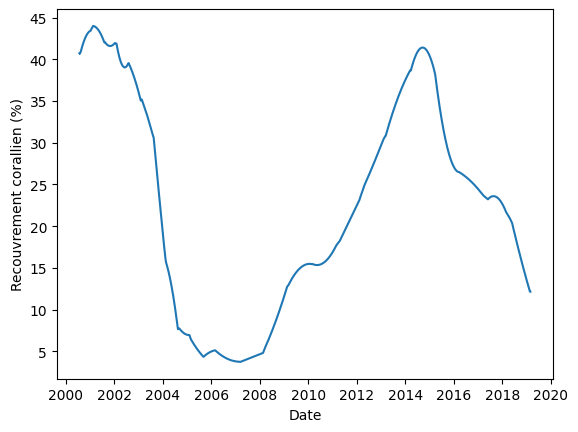

In [67]:
df = av_pdo[['DateTime','recouvrement corr %']]
plt.xlabel('Date')
plt.ylabel('Recouvrement corallien (%)')
plt.plot(df['DateTime'],df['recouvrement corr %'])

In [68]:
def test_statio(timeseries, periode):
        ####  détermine si une série temporelle donnée est stationnaire

    #### cette fonction prend la variable suivante en entrée :
    # timeseries = la série temporelle à étudier
    # periode = le nombre de valeurs à prendre en compte dans la moyenne glissante 
    
    #### et en sortie :
    # Trace la moyenne mobile et l’écart-type mobile. La série temporelle est stationnaire si elle reste constante dans le temps
    # Effecture le test de Dickey Fuller augmenté :  si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF, la série est stationnaire

    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=periode).mean()
    rolling_std = timeseries.rolling(window=periode).std()
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='black', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    result = adfuller(timeseries['recouvrement corr %'])
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [69]:
def test_statio_sst(timeseries, periode):
        ####  détermine si une série temporelle donnée est stationnaire

    #### cette fonction prend la variable suivante en entrée :
    # timeseries = la série temporelle à étudier
    # periode = le nombre de valeurs à prendre en compte dans la moyenne glissante 
    
    #### et en sortie :
    # Trace la moyenne mobile et l’écart-type mobile. La série temporelle est stationnaire si elle reste constante dans le temps
    # Effecture le test de Dickey Fuller augmenté :  si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF, la série est stationnaire

    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=periode).mean()
    rolling_std = timeseries.rolling(window=periode).std()
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='black', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    result = adfuller(timeseries['Temperature'])
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

original


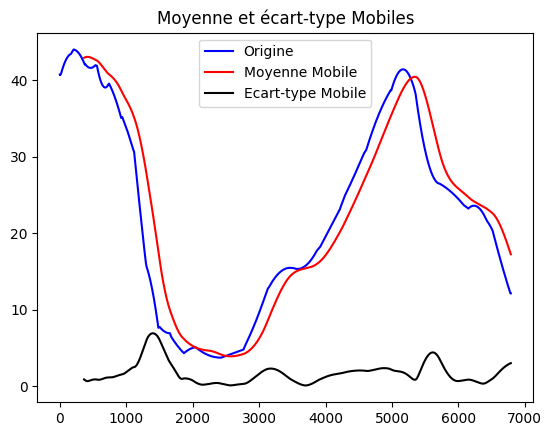

Statistiques ADF : -2.4837640205098364
p-value : 0.11947485579190054
Valeurs Critiques :
	1%: -3.431317576468945
	5%: -2.861967588687274
	10%: -2.566997601755818
log


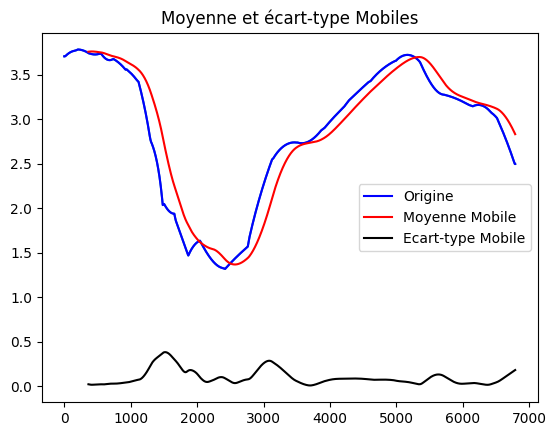

Statistiques ADF : -1.871156570120223
p-value : 0.3457492170123334
Valeurs Critiques :
	1%: -3.431317004144342
	5%: -2.8619673358083286
	10%: -2.5669974671434477
moins moyenne


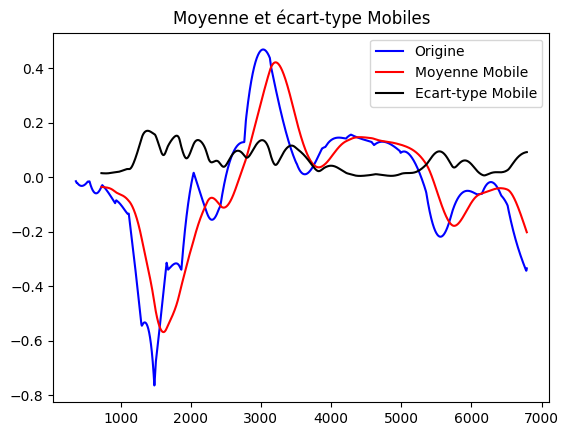

Statistiques ADF : -2.337944808727141
p-value : 0.16002181152803152
Valeurs Critiques :
	1%: -3.4313720159883494
	5%: -2.8619916423115734
	10%: -2.5670104060049495
exponentielle


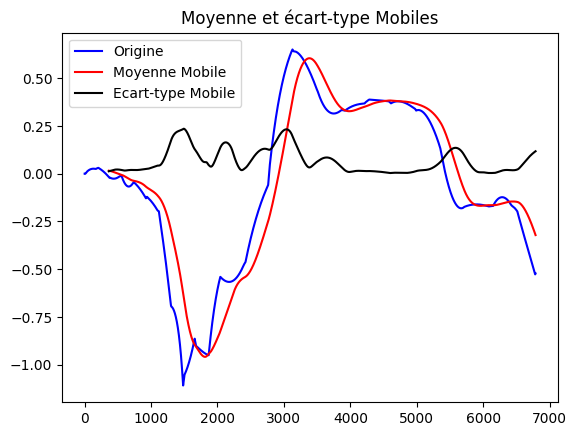

Statistiques ADF : -1.6091490474809427
p-value : 0.47899618415343964
Valeurs Critiques :
	1%: -3.431317004144342
	5%: -2.8619673358083286
	10%: -2.5669974671434477
décalage temps


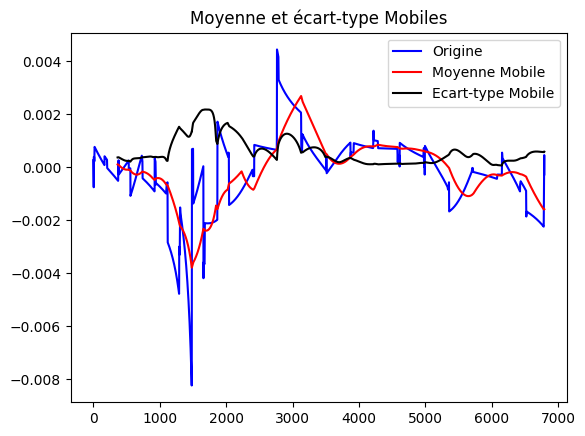

Statistiques ADF : -3.5214571078478927
p-value : 0.007452829882733527
Valeurs Critiques :
	1%: -3.431317004144342
	5%: -2.8619673358083286
	10%: -2.5669974671434477


In [70]:
periode_choisie =365 # si on utilise av_pdo, sinon 12 car c'est en mois et non en jours

print('original')
test_statio(df[['recouvrement corr %']],periode_choisie)

print('log')
df_log = np.log(df[['recouvrement corr %']])
plt.plot(df_log)
test_statio(df_log,periode_choisie)

print('moins moyenne')
rolling_mean = df_log.rolling(window=periode_choisie).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
test_statio(df_log_minus_mean,periode_choisie)

print('exponentielle')
rolling_mean_exp_decay = df_log.ewm(halflife=periode_choisie, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
test_statio(df_log_exp_decay,periode_choisie)

print('décalage temps')
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
test_statio(df_log_shift,periode_choisie)

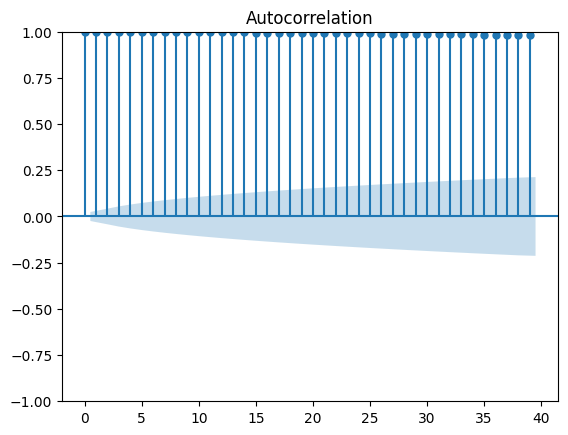

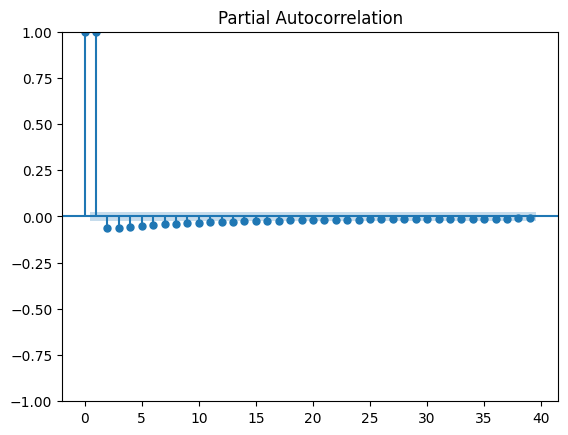

In [71]:
plot_acf(df_log_minus_mean[['recouvrement corr %']].values)
plot_pacf(df_log_minus_mean[['recouvrement corr %']].values)
plt.show()

In [72]:
# séparer test et train
data_arim = df_log_minus_mean[['recouvrement corr %']].values
size = int(len(data_arim) * 0.70)
train, test = data_arim[0:size], data_arim[size:len(data_arim)]

#size = int(len(data_arim) * 0.30) # quand on veut essayer de prédire le passé
#train, test = data_arim[size:], data_arim[:size]

# mettre seasonal à True
seasonal = False

# utiliser pmdarima pour sélectionner automatiquement le meilleur modèle ARIMA
model = pm.auto_arima(train,                              
                      seasonal=seasonal,  
                      d=None,          
                      test='adf',         
                      start_p=0, start_q=0, 
                      max_p=100, max_q=100,
                      D=None,             
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-48637.382, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-48635.269, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-48635.999, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-69520.138, Time=1.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-69565.099, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-69313.448, Time=1.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-69547.422, Time=1.32 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-69567.163, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-69567.481, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-48633.357, Time=0.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-69567.327, Time=0.71 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-48631.225, Time=1.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-69565.763, Time=1.57 sec
 ARIMA(1,1,2

In [73]:
model = ARIMA(train, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
predictions = pd.DataFrame(model_fit.predict(start=size,end=len(data_arim)-1))
predictions.columns =['predicted rec']

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4498
Model:                 ARIMA(0, 1, 0)   Log Likelihood               24319.000
Date:                Tue, 03 Sep 2024   AIC                         -48635.999
Time:                        09:06:45   BIC                         -48629.588
Sample:                             0   HQIC                        -48633.740
                               - 4498                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.176e-06   1.67e-08     70.561      0.000    1.14e-06    1.21e-06
Ljung-Box (L1) (Q):                4439.70   Jarque-Bera (JB):              1189.87
Prob(Q):                              0.00   Pr

C:\Users\julie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


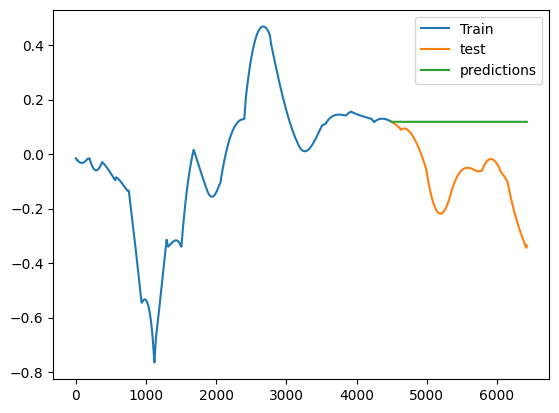

In [74]:
plt.plot(train,label='Train')
plt.plot([k for k in range(size,len(data_arim))],test,label='test')
plt.plot([k for k in range(size,len(data_arim))],predictions,label='predictions')
plt.legend()

In [75]:
print("r2 :", metrics.r2_score(test, predictions))
rmse = np.sqrt(metrics.mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

r2 : -2.949917776387164
Test RMSE: 0.224


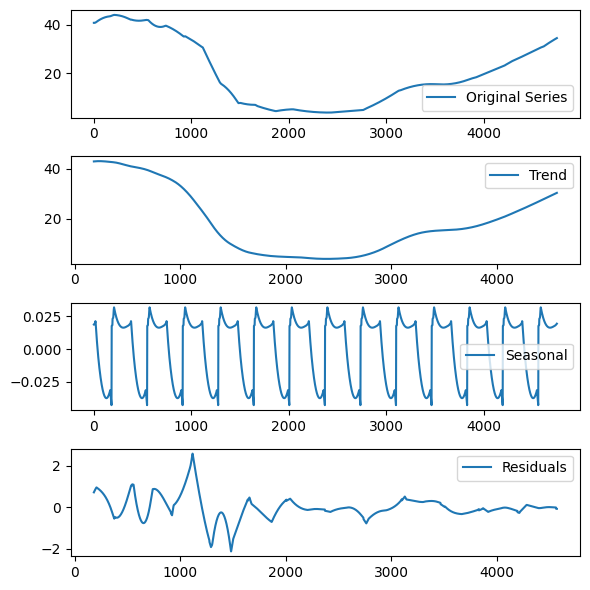

In [76]:
df_arima = av_pdo[['recouvrement corr %']]
size = int(df_arima.shape[0] * 0.70)
train, test = df_arima.iloc[0:size], df_arima.iloc[size:df_arima.shape[0]]

result = seasonal_decompose(train, period=365)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Afficher la décomposition du jeu d'entrainement
plt.figure(figsize=(6,6))
 
plt.subplot(4, 1, 1)
plt.plot(train['recouvrement corr %'], label='Original Series')
plt.legend()
 
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
 
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
 
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()
 
plt.tight_layout()
plt.show()

In [77]:
# utiliser pmdarima pour sélectionner automatiquement le meilleur modèle ARIMA
liste_arim = pd.merge(trend,residual,left_index=True,right_index=True)
liste_arim.reset_index(inplace=True)
liste_arim['trend residuals']=liste_arim['trend']+liste_arim['resid']
liste_arim.drop(columns=['index'],inplace=True)

model = pm.auto_arima(liste_arim['trend residuals'],                               
                      seasonal=False,  
                      d=None,            
                      test='adf',        
                      start_p=0, start_q=0, 
                      max_p=12, max_q=12, 
                      D=None,             
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20354.868, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34469.110, Time=0.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24944.713, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-20285.439, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-35440.292, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-35437.979, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-35440.286, Time=0.52 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-27706.368, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-35438.168, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-35442.226, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-24886.510, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-34470.584, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-35439.923, Time=0.18 sec
 ARIMA(1,1,2

In [78]:
model = ARIMA(liste_arim['trend residuals'], order=(0,2,1))
model_fit = model.fit()
print(model_fit.summary())
predictions = pd.DataFrame(model_fit.predict(start=size,end=df_arima.shape[0]-1))
predictions.columns =['predicted rec']
print(predictions['predicted rec'])
reste=size%365
Nb_annees = (df_arima.shape[0]-size)/365 + 1
season_to_add=np.roll(seasonal[:int(365*Nb_annees)].to_numpy(),reste)[:df_arima.shape[0]-size]
predictions['predicted rec season']=predictions['predicted rec']+season_to_add

                               SARIMAX Results                                
Dep. Variable:        trend residuals   No. Observations:                 4389
Model:                 ARIMA(0, 2, 1)   Log Likelihood               17717.991
Date:                Tue, 03 Sep 2024   AIC                         -35431.983
Time:                        09:06:53   BIC                         -35419.210
Sample:                             0   HQIC                        -35427.476
                               - 4389                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5037      0.002   -208.784      0.000      -0.508      -0.499
sigma2      1.814e-05   4.63e-08    392.165      0.000    1.81e-05    1.82e-05
Ljung-Box (L1) (Q):                   0.12   Jarque-

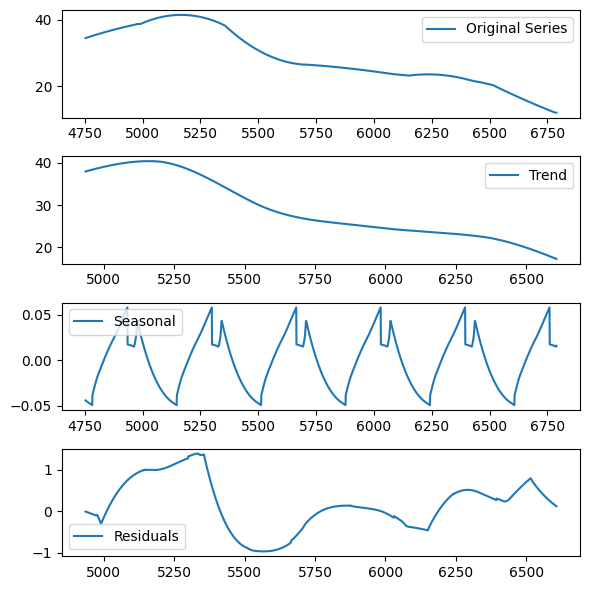

In [79]:
result_test = seasonal_decompose(test, period=365)
trend_test = result_test.trend.dropna()
seasonal_test = result_test.seasonal.dropna()
residual_test = result_test.resid.dropna()

# Afficher la décomposition du jeu de validation pour comparer la composante saisonnière à celle du jeu de test
plt.figure(figsize=(6,6))
 
plt.subplot(4, 1, 1)
plt.plot(test['recouvrement corr %'], label='Original Series')
plt.legend()
 
plt.subplot(4, 1, 2)
plt.plot(trend_test, label='Trend')
plt.legend()
 
plt.subplot(4, 1, 3)
plt.plot(seasonal_test, label='Seasonal')
plt.legend()
 
plt.subplot(4, 1, 4)
plt.plot(residual_test, label='Residuals')
plt.legend()
 
plt.tight_layout()
plt.show()

In [80]:
print("r2 :", metrics.r2_score(test, predictions['predicted rec season']))
rmse = np.sqrt(metrics.mean_squared_error(test['recouvrement corr %'], predictions['predicted rec']))
print('RMSE: %.3f' % rmse)

r2 : -18.432300607179997
RMSE: 36.296


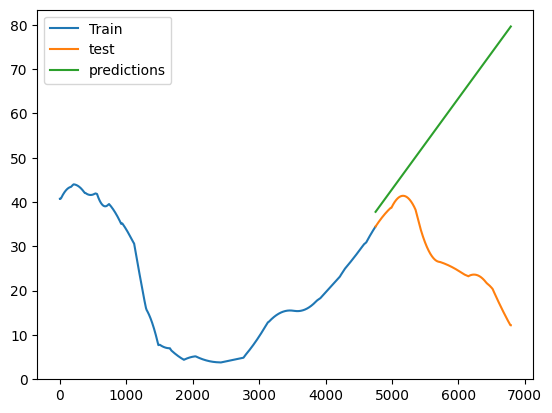

In [81]:
plt.plot(train['recouvrement corr %'],label='Train')
plt.plot([k for k in range(size,df_arima.shape[0])],test['recouvrement corr %'],label='test')
plt.plot([k for k in range(size,df_arima.shape[0])],predictions['predicted rec'],label='predictions')
plt.legend()

In [82]:
model = pm.auto_arima(train,                               
                      seasonal=True,  
                      d=None,            
                      test='adf',        
                      start_p=0, start_q=0,  
                      D=None,             
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-22139.861, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-28484.460, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22126.856, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-47859.557, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-47871.024, Time=2.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-47862.714, Time=2.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-47868.432, Time=1.85 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-47870.249, Time=1.37 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-47148.783, Time=3.62 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-47873.024, Time=0.68 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-47861.593, Time=0.65 sec
 ARIMA(2,1,0)(0,0,0)[0]   

# ARIMA (pour les indicateurs)

MMM

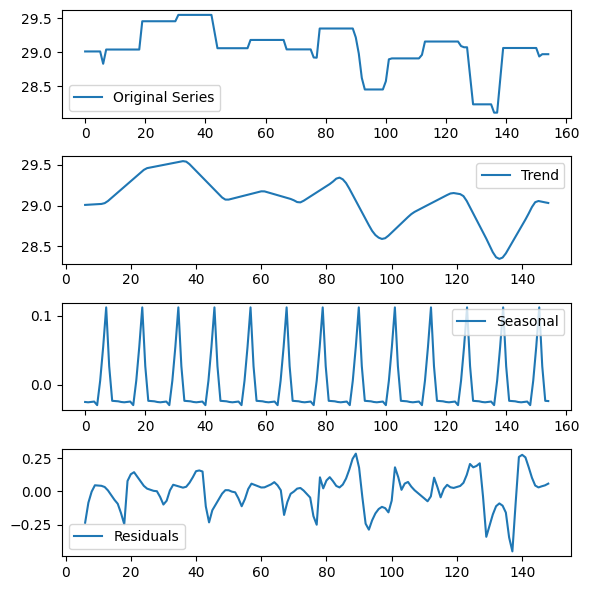

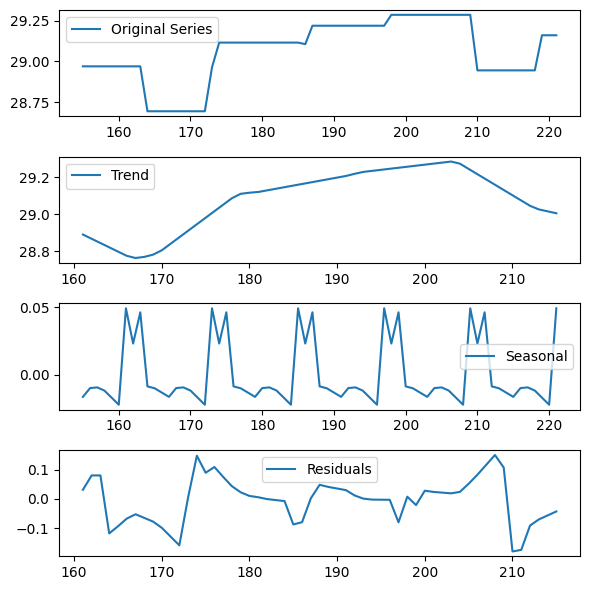

In [83]:
liste_MMM = rec_ind_data_sal[['MMM']]
size = int(len(liste_MMM) * 0.70)
train, test = liste_MMM[0:size], liste_MMM[size:len(liste_MMM)]

#result = seasonal_decompose(train['recouvrement corr %'], model='multiplicative', period=365) # si on utilise av_pdo
result = seasonal_decompose(train, period=12) # si on utilise rec_ind_data_sal
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Afficher la décomposition du jeu d'entrainement
plt.figure(figsize=(6,6))
 
plt.subplot(4, 1, 1)
plt.plot(train['MMM'], label='Original Series')
plt.legend()
 
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
 
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
 
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()
 
plt.tight_layout()
plt.show()

#result = seasonal_decompose(train['recouvrement corr %'], model='multiplicative', period=365)
result = seasonal_decompose(test, period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Affihcer la décomposition du jeu de validation
plt.figure(figsize=(6,6))
 
plt.subplot(4, 1, 1)
plt.plot(test['MMM'], label='Original Series')
plt.legend()
 
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
 
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
 
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()
 
plt.tight_layout()
plt.show()

In [84]:
seasonal = True

# utiliser pmdarima pour sélectionner automatiquement le meilleur modèle ARIMA
model = pm.auto_arima(train,                                 
                      seasonal=seasonal, 
                      d=None,             
                      test='adf',        
                      start_p=0, start_q=0, 
                      max_p=100, max_q=100, 
                      D=None,            
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=97.017, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-243.161, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-70.092, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1486.382, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-266.684, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-266.110, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-266.964, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-268.651, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-266.947, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-163.970, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-263.484, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-253.167, Time=0.02 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.672 seconds
                               SARIMAX Results                                
Dep. Variabl

In [85]:
model = ARIMA(train, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())
predictions = pd.DataFrame(model_fit.predict(start=size,end=len(liste_MMM)-1))
predictions.columns =['predicted rec']

                               SARIMAX Results                                
Dep. Variable:                    MMM   No. Observations:                  155
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 134.465
Date:                Tue, 03 Sep 2024   AIC                           -264.930
Time:                        09:07:15   BIC                           -258.856
Sample:                             0   HQIC                          -262.463
                                - 155                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4144      0.049      8.413      0.000       0.318       0.511
sigma2         0.0102      0.001     18.074      0.000       0.009       0.011
Ljung-Box (L1) (Q):                   0.00   Jarque-

C:\Users\julie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


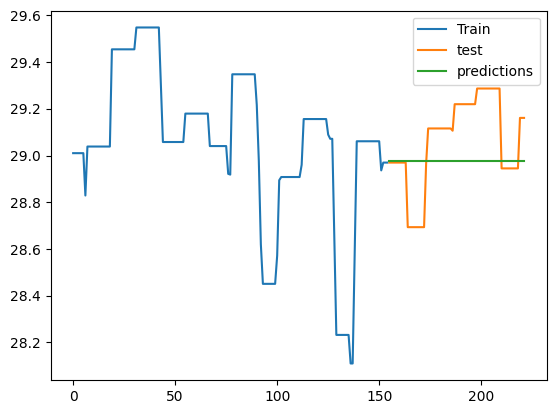

In [86]:
plt.plot(train,label='Train')
plt.plot([k for k in range(size,len(liste_MMM))],test,label='test')
plt.plot([k for k in range(size,len(liste_MMM))],predictions,label='predictions')
plt.legend()

In [87]:
def test_statio_MMM(timeseries, periode):
        ####  détermine si une série temporelle donnée est stationnaire

    #### cette fonction prend les variables suivantes en entrée :
    # timeseries = la série temporelle à étudier
    # periode = le nombre de valeurs à prendre en compte dans la moyenne glissante 
    
    #### et en sortie :
    # Trace la moyenne mobile et l’écart-type mobile. La série temporelle est stationnaire si elle reste constante dans le temps
    # Effecture le test de Dickey Fuller augmenté :  si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF, la série est stationnaire

    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=periode).mean()
    rolling_std = timeseries.rolling(window=periode).std()
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='black', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    result = adfuller(timeseries['MMM'])
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

original


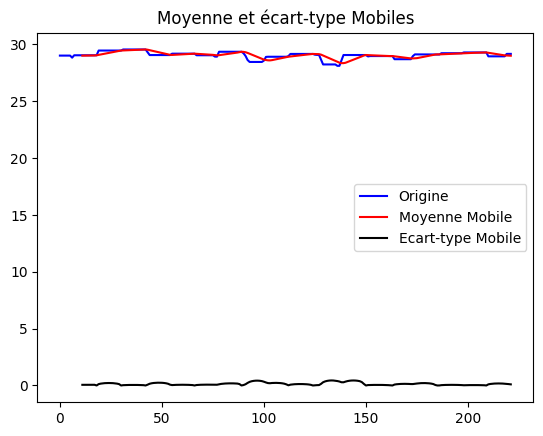

Statistiques ADF : -3.5234088175333915
p-value : 0.007405868884019033
Valeurs Critiques :
	1%: -3.460707667106296
	5%: -2.874891213486339
	10%: -2.573885987711472
log


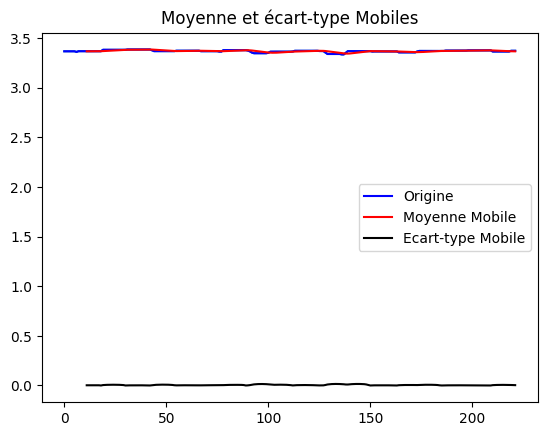

Statistiques ADF : -3.532942617912356
p-value : 0.0071802835605270805
Valeurs Critiques :
	1%: -3.460707667106296
	5%: -2.874891213486339
	10%: -2.573885987711472
moins moyenne


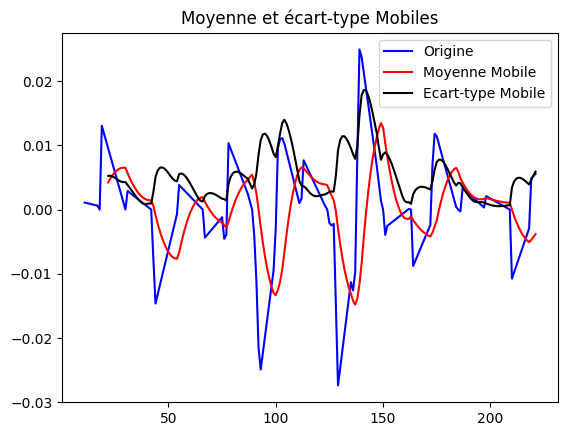

Statistiques ADF : -4.8541991250060175
p-value : 4.278671199822361e-05
Valeurs Critiques :
	1%: -3.4633090972761744
	5%: -2.876029332045744
	10%: -2.5744932593252643
exponentielle


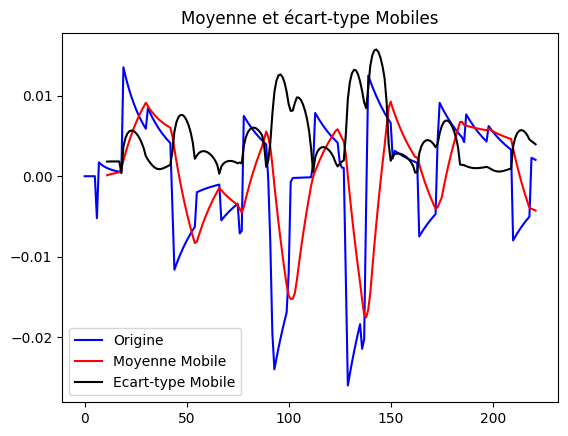

Statistiques ADF : -4.213098372622539
p-value : 0.000626056714112985
Valeurs Critiques :
	1%: -3.4615775784078466
	5%: -2.875271898983725
	10%: -2.5740891037735847
décalage temps


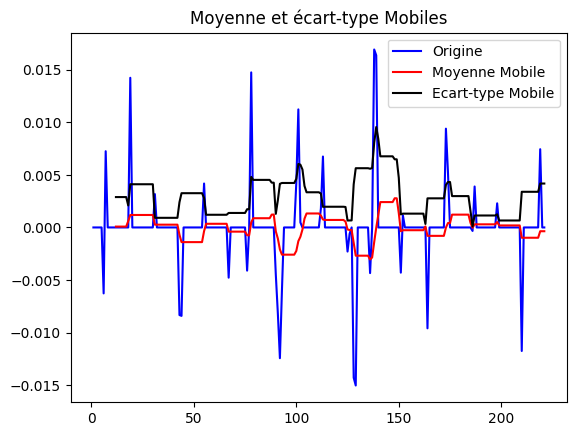

Statistiques ADF : -9.686152396218839
p-value : 1.1691299554836656e-16
Valeurs Critiques :
	1%: -3.460567372610299
	5%: -2.874829809033386
	10%: -2.573853225954421


In [88]:
periode_choisie =12
df = rec_ind_data_sal[['MMM']]
print('original')
test_statio_MMM(df[['MMM']],periode_choisie)

print('log')
df_log = np.log(df[['MMM']])
plt.plot(df_log)
test_statio_MMM(df_log,periode_choisie)

print('moins moyenne')
rolling_mean = df_log.rolling(window=periode_choisie).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
test_statio_MMM(df_log_minus_mean,periode_choisie)

print('exponentielle')
rolling_mean_exp_decay = df_log.ewm(halflife=periode_choisie, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
test_statio_MMM(df_log_exp_decay,periode_choisie)

print('décalage temps')
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
test_statio_MMM(df_log_shift,periode_choisie)

In [89]:
liste_MMM_log = df_log[['MMM']]
size = int(len(liste_MMM_log) * 0.70)
train, test = liste_MMM_log[0:size], liste_MMM_log[size:len(liste_MMM_log)]

seasonal = False

# utiliser pmdarima pour sélectionner automatiquement le meilleur modèle ARIMA
model = pm.auto_arima(train,                                    
                      seasonal=seasonal,
                      d=None,            
                      test='adf',        
                      start_p=0, start_q=0, 
                      max_p=100, max_q=100,
                      D=None,             
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=818.428, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1292.366, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1290.336, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1290.619, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1288.618, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1310.315, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1113.079, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1285.328, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1308.950, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1308.564, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-94

In [90]:
model = ARIMA(train, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())
predictions = pd.DataFrame(model_fit.predict(start=size,end=len(liste_MMM_log)-1))
predictions.columns =['predicted rec']

                               SARIMAX Results                                
Dep. Variable:                    MMM   No. Observations:                  155
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 652.455
Date:                Tue, 03 Sep 2024   AIC                          -1300.909
Time:                        09:07:16   BIC                          -1294.835
Sample:                             0   HQIC                         -1298.442
                                - 155                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4214      0.049      8.575      0.000       0.325       0.518
sigma2       1.22e-05   6.75e-07     18.074      0.000    1.09e-05    1.35e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

# ARIMA (pour les valeurs physiques)

In [96]:
liste_sst = fill_sst[['Temperature','DateTime']]

train, test = liste_sst[liste_sst['DateTime']<pd.to_datetime('2010-01-01')][['Temperature']], liste_sst[(liste_sst['DateTime']>=pd.to_datetime('2010-01-01'))][['Temperature']]

In [92]:
model = pm.auto_arima(train,                                    
                      seasonal=False,
                      d=None,            
                      test='adf',        
                      start_p=0, start_q=0, 
                      max_p=100, max_q=100,
                      D=None,             
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=79680.191, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.56 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-14404.971, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-14506.162, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-14514.417, Time=0.51 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-14512.750, Time=0.41 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-14080.013, Time=1.67 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-14519.286, Time=0.61 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-14498.610, Time=0.40 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=2.24 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-14532.192, Time=1.28 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC

In [93]:
model = ARIMA(train, order=(5,0,5))
model_fit = model.fit()
print(model_fit.summary())
predictions = pd.DataFrame(model_fit.predict(start=len(train),end=len(liste_sst)-1))
predictions.columns =['predicted sst']
print(predictions['predicted sst'])

C:\Users\julie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                 8401
Model:                 ARIMA(5, 0, 5)   Log Likelihood                7410.566
Date:                Tue, 03 Sep 2024   AIC                         -14797.131
Time:                        09:09:54   BIC                         -14712.698
Sample:                             0   HQIC                        -14768.302
                               - 8401                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.7433      0.197    140.679      0.000      27.357      28.130
ar.L1          1.7400      0.033     52.837      0.000       1.675       1.805
ar.L2         -1.3632      0.064    -21.350      0.0

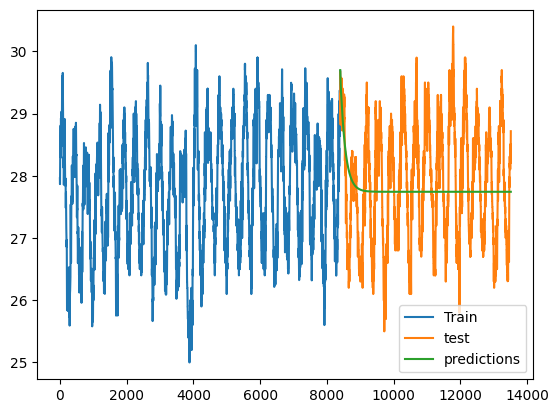

In [94]:
plt.plot(train,label='Train')
plt.plot([k for k in range(len(train),len(liste_sst))],test,label='test')
plt.plot([k for k in range(len(train),len(liste_sst))],predictions['predicted sst'],label='predictions')
plt.legend()

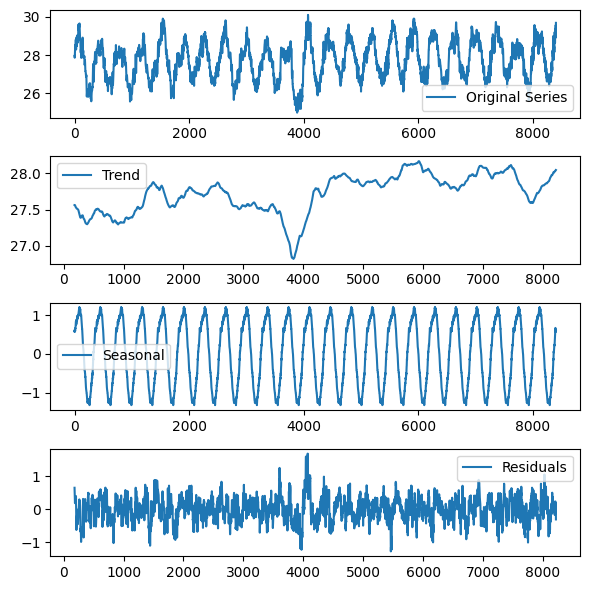

In [97]:
result = seasonal_decompose(train, period=365)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Afficher la décomposition du jeu d'entrainement
plt.figure(figsize=(6,6))
 
plt.subplot(4, 1, 1)
plt.plot(train['Temperature'], label='Original Series')
plt.legend()
 
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
 
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
 
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()
 
plt.tight_layout()
plt.show()

In [98]:
# utiliser pmdarima pour sélectionner automatiquement le meilleur modèle ARIMA
liste_arim = pd.merge(trend,residual,left_index=True,right_index=True)
liste_arim.reset_index(inplace=True)
liste_arim['trend residuals']=liste_arim['trend']+liste_arim['resid']
liste_arim.drop(columns=['index'],inplace=True)

model = pm.auto_arima(liste_arim['trend residuals'],                               
                      seasonal=False,  
                      d=None,            
                      test='adf',        
                      start_p=0, start_q=0,  
                      D=None,             
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=76213.233, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-14418.333, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-14498.353, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-14508.172, Time=0.63 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-14505.149, Time=0.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-14786.507, Time=1.47 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-14514.386, Time=0.27 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-14479.023, Time=2.18 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-14430.957, Time=2.05 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=2.60 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC

In [99]:
model = ARIMA(liste_arim['trend residuals'], order=(3,0,2))
model_fit = model.fit()
print(model_fit.summary())
predictions = pd.DataFrame(model_fit.predict(start=len(train),end=len(fill_sst)-1))
predictions.columns =['predicted sst']
print(predictions['predicted sst'])
reste=len(train)%365
Nb_annees = (len(fill_sst)-len(train))/365 + 1
season_to_add=np.roll(seasonal[:int(365*Nb_annees)].to_numpy(),reste)[:len(fill_sst)-len(train)]
predictions['predicted sst season']=predictions['predicted sst']+season_to_add

                               SARIMAX Results                                
Dep. Variable:        trend residuals   No. Observations:                 8037
Model:                 ARIMA(3, 0, 2)   Log Likelihood                7433.172
Date:                Tue, 03 Sep 2024   AIC                         -14852.344
Time:                        09:12:39   BIC                         -14803.401
Sample:                             0   HQIC                        -14835.596
                               - 8037                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.7242      0.071    389.111      0.000      27.585      27.864
ar.L1          2.5276      0.024    105.978      0.000       2.481       2.574
ar.L2         -2.1875      0.046    -47.315      0.0

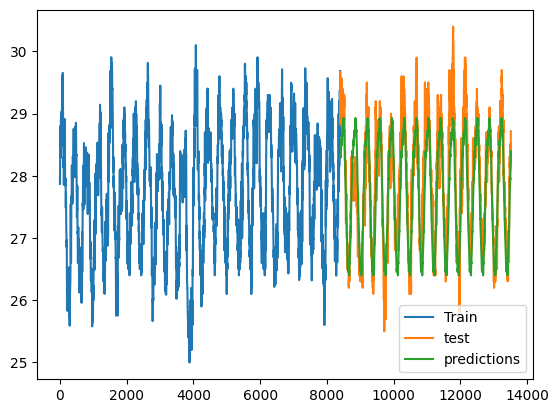

In [100]:
plt.plot(train['Temperature'],label='Train')
plt.plot([k for k in range(len(train),len(fill_sst))],test['Temperature'],label='test')
plt.plot([k for k in range(len(train),len(fill_sst))],predictions['predicted sst season'],label='predictions')
plt.legend()

In [101]:
print("r2 :", metrics.r2_score(test, predictions['predicted sst season']))
rmse = np.sqrt(metrics.mean_squared_error(test['Temperature'], predictions['predicted sst season']))
print('RMSE: %.3f' % rmse)

r2 : 0.7526212983194658
RMSE: 0.462


# SARIMA pour les données physiques (salinité)

In [102]:
model = ARIMA(train, order=(3,0,0),seasonal_order=(0,1,0,365))
model_fit = model.fit()
print(model_fit.summary())
predictions = pd.DataFrame(model_fit.predict(start=len(train),end=len(liste_sst)-1))
predictions.columns =['predicted sst']
print(predictions['predicted sst'])

KeyboardInterrupt: 

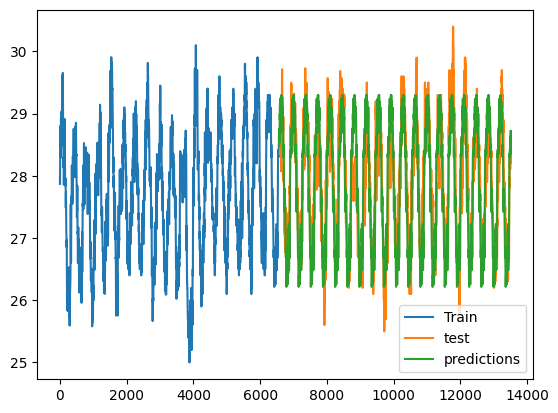

In [ ]:
plt.plot(train,label='Train')
plt.plot([k for k in range(len(train),len(liste_sst))],test,label='test')
plt.plot([k for k in range(len(train),len(liste_sst))],predictions['predicted sst'],label='predictions')
plt.legend()

In [ ]:
print("r2 :", metrics.r2_score(test, predictions['predicted sst']))
rmse = np.sqrt(metrics.mean_squared_error(test, predictions['predicted sst']))
print('Test RMSE: %.3f' % rmse)

r2 : 0.6758331153558017
Test RMSE: 0.525


calcul des indicateurs

Text(0, 0.5, 'Date')

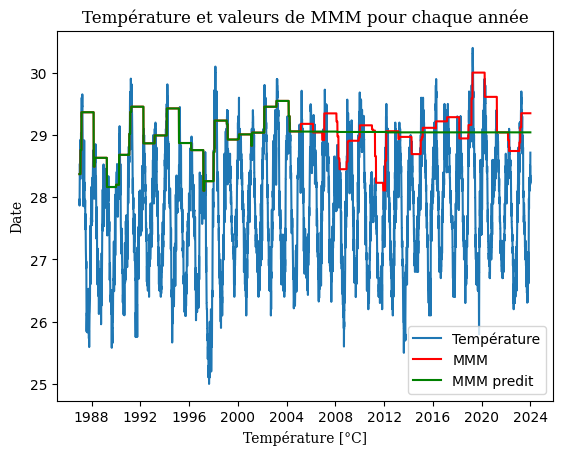

In [ ]:
#MMM
sst_predict = pd.concat([train,predictions['predicted sst']])

sst_true = fill_sst
sst_predict = sst_predict.rename('Temperature')
sst_predict = sst_predict.to_frame()
sst_predict = pd.concat([sst_predict,fill_sst['DateTime']], axis=1)
monthly_means_pred = sst_predict.groupby(pd.Grouper(key='DateTime', freq='1ME')).mean().reset_index()
monthly_means_pred['MMM'] = monthly_means_pred['Temperature'].rolling(window=12, min_periods=1).max()
monthly_means_pred['Mois'] = monthly_means_pred['DateTime'].dt.to_period('M')
sst_predict['Mois'] = sst_predict['DateTime'].dt.to_period('M')
sst_predict = pd.merge(sst_predict, monthly_means_pred[['Mois', 'MMM']], on='Mois', how='left')
sst_predict.drop(columns='Mois', inplace = True)
plt.plot(fill_sst['DateTime'], fill_sst['Temperature'], label = 'Température')
plt.plot(sst_true['DateTime'], sst_true['MMM'], color = 'r', label = 'MMM')
plt.plot(sst_predict['DateTime'], sst_predict['MMM'], color = 'g', label = 'MMM predit')
plt.legend()
plt.title('Température et valeurs de MMM pour chaque année', fontfamily = 'serif')
plt.xlabel('Température [°C]', fontfamily = 'serif')
plt.ylabel('Date', fontfamily = 'serif')

Text(0, 0.5, 'Date')

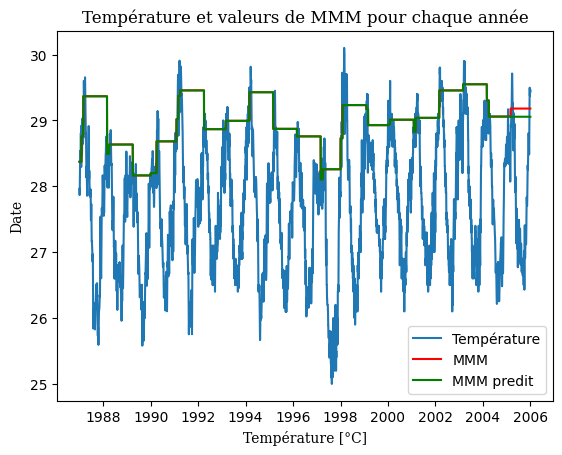

In [ ]:
#uniquement un an
sst_predict=sst_predict[:len(train)+365]
sst_true=sst_true[:len(train)+365]
plt.plot(sst_true['DateTime'], sst_true['Temperature'], label = 'Température')
plt.plot(sst_true['DateTime'], sst_true['MMM'], color = 'r', label = 'MMM')
plt.plot(sst_predict['DateTime'], sst_predict['MMM'], color = 'g', label = 'MMM predit')
plt.legend()
plt.title('Température et valeurs de MMM pour chaque année', fontfamily = 'serif')
plt.xlabel('Température [°C]', fontfamily = 'serif')
plt.ylabel('Date', fontfamily = 'serif')

Text(0, 0.5, 'DHW [°C/weeks]')

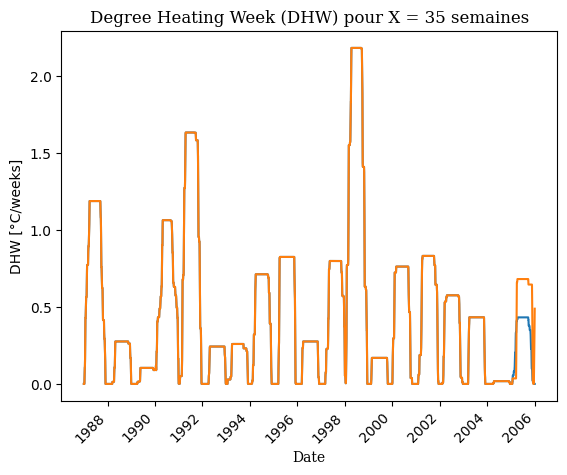

In [ ]:
#DHW
sst_predict.loc[:,'hotspot / 7'] = (sst_predict['Temperature'] - sst_predict['MMM'])/7
sst_predict.loc[sst_predict['hotspot / 7'] < 0, 'hotspot / 7'] = 0
sst_predict.loc[:,'dhw'] = sst_predict['hotspot / 7'].rolling(window=7*35, min_periods=1).sum()
sst_predict = sst_predict.drop(columns='hotspot / 7')
plt.plot(sst_predict['DateTime'], sst_predict['dhw'])
plt.plot(sst_true['DateTime'], sst_true['dhw'])
plt.xticks(rotation=45, ha='right')
plt.title('Degree Heating Week (DHW) pour X = 35 semaines', fontfamily = 'serif')
plt.xlabel('Date',fontfamily = 'serif' )
plt.ylabel('DHW [°C/weeks]')

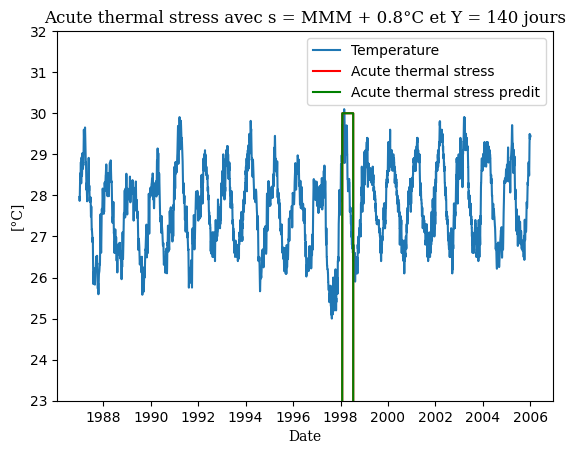

In [ ]:
#Acute thermal stress
threshold = 0.8
sst_predict['excess'] = sst_predict.apply(lambda row: 1 if row['Temperature'] > row['MMM']+threshold else 0, axis=1)
sst_predict['excess'] = sst_predict['excess'].rolling(window = 140, min_periods= 140).sum()
sst_predict['Acute thermal stress'] = sst_predict.apply(lambda row: 1 if row['excess'] > 0 else 0, axis=1)
sst_predict.drop(columns='excess', inplace = True)
plt.plot(sst_true['DateTime'], sst_true['Temperature'], label = 'Temperature')
plt.plot(sst_true['DateTime'], sst_true['Acute thermal stress']*30, color = 'r', label = 'Acute thermal stress')
plt.plot(sst_predict['DateTime'], sst_predict['Acute thermal stress']*30, color = 'g', label = 'Acute thermal stress predit')
plt.title('Acute thermal stress avec s = MMM + 0.8°C et Y = 140 jours', fontfamily = 'serif')
plt.ylabel('[°C]', fontfamily = 'serif')
plt.xlabel('Date', fontfamily = 'serif')
plt.ylim(23, 32)
plt.legend()

Text(0, 0.5, 'Temperature')

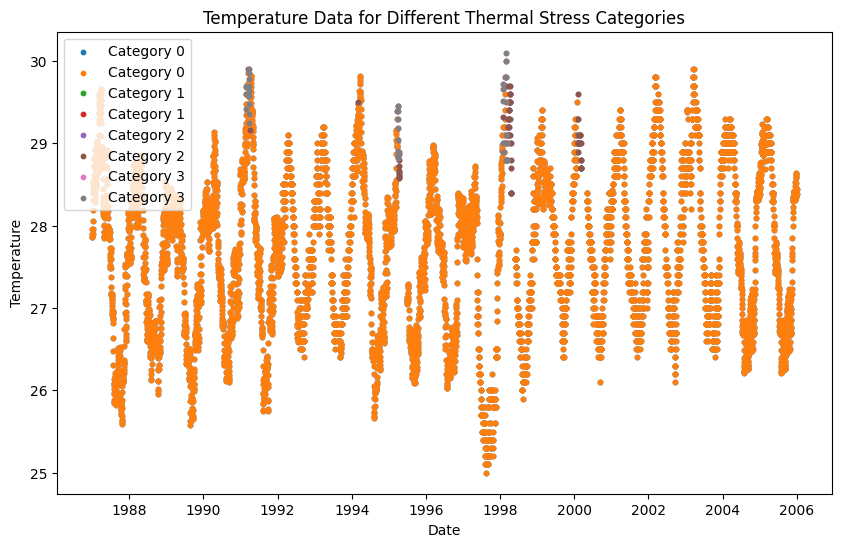

In [ ]:
#thermal trajectory
threshold = 0.5

sst_predict.loc[:,'thermal_stress_category'] = ''

for i in range(sst_predict.shape[0]):

    dix_derniers_jours = []
    for k in range(10):
        if i>=k:
            dix_derniers_jours.append(sst_predict['Temperature'].values[i-k])
    nb_depassant_MMM = sum(1 for valeur in dix_derniers_jours if valeur > sst_predict['MMM'].iloc[i])
    nb_depassant_MMM_threshold = sum(1 for valeur in dix_derniers_jours if valeur > sst_predict['MMM'].iloc[i] + threshold)

    # Condition 2
    if nb_depassant_MMM > nb_depassant_MMM_threshold:
        sst_predict['thermal_stress_category'].values[i] = 2
    
    # Condition 3
    if nb_depassant_MMM_threshold >= 2:
        sst_predict['thermal_stress_category'].values[i] = 3
    
    # Condition 1
    if sst_predict['Temperature'].values[i-10] >= sst_predict['MMM'].values[i-10] and nb_depassant_MMM == 1:
        sst_predict['thermal_stress_category'].values[i] = 1

    # Condition 0
    derniers_jours = []
    for k in range(90):
        if i>=k:
            derniers_jours.append(sst_predict['Temperature'].values[i-k]) #90 derniers jours
    nb_depassant_MMM_threshold = sum(1 for valeur in derniers_jours if valeur > sst_predict['MMM'].iloc[i] + threshold)
    if nb_depassant_MMM_threshold == 0:
        sst_predict['thermal_stress_category'].values[i] = 0
    
    if sst_predict['thermal_stress_category'].values[i] == '':
        sst_predict['thermal_stress_category'].values[i] = 0.5

plt.figure(figsize=(10, 6))

for category in range(4):
    category_data = sst_predict[sst_predict['thermal_stress_category'] == category]
    plt.scatter(category_data['DateTime'], category_data['Temperature'], label=f'Category {category}', s = 10)
    category_data2 = sst_true[sst_true['thermal_stress_category'] == category]
    plt.scatter(category_data['DateTime'], category_data['Temperature'], label=f'Category {category}', s = 10)
plt.legend()
plt.title('Temperature Data for Different Thermal Stress Categories')
plt.xlabel('Date')
plt.ylabel('Temperature')

In [ ]:
periode_choisie = 365
df_sst = fill_sst[['Temperature']]
print('original')
test_statio_sst(df_sst[['Temperature']],periode_choisie)

print('log')
df_log = np.log(df_sst[['Temperature']])
plt.plot(df_log)
test_statio_sst(df_log,periode_choisie)

print('moins moyenne')
rolling_mean = df_log.rolling(window=periode_choisie).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
test_statio_sst(df_log_minus_mean,periode_choisie)

print('exponentielle')
rolling_mean_exp_decay = df_log.ewm(halflife=periode_choisie, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
test_statio_sst(df_log_exp_decay,periode_choisie)

print('décalage temps')
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
test_statio_sst(df_log_shift,periode_choisie)

# ARIMA (données physiques salinité)

In [116]:
liste_salinite = salinite[['salinite','DateTime']]
train, test = liste_salinite[liste_salinite['DateTime']<pd.to_datetime('2010-01-01')][['salinite']], liste_salinite[liste_salinite['DateTime']>=pd.to_datetime('2010-01-01')][['salinite']]

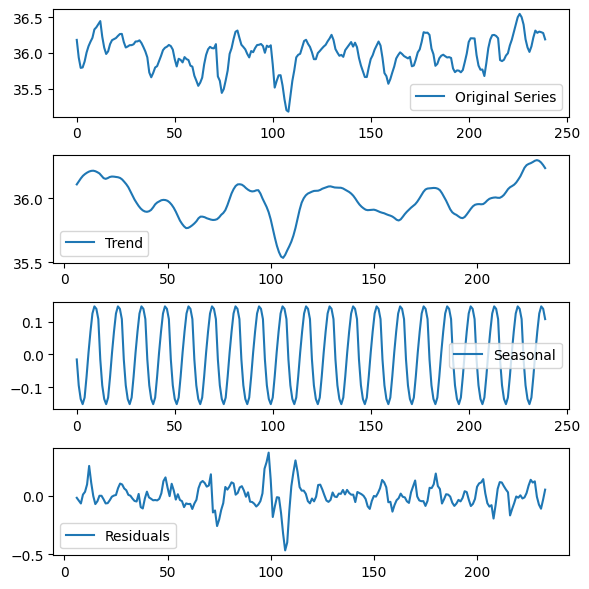

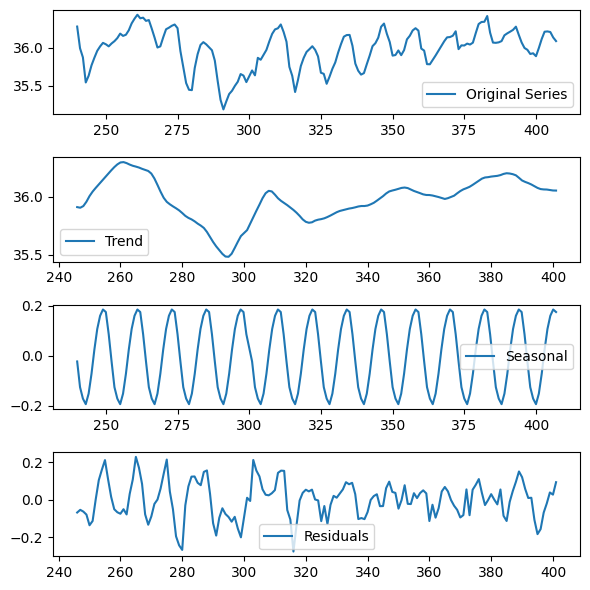

In [117]:
result = seasonal_decompose(train, period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Afficher la décomposition du jeu d'entrainement
plt.figure(figsize=(6,6))
 
plt.subplot(4, 1, 1)
plt.plot(train['salinite'], label='Original Series')
plt.legend()
 
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
 
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
 
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()
 
plt.tight_layout()
plt.show()

result_t = seasonal_decompose(test, period=12)
trend_t = result_t.trend.dropna()
seasonal_t = result_t.seasonal.dropna()
residual_t = result_t.resid.dropna()

# Afficher la décomposition du jeu d'entrainement
plt.figure(figsize=(6,6))
 
plt.subplot(4, 1, 1)
plt.plot(test['salinite'], label='Original Series')
plt.legend()
 
plt.subplot(4, 1, 2)
plt.plot(trend_t, label='Trend')
plt.legend()
 
plt.subplot(4, 1, 3)
plt.plot(seasonal_t, label='Seasonal')
plt.legend()
 
plt.subplot(4, 1, 4)
plt.plot(residual_t, label='Residuals')
plt.legend()
 
plt.tight_layout()
plt.show()

In [109]:
# utiliser pmdarima pour sélectionner automatiquement le meilleur modèle ARIMA
liste_arim = pd.merge(trend,residual,left_index=True,right_index=True)
liste_arim.reset_index(inplace=True)
liste_arim['trend residuals']=liste_arim['trend']+liste_arim['resid']
liste_arim.drop(columns=['index'],inplace=True)

model = pm.auto_arima(liste_arim['trend residuals'],                               
                      seasonal=False,  
                      d=None,            
                      test='adf',        
                      start_p=0, start_q=0,  
                      D=None,             
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1682.475, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-355.840, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-356.530, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-356.708, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-354.999, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-355.934, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-354.894, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-380.384, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-383.581, Time=0.13 s

In [120]:
model = ARIMA(liste_arim['trend residuals'], order=(2,0,0))
model_fit = model.fit()
print(model_fit.summary())
predictions = pd.DataFrame(model_fit.predict(start=len(train),end=len(liste_salinite)-1))
predictions.columns =['predicted salinite']
print(predictions['predicted salinite'])
reste=len(train)%12
Nb_annees = (len(liste_salinite)-len(train))/12 + 1

season_to_add=np.roll(seasonal[:int(12*Nb_annees)].to_numpy(),reste)[:len(liste_salinite)-len(train)]
predictions['predicted salinite season']=predictions['predicted salinite']+season_to_add

                               SARIMAX Results                                
Dep. Variable:        trend residuals   No. Observations:                  168
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 196.614
Date:                Tue, 03 Sep 2024   AIC                           -385.227
Time:                        09:25:25   BIC                           -372.731
Sample:                             0   HQIC                          -380.156
                                - 168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.9654      0.058    616.445      0.000      35.851      36.080
ar.L1          1.2689      0.046     27.472      0.000       1.178       1.359
ar.L2         -0.3884      0.049     -7.948      0.0

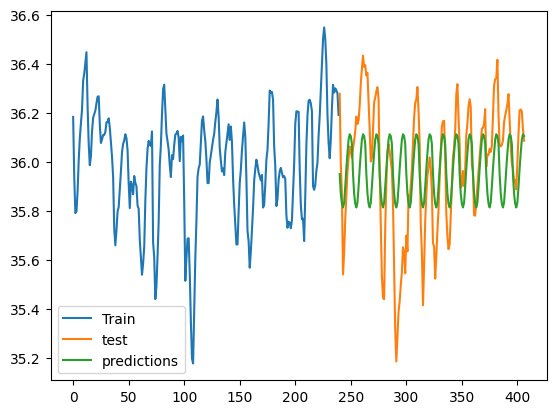

In [121]:
plt.plot(train['salinite'],label='Train')
plt.plot([k for k in range(len(train),len(liste_salinite))],test['salinite'],label='test')
plt.plot([k for k in range(len(train),len(liste_salinite))],predictions['predicted salinite season'],label='predictions')
plt.legend()

# SARIMA (données physiques salinité)

In [ ]:
liste_salinite = salinite[['salinite','DateTime']]
#size = int(len(liste_salinite) * 0.70)
train, test = liste_salinite[liste_salinite['DateTime']<pd.to_datetime('2005-01-01')]['salinite'], liste_salinite[liste_salinite['DateTime']>=pd.to_datetime('2011-01-01')]['salinite']

In [ ]:
model = ARIMA(train, order=(3,0,1),seasonal_order=(2,1,0,12))
model_fit = model.fit()
print(model_fit.summary())
predictions = pd.DataFrame(model_fit.predict(start=len(train),end=len(liste_salinite)-1))
predictions.columns =['predicted salinite']
print(predictions['predicted salinite'])

In [ ]:
plt.plot(train,label='Train')
plt.plot([k for k in range(len(train),len(liste_salinite))],test,label='test')
plt.plot([k for k in range(len(train),len(liste_salinite))],predictions['predicted salinite'],label='predictions')
plt.legend()

In [ ]:
plt.plot(train,label='Train')
plt.plot([k for k in range(len(train),len(train)+12)],test[:12],label='test')
plt.plot([k for k in range(len(train),len(train)+12)],predictions['predicted salinite'][:12],label='predictions')
plt.legend()

# SARIMA (données physiques houle)

# SARIMAX (exogenous)

In [ ]:
#df_sarimax = rec_ind_data_sal
df_sarimax = av_pdo
size = int(len(df_sarimax) * 0.70)
train, test = df_sarimax[0:size], df_sarimax[size:len(df_sarimax)]

result = seasonal_decompose(train['recouvrement corr %'], period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()
 
# Afficher la décomposition
plt.figure(figsize=(6,6))
 
plt.subplot(4, 1, 1)
plt.plot(df_sarimax['recouvrement corr %'], label='Original Series')
plt.legend()
 
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
 
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
 
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()
 
plt.tight_layout()
plt.show()

result = seasonal_decompose(test['recouvrement corr %'], period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()
 
# Afficher la décomposition
plt.figure(figsize=(6,6))
 
plt.subplot(4, 1, 1)
plt.plot(df_sarimax['recouvrement corr %'], label='Original Series')
plt.legend()
 
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
 
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
 
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()
 
plt.tight_layout()
plt.show()

In [ ]:
"""SARIMAX_model = pm.auto_arima(train[['recouvrement corr %']],exogenous=train[['DateTime','pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']],  # si rec_ind_data
                           start_p=0, start_q=0,
                           test='adf', m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)"""

SARIMAX_model = pm.auto_arima(train[['recouvrement corr %']], exogenous=train[['DateTime', 'dhw', 'MMM','phioc','puissance STL']], # si av_pdo
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=30, max_q=30, m=365,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)


In [ ]:
predictions = pd.DataFrame(SARIMAX_model.predict(n_periods=df_sarimax.shape[0]-size,X = test[['DateTime','pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']]))
#predictions = pd.DataFrame(SARIMAX_model.predict(n_periods=df_sarimax.shape[0]-size,X = test[['DateTime', 'dhw', 'MMM','phioc','puissance STL']]))
predictions.columns =['predicted rec']

In [ ]:
plt.plot(train['recouvrement corr %'],label='Train')
plt.plot([k for k in range(size,df_sarimax.shape[0])],test['recouvrement corr %'],label='test')
plt.plot([k for k in range(size,df_sarimax.shape[0])],predictions,label='predictions')
plt.legend()
plt.show()

In [ ]:
periode_choisie = 12
df_rec = rec_ind_data_sal[['recouvrement corr %']]
print('original')
test_statio(df_rec[['recouvrement corr %']],periode_choisie)

print('log')
df_log = np.log(df_rec[['recouvrement corr %']])
plt.plot(df_log)
test_statio(df_log,periode_choisie)

print('moins moyenne')
rolling_mean = df_log.rolling(window=periode_choisie).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
test_statio(df_log_minus_mean,periode_choisie)

print('exponentielle')
rolling_mean_exp_decay = df_log.ewm(halflife=periode_choisie, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
test_statio(df_log_exp_decay,periode_choisie)

print('décalage temps')
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
test_statio(df_log_shift,periode_choisie)

In [ ]:
liste_sari_log = df_log_minus_mean[['recouvrement corr %']]
rec_ind_data_sal_sans_rec = rec_ind_data_sal.drop(columns=['recouvrement corr %'])
liste_sari_log = pd.concat([liste_sari_log,rec_ind_data_sal_sans_rec], axis=1)
size = int(len(liste_sari_log) * 0.70)
train, test = liste_sari_log[0:size], liste_sari_log[size:len(liste_sari_log)]

seasonal = True

# utiliser pmdarima pour sélectionner automatiquement le meilleur modèle SARIMAX
SARIMAX_model = pm.auto_arima(train[['recouvrement corr %']],exogenous=train[['DateTime','pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']], # si rec_ind_data
                           start_p=0, start_q=0,
                           test='adf', m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(SARIMAX_model.summary())

In [ ]:
predictions = pd.DataFrame(SARIMAX_model.predict(n_periods=liste_sari_log.shape[0]-size,X = test[['DateTime','pdo', 'dhw', 'MMM','phioc','indicateur p rec sans filtre','puissance STL']]))
predictions.columns =['predicted rec']

In [ ]:
plt.plot(train['recouvrement corr %'],label='Train')
plt.plot([k for k in range(size,liste_sari_log.shape[0])],test['recouvrement corr %'],label='test')
plt.plot([k for k in range(size,liste_sari_log.shape[0])],predictions,label='predictions')
plt.legend()
plt.show()

# Classification

Par random forest

Avec les indicateurs


ACCURACY OF THE MODEL: 0.6716417910447762


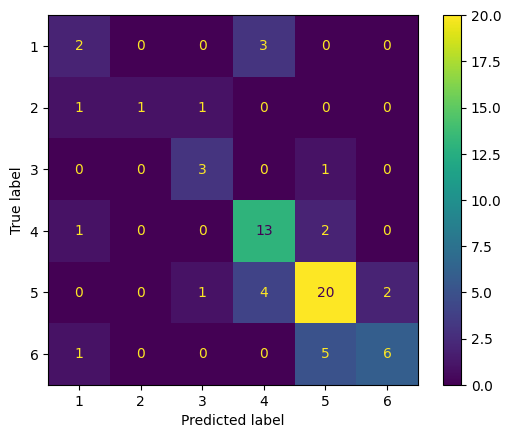

In [145]:
X_train, X_test, y_train, y_test = train_test_split(rec_ind_data_sal[['pdo', 'dhw', 'MMM', 'thermal_stress_category','phioc','puissance STL','indicateur p grad sans filtre','salinite']], rec_ind_data_sal['classe'], test_size = 0.30)

#rec_ind_data_entrainement=pd.concat([rec_ind_data_sal[rec_ind_data_sal['DateTime']<=pd.to_datetime('2015-01-01')],rec_ind_data_sal[rec_ind_data_sal['DateTime']>=pd.to_datetime('2018-01-01')]])
#rec_ind_data_test=rec_ind_data_sal[(rec_ind_data_sal['DateTime']>pd.to_datetime('2015-01-01'))&(rec_ind_data_sal['DateTime']<pd.to_datetime('2018-01-01'))]
#X_train, y_train = rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']], rec_ind_data_entrainement['classe3']
#X_test, y_test = rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']], rec_ind_data_test['classe3']

clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)  
print()

print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

classe by classe

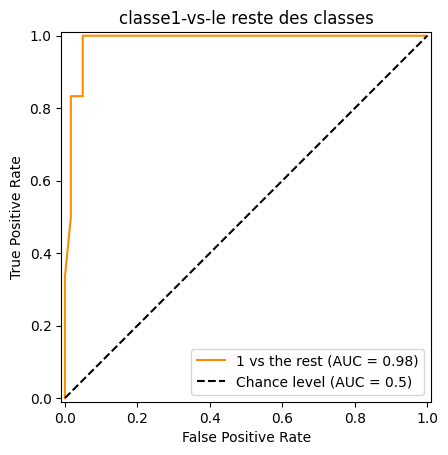

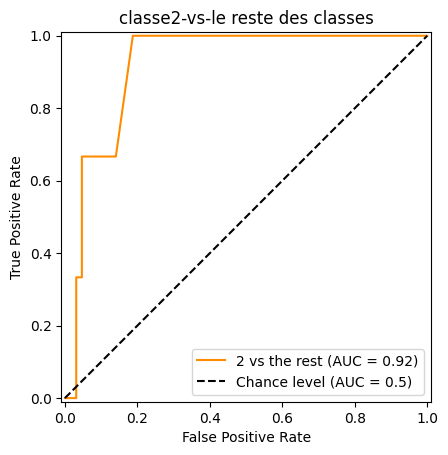

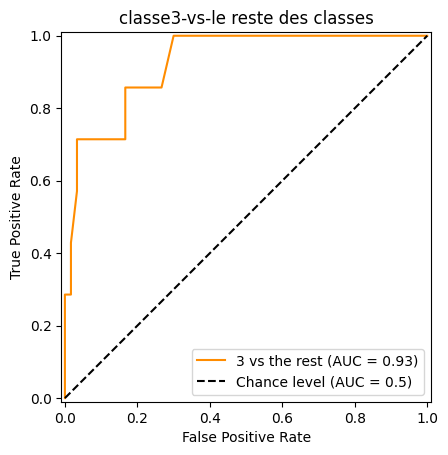

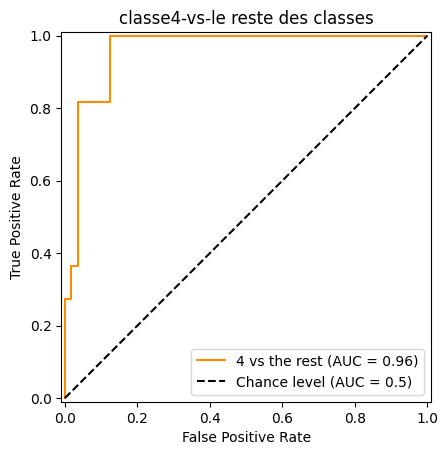

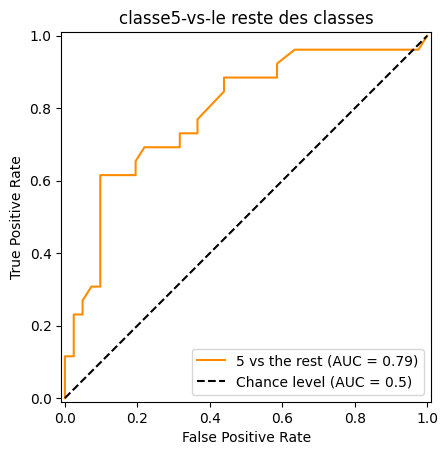

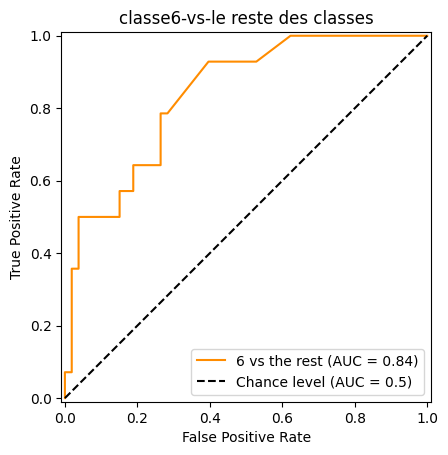

In [128]:
for i in range(1,7):
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    class_of_interest = i
    if np.flatnonzero(label_binarizer.classes_ == class_of_interest).shape[0]>0:
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{class_of_interest} vs the rest",
            color="darkorange",
            plot_chance_level=True,
        )
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title="classe"+str(i)+"-vs-le reste des classes",
        )


ACCURACY OF THE MODEL: 0.6716417910447762


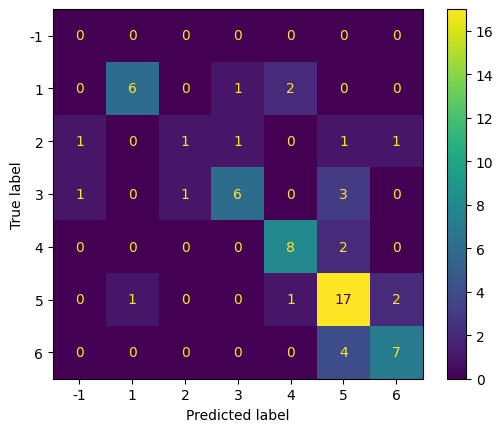

In [154]:
X_train, X_test, y_train, y_test = train_test_split(rec_ind_data_sal[['pdo', 'dhw', 'MMM', 'thermal_stress_category','phioc','puissance STL','indicateur p grad sans filtre','salinite']], rec_ind_data_sal['classe'], test_size = 0.30)

#rec_ind_data_entrainement=pd.concat([rec_ind_data_sal[rec_ind_data_sal['DateTime']<=pd.to_datetime('2015-01-01')],rec_ind_data_sal[rec_ind_data_sal['DateTime']>=pd.to_datetime('2018-01-01')]])
#rec_ind_data_test=rec_ind_data_sal[(rec_ind_data_sal['DateTime']>pd.to_datetime('2015-01-01'))&(rec_ind_data_sal['DateTime']<pd.to_datetime('2018-01-01'))]
#X_train, y_train = rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']], rec_ind_data_entrainement['classe3']
#X_test, y_test = rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']], rec_ind_data_test['classe3']

clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)

# Définir des seuils personnalisés pour chaque classe
seuils = [0.35, 0.35,0.35, 0.35,0.3, 0.2]  

# Appliquer les seuils pour obtenir les prédictions finales
y_pred = []
for proba in y_proba:
    if proba[0] >= seuils[0]:
        y_pred.append(1)
    elif proba[1] >= seuils[1]:
        y_pred.append(2)
    elif proba[2] >= seuils[2]:
        y_pred.append(3)
    elif proba[3] >= seuils[3]:
        y_pred.append(4)
    elif proba[4] >= seuils[4]:
        y_pred.append(5)
    elif proba[5] >= seuils[5]:
        y_pred.append(6)
    else:
        y_pred.append(-1)  # Cas où aucune classe ne dépasse son seuil

y_pred = np.array(y_pred)

y_score = clf.predict_proba(X_test)  
print()

print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


ACCURACY OF THE MODEL: 0.7313432835820896


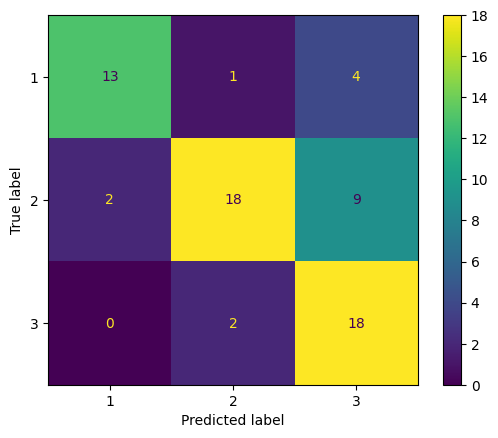

In [138]:
X_train, X_test, y_train, y_test = train_test_split(rec_ind_data_sal[['pdo', 'dhw', 'MMM', 'thermal_stress_category','phioc','puissance STL','indicateur p grad sans filtre','salinite']], rec_ind_data_sal['classe3'], test_size = 0.30)

#rec_ind_data_entrainement=pd.concat([rec_ind_data_sal[rec_ind_data_sal['DateTime']<=pd.to_datetime('2015-01-01')],rec_ind_data_sal[rec_ind_data_sal['DateTime']>=pd.to_datetime('2018-01-01')]])
#rec_ind_data_test=rec_ind_data_sal[(rec_ind_data_sal['DateTime']>pd.to_datetime('2015-01-01'))&(rec_ind_data_sal['DateTime']<pd.to_datetime('2018-01-01'))]
#X_train, y_train = rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']], rec_ind_data_entrainement['classe3']
#X_test, y_test = rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']], rec_ind_data_test['classe3']

clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)

# Définir des seuils personnalisés pour chaque classe
seuils = [0.5, 0.4, 0.2]  # Exemple de seuils pour les classes 0, 1 et 2

# Appliquer les seuils pour obtenir les prédictions finales
y_pred = []
for proba in y_proba:
    if proba[0] >= seuils[0]:
        y_pred.append(1)
    elif proba[1] >= seuils[1]:
        y_pred.append(2)
    elif proba[2] >= seuils[2]:
        y_pred.append(3)
    else:
        y_pred.append(-1)  # Cas où aucune classe ne dépasse son seuil
y_pred = np.array(y_pred)

y_score = clf.predict_proba(X_test)  
print()

print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Avec uniquement les mesures physiques

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(rec_ind_data_sal[['Temperature', 'Hauteur', 'Période', 'salinite','phioc']], rec_ind_data_sal['classe'], test_size = 0.30)

clf = RandomForestClassifier(n_estimators = 100) 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)  
print()

print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Par knn

Avec les indicateurs


ACCURACY OF THE MODEL: 0.22388059701492538


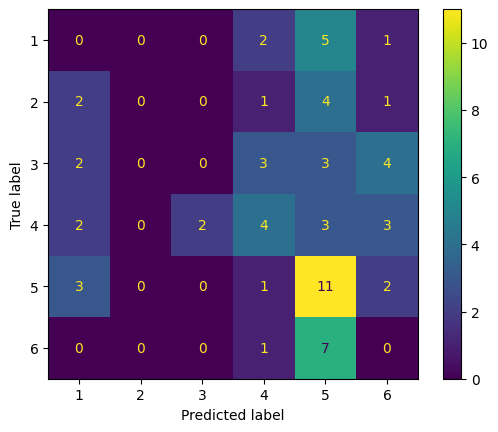

In [155]:
X_train, X_test, y_train, y_test = train_test_split(rec_ind_data_sal[['pdo', 'dhw', 'MMM', 'thermal_stress_category','phioc','puissance STL','indicateur p grad sans filtre','salinite']], rec_ind_data_sal['classe'], test_size = 0.30)

neigh = neighbors.KNeighborsClassifier() 

neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test)
y_score = neigh.predict_proba(X_test)  
print()

print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


classe by classe

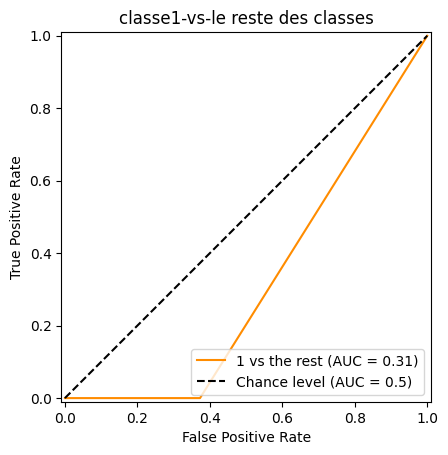

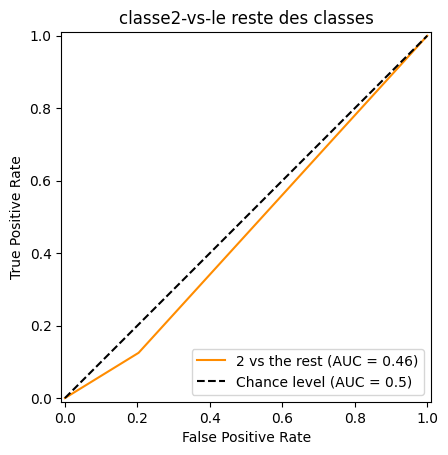

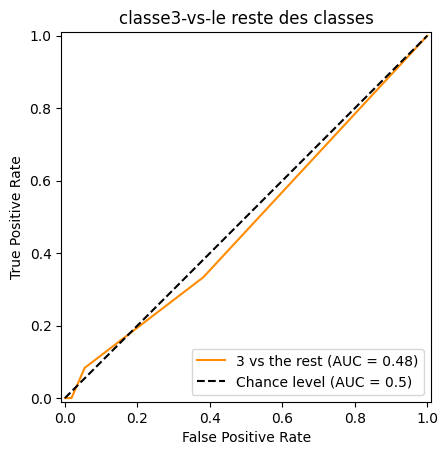

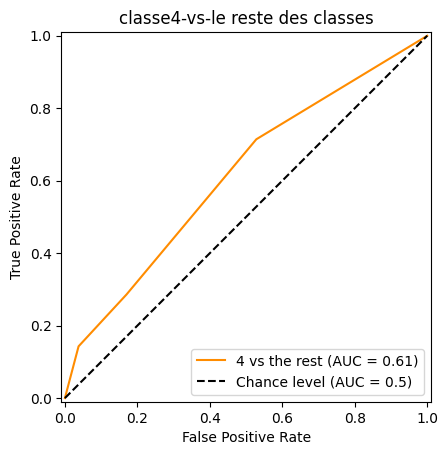

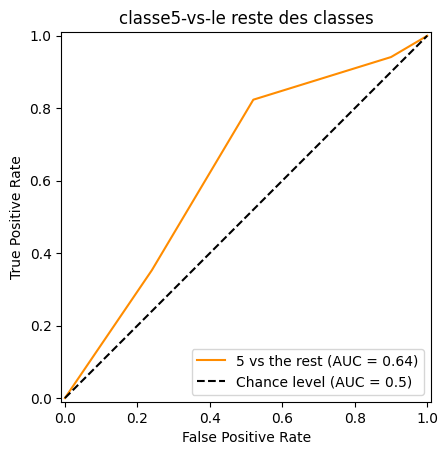

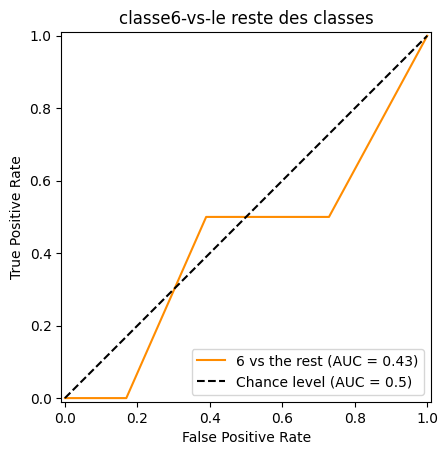

In [156]:
for i in range(1,7):
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    class_of_interest = i
    if np.flatnonzero(label_binarizer.classes_ == class_of_interest).shape[0]>0:
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{class_of_interest} vs the rest",
            color="darkorange",
            plot_chance_level=True,
        )
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title="classe"+str(i)+"-vs-le reste des classes",
        )

Ajout d'un delta t - Random forest


ACCURACY OF THE MODEL: 0.6326530612244898

ACCURACY OF THE MODEL: 0.5714285714285714

ACCURACY OF THE MODEL: 0.673469387755102

ACCURACY OF THE MODEL: 0.4791666666666667

ACCURACY OF THE MODEL: 0.6666666666666666

ACCURACY OF THE MODEL: 0.6666666666666666

ACCURACY OF THE MODEL: 0.6041666666666666

ACCURACY OF THE MODEL: 0.7021276595744681

ACCURACY OF THE MODEL: 0.6382978723404256

ACCURACY OF THE MODEL: 0.574468085106383

ACCURACY OF THE MODEL: 0.6521739130434783

ACCURACY OF THE MODEL: 0.6956521739130435

ACCURACY OF THE MODEL: 0.6304347826086957

ACCURACY OF THE MODEL: 0.8

ACCURACY OF THE MODEL: 0.6666666666666666

ACCURACY OF THE MODEL: 0.5777777777777777

ACCURACY OF THE MODEL: 0.6222222222222222

ACCURACY OF THE MODEL: 0.8181818181818182

ACCURACY OF THE MODEL: 0.7272727272727273

ACCURACY OF THE MODEL: 0.6363636363636364

ACCURACY OF THE MODEL: 0.6744186046511628

ACCURACY OF THE MODEL: 0.7209302325581395

ACCURACY OF THE MODEL: 0.6511627906976745

ACCURACY OF THE MODEL: 0.73

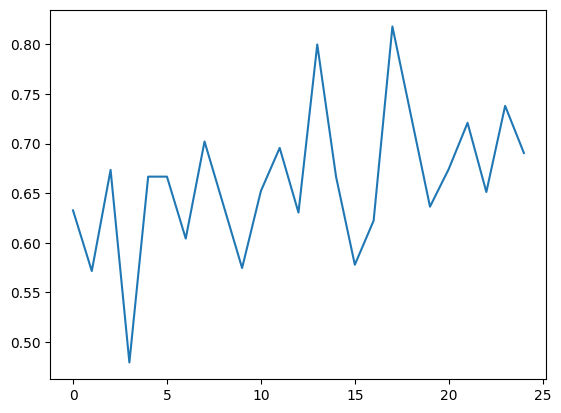

In [ ]:
acc=[]
for k in range(25):
    delta_t=k
    data_decal=(rec_ind_data_sal[['pdo', 'dhw', 'MMM', 'thermal_stress_category','phioc','puissance STL','indicateur p grad sans filtre','salinite']]).shift(periods=delta_t)
    data_decal=pd.DataFrame({'classe':rec_ind_data_sal['classe'],'pdo':data_decal['pdo'],'dhw':data_decal['dhw'],'MMM':data_decal['MMM'],'thermal_stress_category':data_decal['thermal_stress_category'],'phioc':data_decal['phioc'],'puissance STL':data_decal['puissance STL'],'indicateur p grad sans filtre':data_decal['indicateur p grad sans filtre'],'salinite':data_decal['salinite']})
    data_decal=data_decal[delta_t:]
    X_train, X_test, y_train, y_test = train_test_split(data_decal[['pdo', 'dhw', 'MMM', 'thermal_stress_category','phioc','puissance STL','indicateur p grad sans filtre','salinite']], data_decal['classe'], test_size = 0.30)

    clf = RandomForestClassifier(n_estimators = 100) 

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)  
    print()
    acc.append(metrics.accuracy_score(y_test, y_pred))
    print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

plt.plot(acc)

In [ ]:
for i in range(1,7):
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    class_of_interest = i
    if np.flatnonzero(label_binarizer.classes_ == class_of_interest).shape[0]>0:
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{class_of_interest} vs the rest",
            color="darkorange",
            plot_chance_level=True,
        )
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title="classe"+str(i)+"-vs-le reste des classes",
        )

En prenant en compte historique des indicateurs

In [157]:
features_indi,label_classe= forme_donnees_entree(30,'classe')
#features_indi,label_classe= forme_donnees_entree(30,'classe3')


ACCURACY OF THE MODEL: 0.7313432835820896


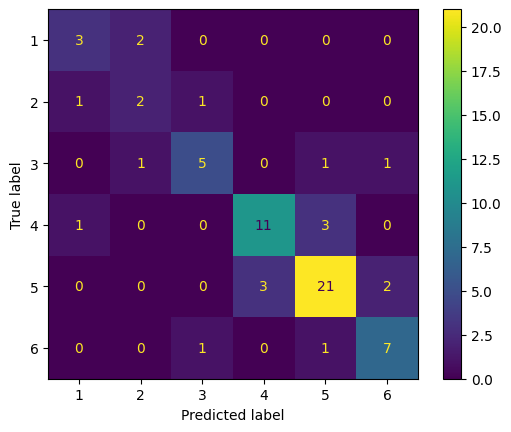

In [158]:
X_train, X_test, y_train, y_test = train_test_split(features_indi, label_classe, test_size = 0.30)

clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)  
print()

print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

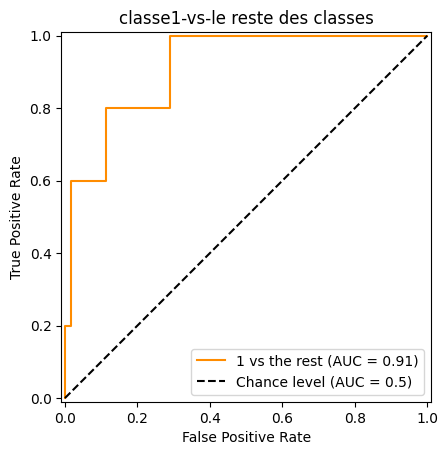

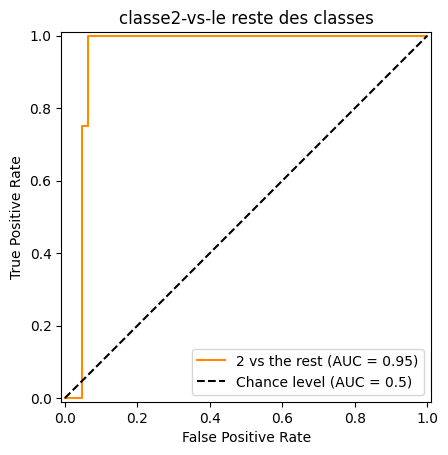

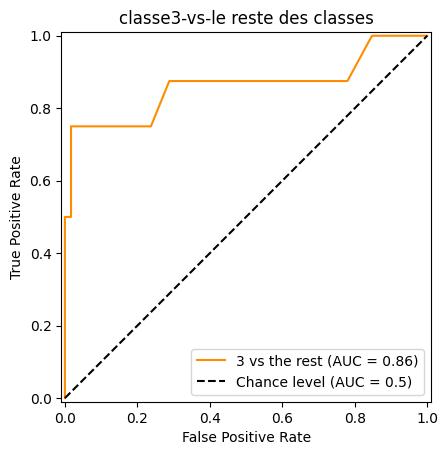

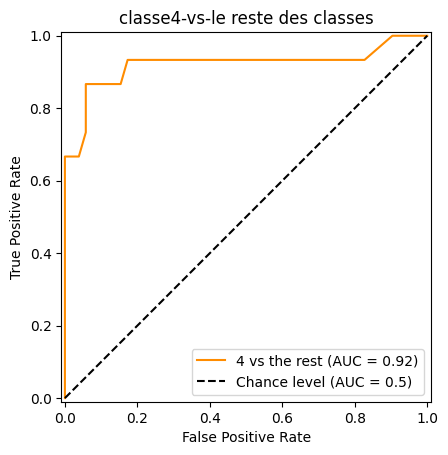

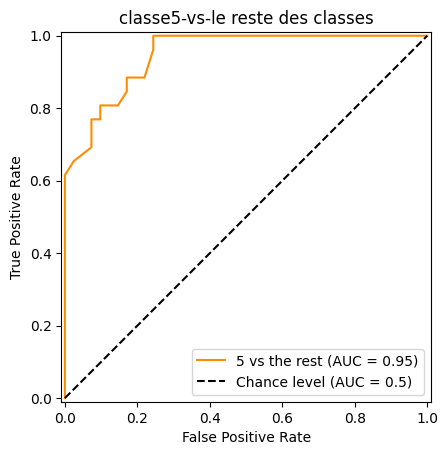

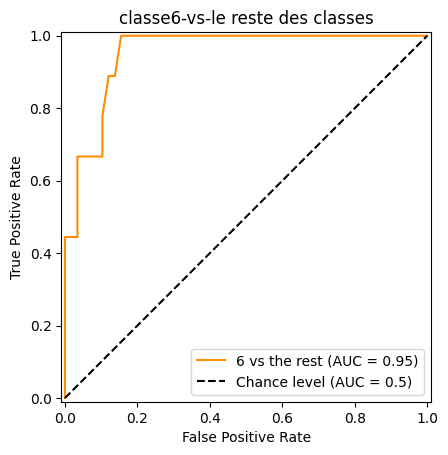

In [159]:
for i in range(1,7):
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    class_of_interest = i
    if np.flatnonzero(label_binarizer.classes_ == class_of_interest).shape[0]>0:
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{class_of_interest} vs the rest",
            color="darkorange",
            plot_chance_level=True,
        )
        _ = display.ax_.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title="classe"+str(i)+"-vs-le reste des classes",
        )

In [ ]:
acc=[]
for k in range(20):
    delta_t=k
    data_decal=pd.DataFrame(features_indi)
    data_decal=data_decal.shift(periods=delta_t)
    data_decal=data_decal[delta_t:]
    X_train, X_test, y_train, y_test = train_test_split(data_decal, label_classe[delta_t:], test_size = 0.30)

    clf = RandomForestClassifier(n_estimators = 100) 

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)  
    print()
    acc.append(metrics.accuracy_score(y_test, y_pred))
    print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

plt.plot(acc)

# Prédictions avec SARIMA

In [ ]:
def forme_donnees_entree_sortie_sarima(n,interet,data_train,data_test):
    #### met les données d'entrée dans le bon format pour être utilisées par la foret aleatoire dans le cadre de la prédiction avec SARIMA avec historique

    #### cette fonction prend les variables suivantes en entrée :
    # n = nombre de valeurs précédentes à mettre dans le liste
    # interet = nom de la colonne que l'on cherche à prédire dans la dataframe
    # data_train = dataframe d'entrainement 
    # data_test = dataframe de validation
    
    #### et rend les variables suivantes en sortie :
    # x_gr_tr = liste contenant les listes de données nécessaires au modèle, avec un recul de n jours qui serviront à l'entrainement
    # y_train = liste des valeurs à prédire pour l'entrainement
    # x_gr_test = liste contenant les listes de données nécessaires au modèle, avec un recul de n jours qui serviront à la validation
    # y_test = liste des valeurs à prédire pour la validation

    new_data_train = ajoute_val_prec(['MMM','dhw'],data_train,n)
    new_data_train = pd.merge(new_data_train,rec_ind_data_sal)
    new_data_test = ajoute_val_prec(['MMM','dhw'],data_test,n)
    new_data_test = pd.merge(new_data_test,rec_ind_data_sal,on='DateTime')

    y_train = new_data_train[interet]
    y_test = new_data_test[interet]
    x_gr_tr  = []
    x_gr_test  = []
    cate = [ 'liste de dhw', 'liste de MMM']
    for i in range (new_data_train.shape[0]):
        li = [(np.array(new_data_train[colonne].values[i])).flatten() for colonne in cate]
        li = flatten_list(li)
        x_gr_tr.append(li)
    for i in range (new_data_test.shape[0]):
        li = [(np.array(new_data_test[colonne].values[i])).flatten() for colonne in cate]
        li = flatten_list(li)
        x_gr_test.append(li)
    return(x_gr_tr,y_train,x_gr_test,y_test)


ACCURACY OF THE MODEL: 0.0


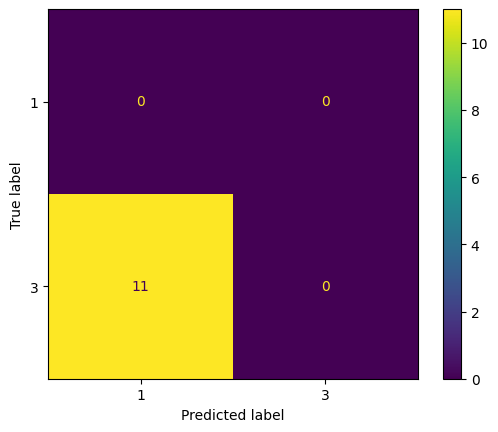

In [ ]:
X_train,y_train,X_test,y_test=forme_donnees_entree_sortie_sarima(30,'classe3',sst_true[sst_true['DateTime']<pd.to_datetime('2005-01-01')],sst_predict[sst_predict['DateTime']>pd.to_datetime('2005-01-01')])
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)  
print()

print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Différentes classes en fonction des genres

In [ ]:
rec_amp_e_g = pd.read_csv('donnees corail/amp_eo_genre.csv', sep= ',')
rec_amp_e_g['DateTime'] = rec_amp_w['DateTime'].astype('datetime64[ns]')

In [ ]:
rec_ind_data_g = pd.merge(rec_amp_e_g, fill_sst, on = 'DateTime', how = 'inner')
av_pdo_g = rec_ind_data_g.copy()
rec_ind_data_g = pd.merge(rec_ind_data_g, pdo, on = 'DateTime', how = 'inner') # enleve beaucoup de données
rec_ind_data_g = pd.merge(rec_ind_data_g, fill_energy_integrated, on = 'DateTime', how = 'inner')
av_pdo_g=pd.merge(av_pdo_g,fill_energy_integrated, on='DateTime',how='inner')
av_pdo_g=pd.merge(av_pdo_g,fill_houle, on='DateTime',how='inner')

In [ ]:
X_descri = av_pdo_g[['MMM','dhw','thermal_stress_category','puissance STL','phioc']]
std_scale = preprocessing.StandardScaler().fit(X_descri)
X_scaled = std_scale.transform(X_descri)

pca = decomposition.PCA(n_components=5)

pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)
recouvrement = av_pdo_g['score']
plt.scatter(X_projected[:,0], X_projected[:,1], c=recouvrement)
plt.colorbar(label="catégorie")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.plot()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(av_pdo_g[[ 'dhw', 'MMM', 'thermal_stress_category','phioc','puissance STL']], av_pdo_g['score'], test_size = 0.30)

#rec_ind_data_entrainement=pd.concat([rec_ind_data_sal[rec_ind_data_sal['DateTime']<=pd.to_datetime('2015-01-01')],rec_ind_data_sal[rec_ind_data_sal['DateTime']>=pd.to_datetime('2018-01-01')]])
#rec_ind_data_test=rec_ind_data_sal[(rec_ind_data_sal['DateTime']>pd.to_datetime('2015-01-01'))&(rec_ind_data_sal['DateTime']<pd.to_datetime('2018-01-01'))]
#X_train, y_train = rec_ind_data_entrainement[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']], rec_ind_data_entrainement['classe']
#X_test, y_test = rec_ind_data_test[['pdo', 'dhw', 'MMM','phioc','indicateur p grad sans filtre','puissance STL','salinite']], rec_ind_data_test['classe']

clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)  
print()

print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))

confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()